### Table of Contents

* [1. Library Import](#chapter1)
* [2. Data Import](#chapter2)
* [3. Overview Before Cleaning](#chapter3)
* [4. Concatenation](#chapter4)
    * [4.1. Common / Different Columns](#section_4_1)
    * [4.2. Location / Latitude / Longitude](#section_4_2)
    * [4.3. Renaming and Deleting Columns](#section_4_3)
    * [4.4. Concatenation of df_2015 and df_2016](#section_4_4)
* [5. Targets](#chapter5)
    * [5.1. NaN in Targets](#section_5_1)
    * [5.2. Targets Exploration](sSection_5_2)
        * [5.2.1. SiteEnergyUse](#section_5_2_1)
        * [5.2.2. TotalGHGEmissions](#section_5_2_2)
* [6. Removal Of Residential Buildings](#chapter6)
* [7. Changing Values in Columns](#chapter7)
* [8. NaN Imputation in SecondLargestPropertyUseType/GFA and ThirdLargestPropertyUseType/GFA](#chapter8)
* [9. Columns Removal](#chapter9)
* [10. Feature Engineering](#chapter10)
    * [10.1. Latitude / Longitude](#section_10_1)
    * [10.2. Neighborhood](#section_10_2)
    * [10.3. Age](#section_10_3)
    * [10.4. ListOfAllPropertyUseTypes](#section_10_4)
    * [10.5. LargestPropertyUseTypeGFA / SecondLargestPropertyUseTypeGFA / ThirdLargestPropertyUseTypeGFA](#section_10_5)
    * [10.6. SteamUse / Electricity / NaturalGas / SiteEnergyUse](#section_10_6)
* [11. Cleaning](#chapter11)
    * [11.1. Columns Drop](#section_11_1)
    * [11.2. NaN](#section_11_2)
    * [11.3. Outliers in Targets](#section_11_3)
* [12. Exploratory](#chapter12)

# 1. Library Import <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from scipy.stats import normaltest, shapiro
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn import ensemble
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
import h3
from geopy.geocoders import Nominatim

# 2. Data Import <a class="anchor" id="chapter2"></a>

In [2]:
data_2015 = pd.read_csv("2015-building-energy-benchmarking.csv", sep = ',')
data_2016 = pd.read_csv("2016-building-energy-benchmarking.csv", sep = ',')

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
data_2015.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  \
0   MAYFLOWER PARK HOTEL                     659000030   
1        PARAMOUNT HOTEL                     659000220   
2           WESTIN HOTEL                     659000475   
3              HOTEL MAX                     659000640   
4  WARWICK SEATTLE HOTEL                     659000970   

                                            Location  CouncilDistrictCode  \
0  {'latitude': '47.61219025', 'longitude': '-122...                    7   
1  {'latitude': '47.61310583', 'longitude': '-122...                    7   
2  {'latitude': '47.61334897', 'longitude': '-122...                    7   
3  {'latitude': '47.61421585', 'longitude': '-122...                    7   
4  {'latitude': '47.6137544', 'longitude': '-122....                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   
3     DOWNTOWN       1926                  1            10.0   
4     DOWNTOWN       1980                  1            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   
3             61320                   0                   61320   
4            119890               12460                  107430   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   
3                    61320.0                          NaN   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   
3                              NaN                         NaN   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   
3                             NaN                      NaN              1.0   
4                             0.0                      NaN             67.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   
3             460.4               462.5               636.3   
4             120.1               122.1               228.8   

   SourceEUIWN(kBtu/sf)  SiteEner

In [5]:
data_2016.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

# 3. Overview Before Cleaning <a class="anchor" id="chapter3"></a>

In [6]:
df_2015 = data_2015.copy()
df_2016 = data_2016.copy()

In [7]:
sns.set_theme(style = 'darkgrid')

In [8]:
def DataSetsExplo(df):
    print("Dataset has ", df.shape[0], "rows and ", df.shape[1], "columns")
    
    print("Number of non-null values by columns :")
    print(df.count())
    
    plt.figure(figsize = (45,15))
    plt.title('Number of non-null values by columns', fontsize = 30)
    plt.xlabel('columns', size = 20)
    plt.ylabel('number of non-null values', size = 20)
    plt.xticks(fontsize = 18, rotation = 90)
    plt.yticks(fontsize = 18)
    sns.barplot(x = df.columns, y = df.count())

    print("Value type per column :")
    print(df.dtypes)

Dataset has  3340 rows and  47 columns
Number of non-null values by columns :
OSEBuildingID                                                    3340
DataYear                                                         3340
BuildingType                                                     3340
PrimaryPropertyType                                              3340
PropertyName                                                     3340
TaxParcelIdentificationNumber                                    3338
Location                                                         3340
CouncilDistrictCode                                              3340
Neighborhood                                                     3340
YearBuilt                                                        3340
NumberofBuildings                                                3340
NumberofFloors                                                   3332
PropertyGFATotal                                                 3340
PropertyGFAP

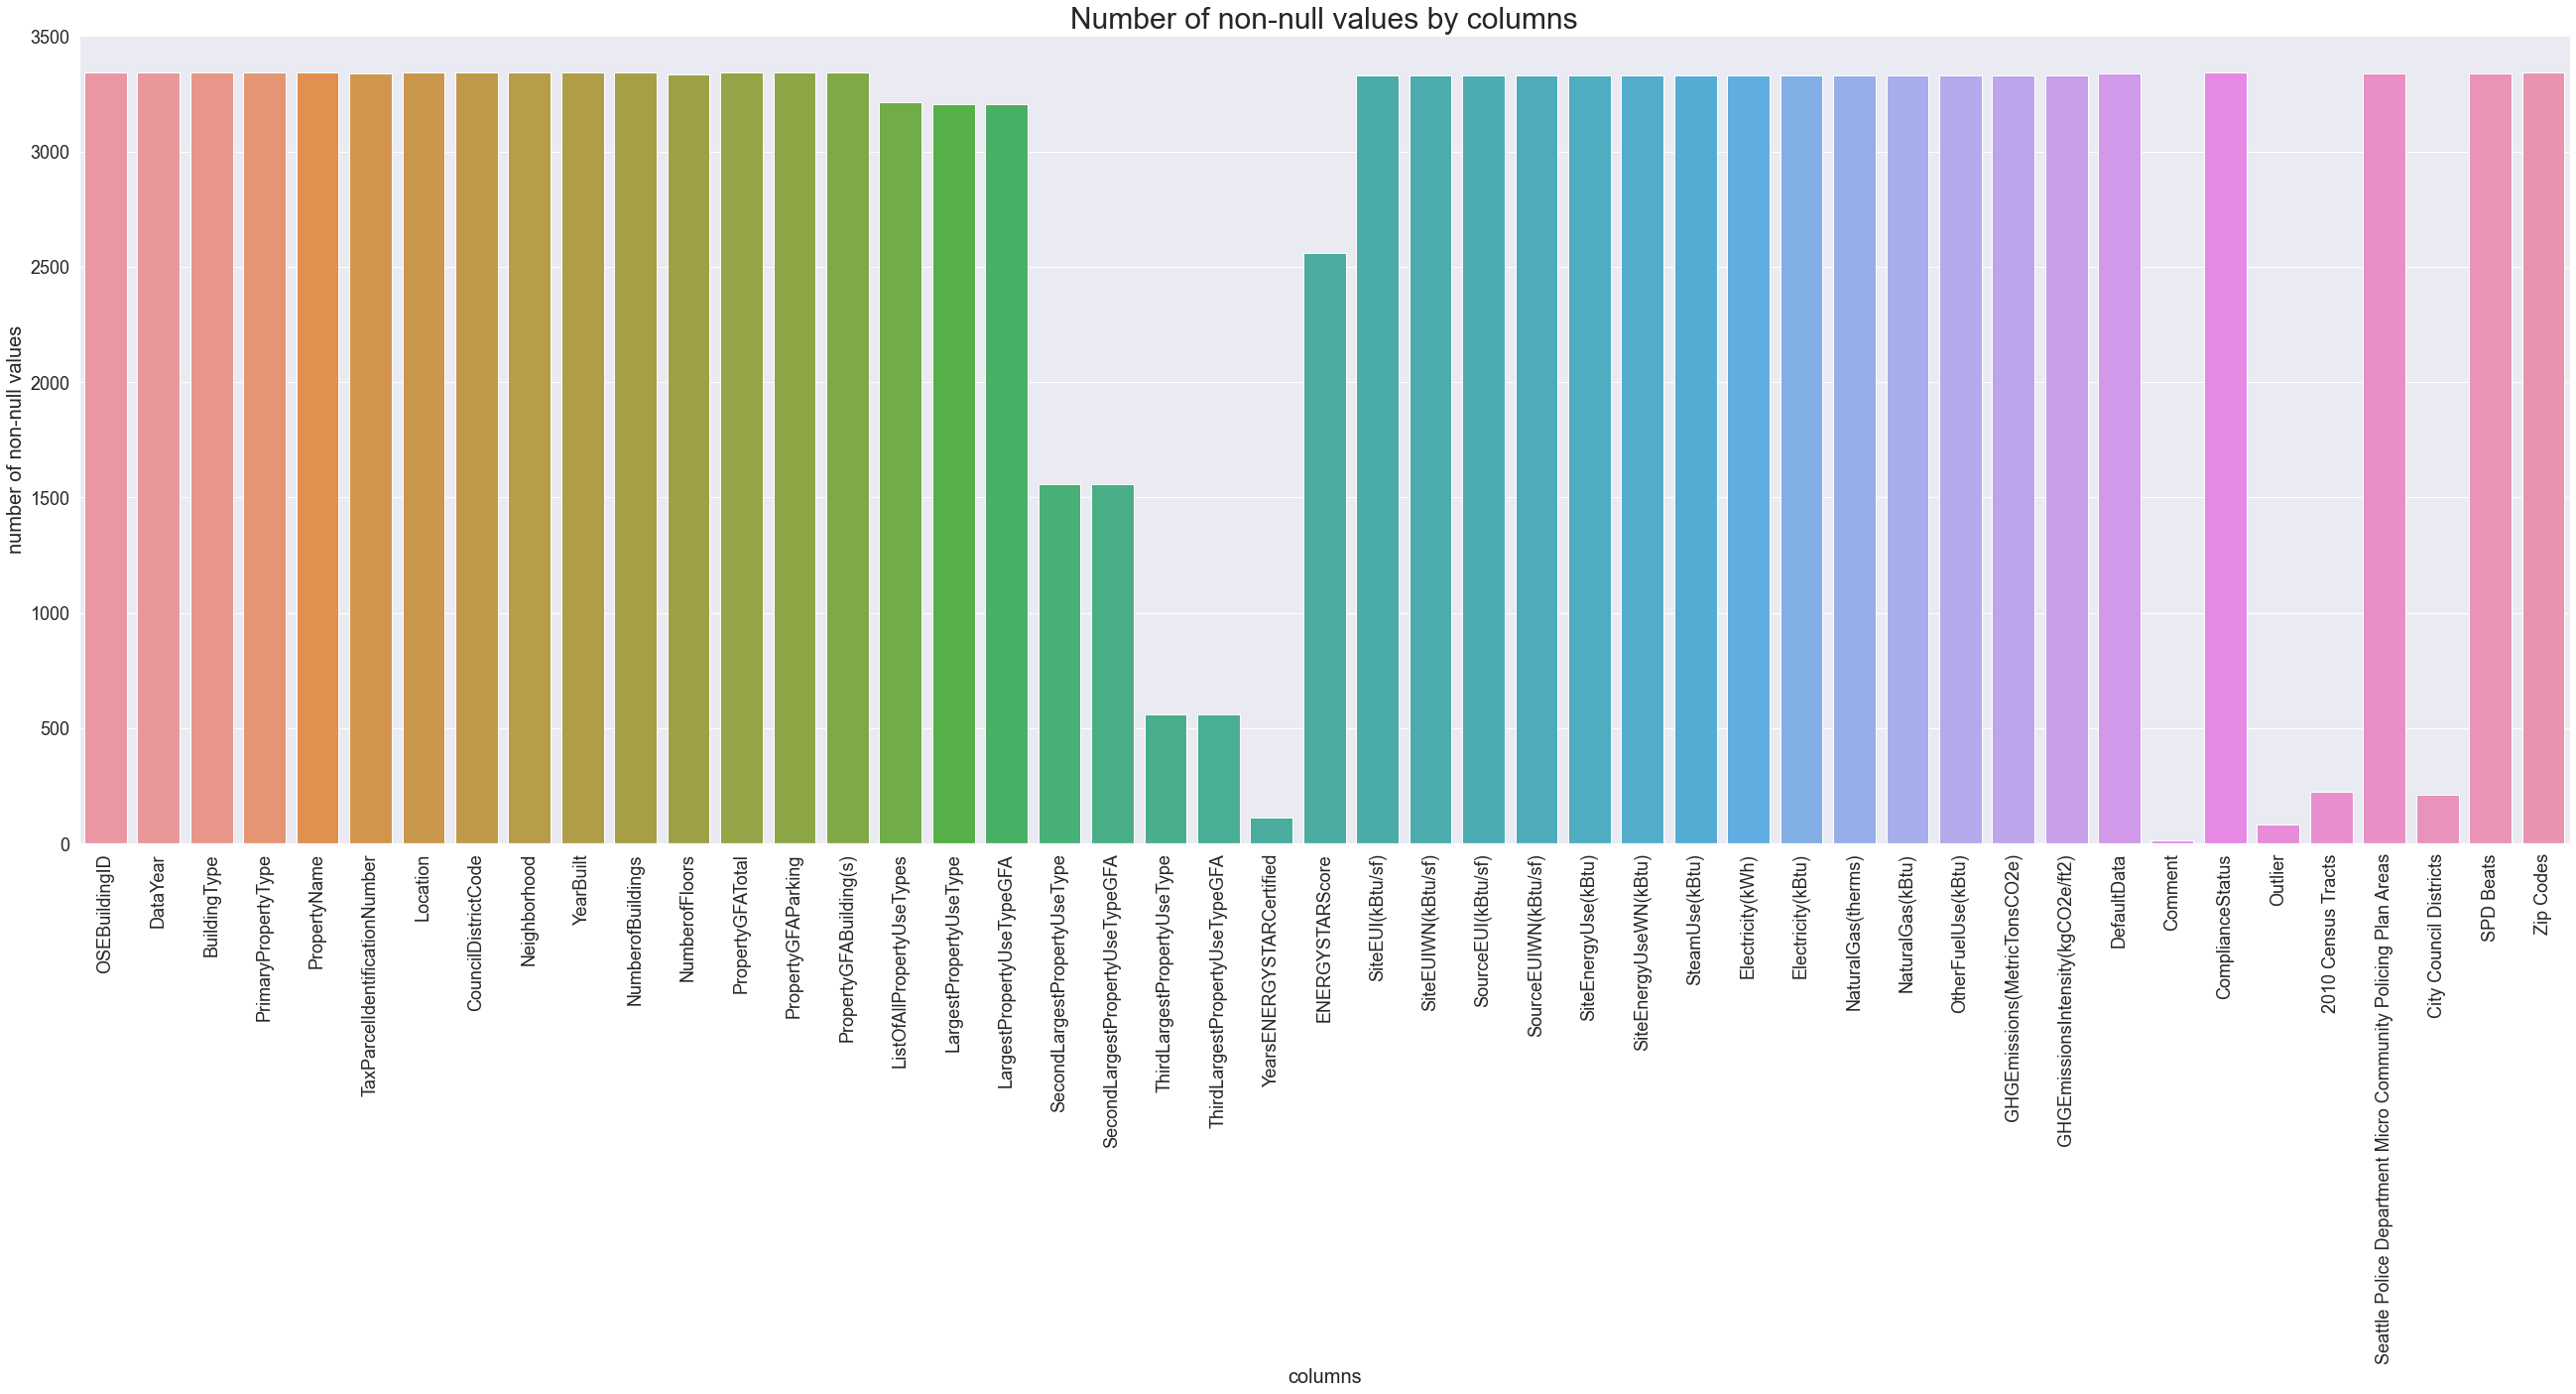

In [9]:
DataSetsExplo(df_2015)

Dataset has  3376 rows and  46 columns
Number of non-null values by columns :
OSEBuildingID                      3376
DataYear                           3376
BuildingType                       3376
PrimaryPropertyType                3376
PropertyName                       3376
Address                            3376
City                               3376
State                              3376
ZipCode                            3360
TaxParcelIdentificationNumber      3376
CouncilDistrictCode                3376
Neighborhood                       3376
Latitude                           3376
Longitude                          3376
YearBuilt                          3376
NumberofBuildings                  3368
NumberofFloors                     3376
PropertyGFATotal                   3376
PropertyGFAParking                 3376
PropertyGFABuilding(s)             3376
ListOfAllPropertyUseTypes          3367
LargestPropertyUseType             3356
LargestPropertyUseTypeGFA          3356
Se

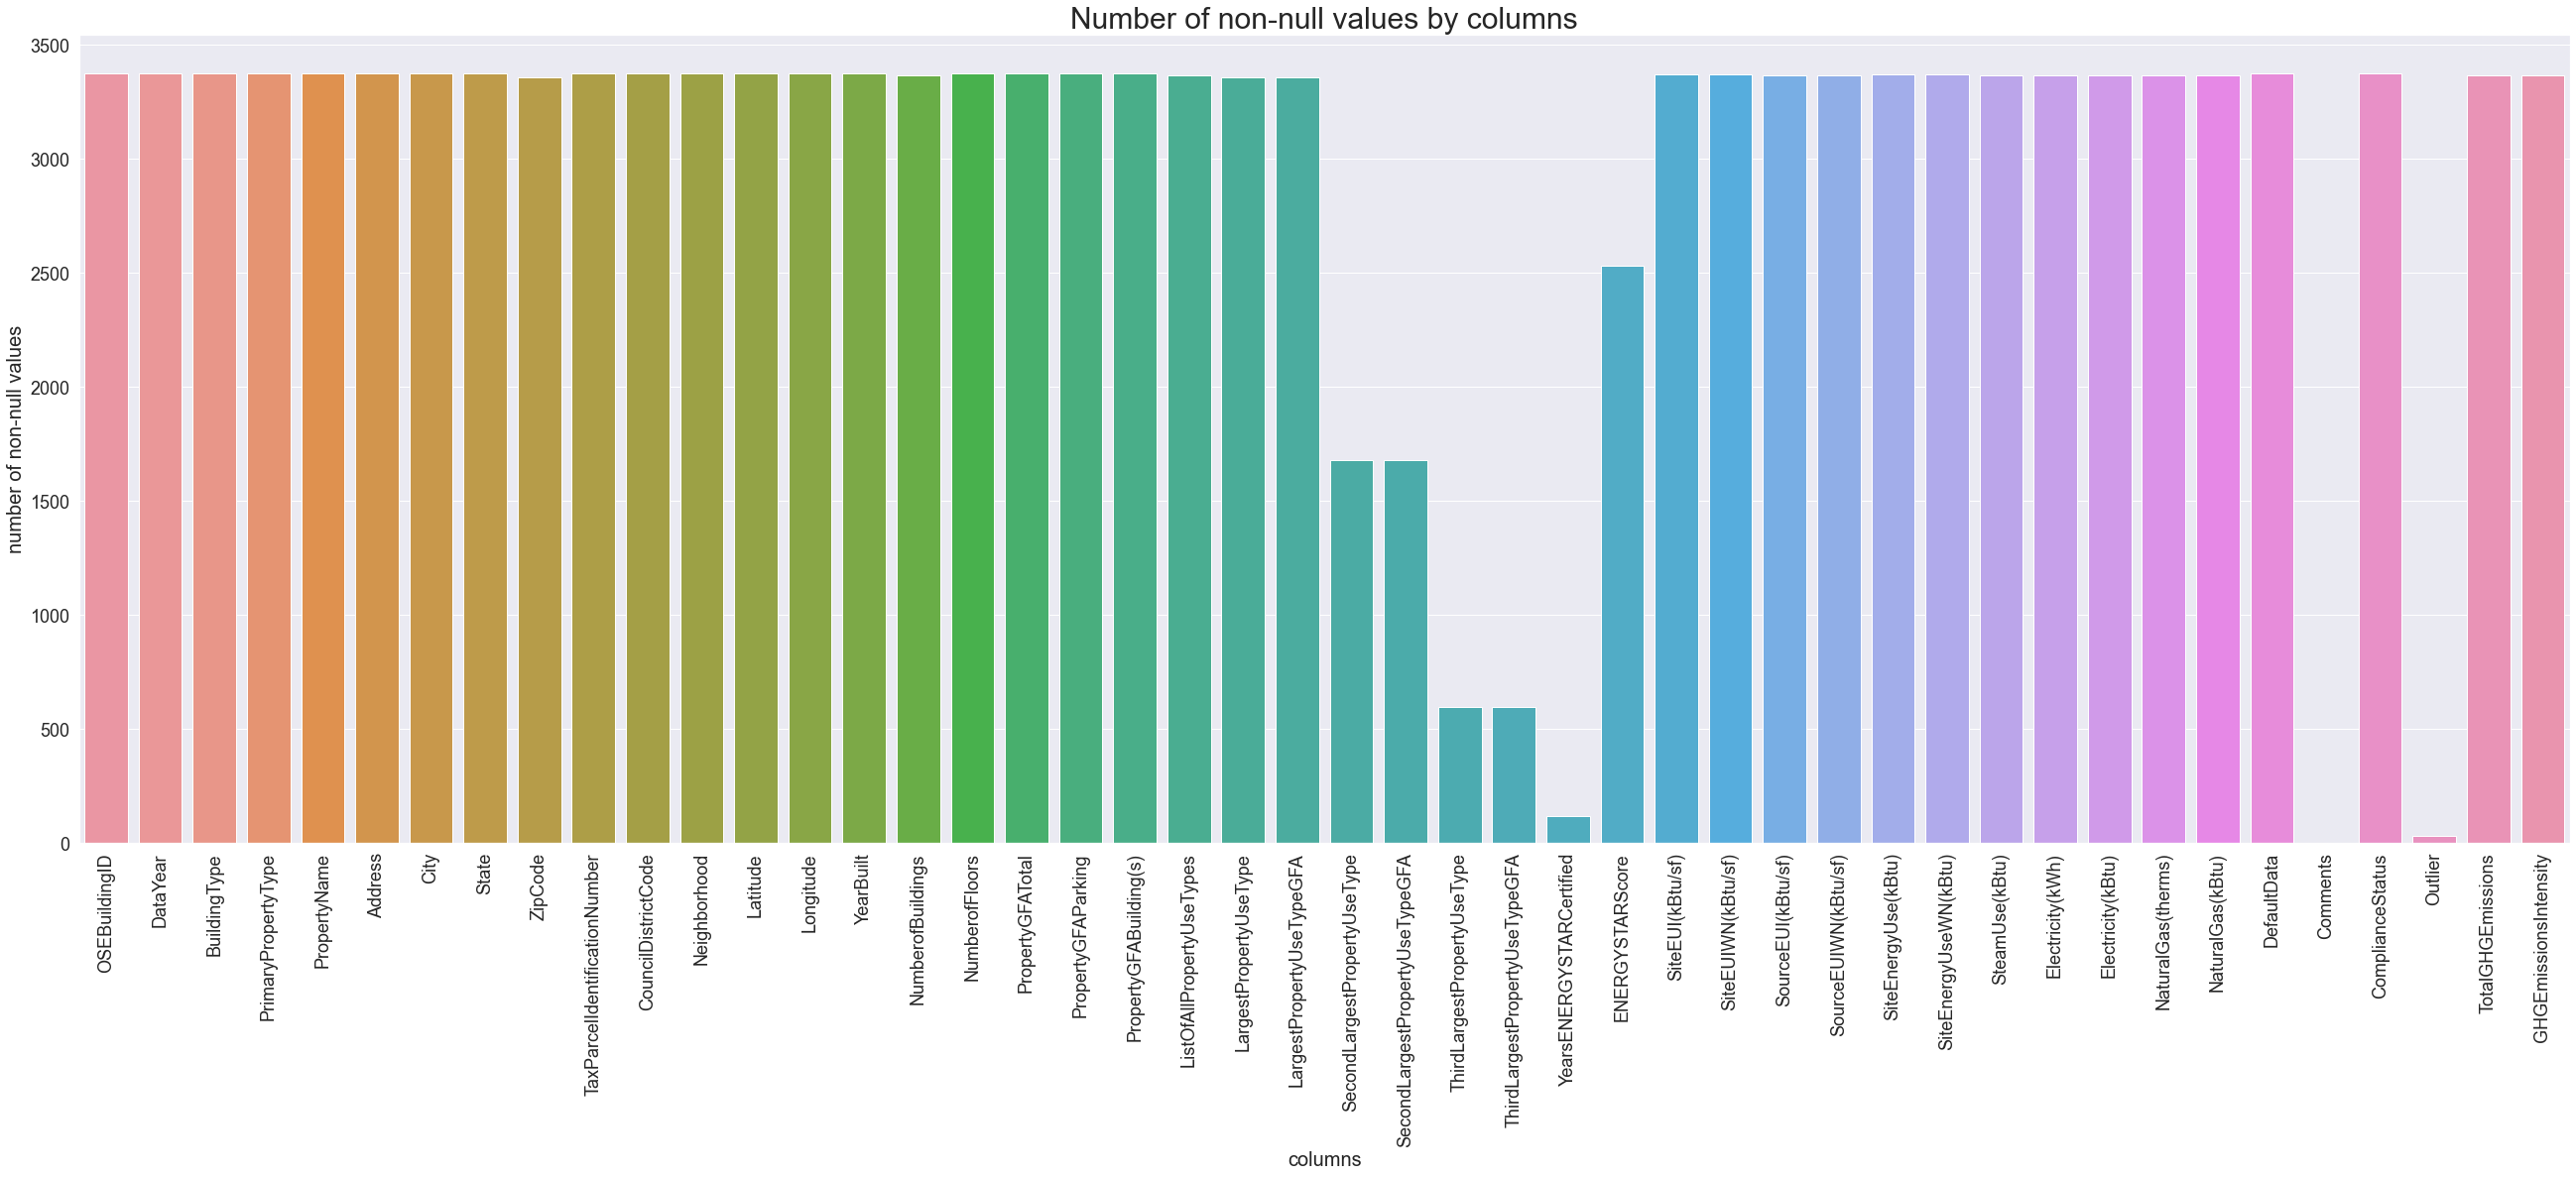

In [10]:
DataSetsExplo(df_2016)

- We can see that df_2015 and df_2016 do not have the same dimensions.
- They don't have the same number of rows (buildings) and columns (variables).

# 4. Concatenation <a class="anchor" id="chapter4"></a>

## 4.1. Common / Different Columns <a class="anchor" id="section_4_1"></a>

In this section, we will see which columns are not common to the 2 datasets.

In [11]:
def data_columns_compare(df1, df2):
    df1_columns = df1.columns
    df2_columns = df2.columns
    df1_in_df2 = df1_columns.isin(df2_columns)
    df2_in_df1 = df2_columns.isin(df1_columns)
    df1_not_in_df2 = []
    df2_not_in_df1 = []

    print('Columns present in the first dataset but not in the second one : \n')
    for i in range(len(df1_in_df2)):
        if df1_in_df2[i] == False:
            df1_not_in_df2.append(df1_columns[i])
    print(df1_not_in_df2)
    print('\nColumns present in the second dataset but not in the first one : \n')
    for i in range(len(df2_in_df1)):
        if df2_in_df1[i] == False:
            df2_not_in_df1.append(df2_columns[i])
    print(df2_not_in_df1)

In [12]:
data_columns_compare(df_2015, df_2016)

Columns present in the first dataset but not in the second one : 

['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes']

Columns present in the second dataset but not in the first one : 

['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


## 4.2. Location / Latitude / Longitude <a class="anchor" id="section_4_2"></a>

In this section, we will separate 'Location' in df_2015 into 'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude'.

In [13]:
df_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

In [14]:
type(df_2015['Location'][0])

str

In [15]:
df_2015['Location'] = df_2015['Location'].apply(literal_eval)

df_2015['Latitude'] = df_2015['Location'].apply(lambda x : x['latitude'])
df_2015['Longitude'] = df_2015['Location'].apply(lambda x : x['longitude'])
df_2015['Human_address'] = df_2015['Location'].apply(lambda x : x['human_address'])

df_2015['Human_address'] = df_2015['Human_address'].apply(literal_eval)

df_2015['Address'] = df_2015['Human_address'].apply(lambda x : x['address'])
df_2015['City'] = df_2015['Human_address'].apply(lambda x : x['city'])
df_2015['State'] = df_2015['Human_address'].apply(lambda x : x['state'])
df_2015['ZipCode'] = df_2015['Human_address'].apply(lambda x : x['zip'])

In [16]:
df_2015.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  \
0   MAYFLOWER PARK HOTEL                     659000030   
1        PARAMOUNT HOTEL                     659000220   
2           WESTIN HOTEL                     659000475   
3              HOTEL MAX                     659000640   
4  WARWICK SEATTLE HOTEL                     659000970   

                                            Location  CouncilDistrictCode  \
0  {'latitude': '47.61219025', 'longitude': '-122...                    7   
1  {'latitude': '47.61310583', 'longitude': '-122...                    7   
2  {'latitude': '47.61334897', 'longitude': '-122...                    7   
3  {'latitude': '47.61421585', 'longitude': '-122...                    7   
4  {'latitude': '47.6137544', 'longitude': '-122....                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   
3     DOWNTOWN       1926                  1            10.0   
4     DOWNTOWN       1980                  1            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   
3             61320                   0                   61320   
4            119890               12460                  107430   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   
3                    61320.0                          NaN   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   
3                              NaN                         NaN   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   
3                             NaN                      NaN              1.0   
4                             0.0                      NaN             67.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   
3             460.4               462.5               636.3   
4             120.1               122.1               228.8   

   SourceEUIWN(kBtu/sf)  SiteEner

## 4.3. Renaming and Deleting Columns <a class="anchor" id="section_4_3"></a>

In this section, we will rename some column names and delete some columns (which are not common to df_2015 and df_2016).

In [17]:
df_2015.rename(columns = {'Comment': 'Comments', 'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions', 'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}, inplace = True)

In [18]:
df_2015.drop(['Location', 'Human_address', 'OtherFuelUse(kBtu)', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes'], axis = 1, inplace = True)

## 4.4. Concatenation of df_2015 and df_2016 <a class="anchor" id="section_4_4"></a>

In this section, we will concatenate df_2015 and df_2016.

In [19]:
data_columns_compare(df_2015, df_2016)

Columns present in the first dataset but not in the second one : 

[]

Columns present in the second dataset but not in the first one : 

[]


In [20]:
df_2015.drop_duplicates(subset = ['OSEBuildingID'], keep = 'first', inplace = True)
df_2016.drop_duplicates(subset = ['OSEBuildingID'], keep = 'first', inplace = True)

In [21]:
df = pd.concat([df_2015, df_2016])

In [22]:
df.reset_index(inplace = True, drop = True)

Dataset has  6716 rows and  46 columns
Number of non-null values by columns :
OSEBuildingID                      6716
DataYear                           6716
BuildingType                       6716
PrimaryPropertyType                6716
PropertyName                       6716
TaxParcelIdentificationNumber      6714
CouncilDistrictCode                6716
Neighborhood                       6716
YearBuilt                          6716
NumberofBuildings                  6708
NumberofFloors                     6708
PropertyGFATotal                   6716
PropertyGFAParking                 6716
PropertyGFABuilding(s)             6716
ListOfAllPropertyUseTypes          6580
LargestPropertyUseType             6560
LargestPropertyUseTypeGFA          6560
SecondLargestPropertyUseType       3238
SecondLargestPropertyUseTypeGFA    3238
ThirdLargestPropertyUseType        1156
ThirdLargestPropertyUseTypeGFA     1156
YearsENERGYSTARCertified            229
ENERGYSTARScore                    5093
Si

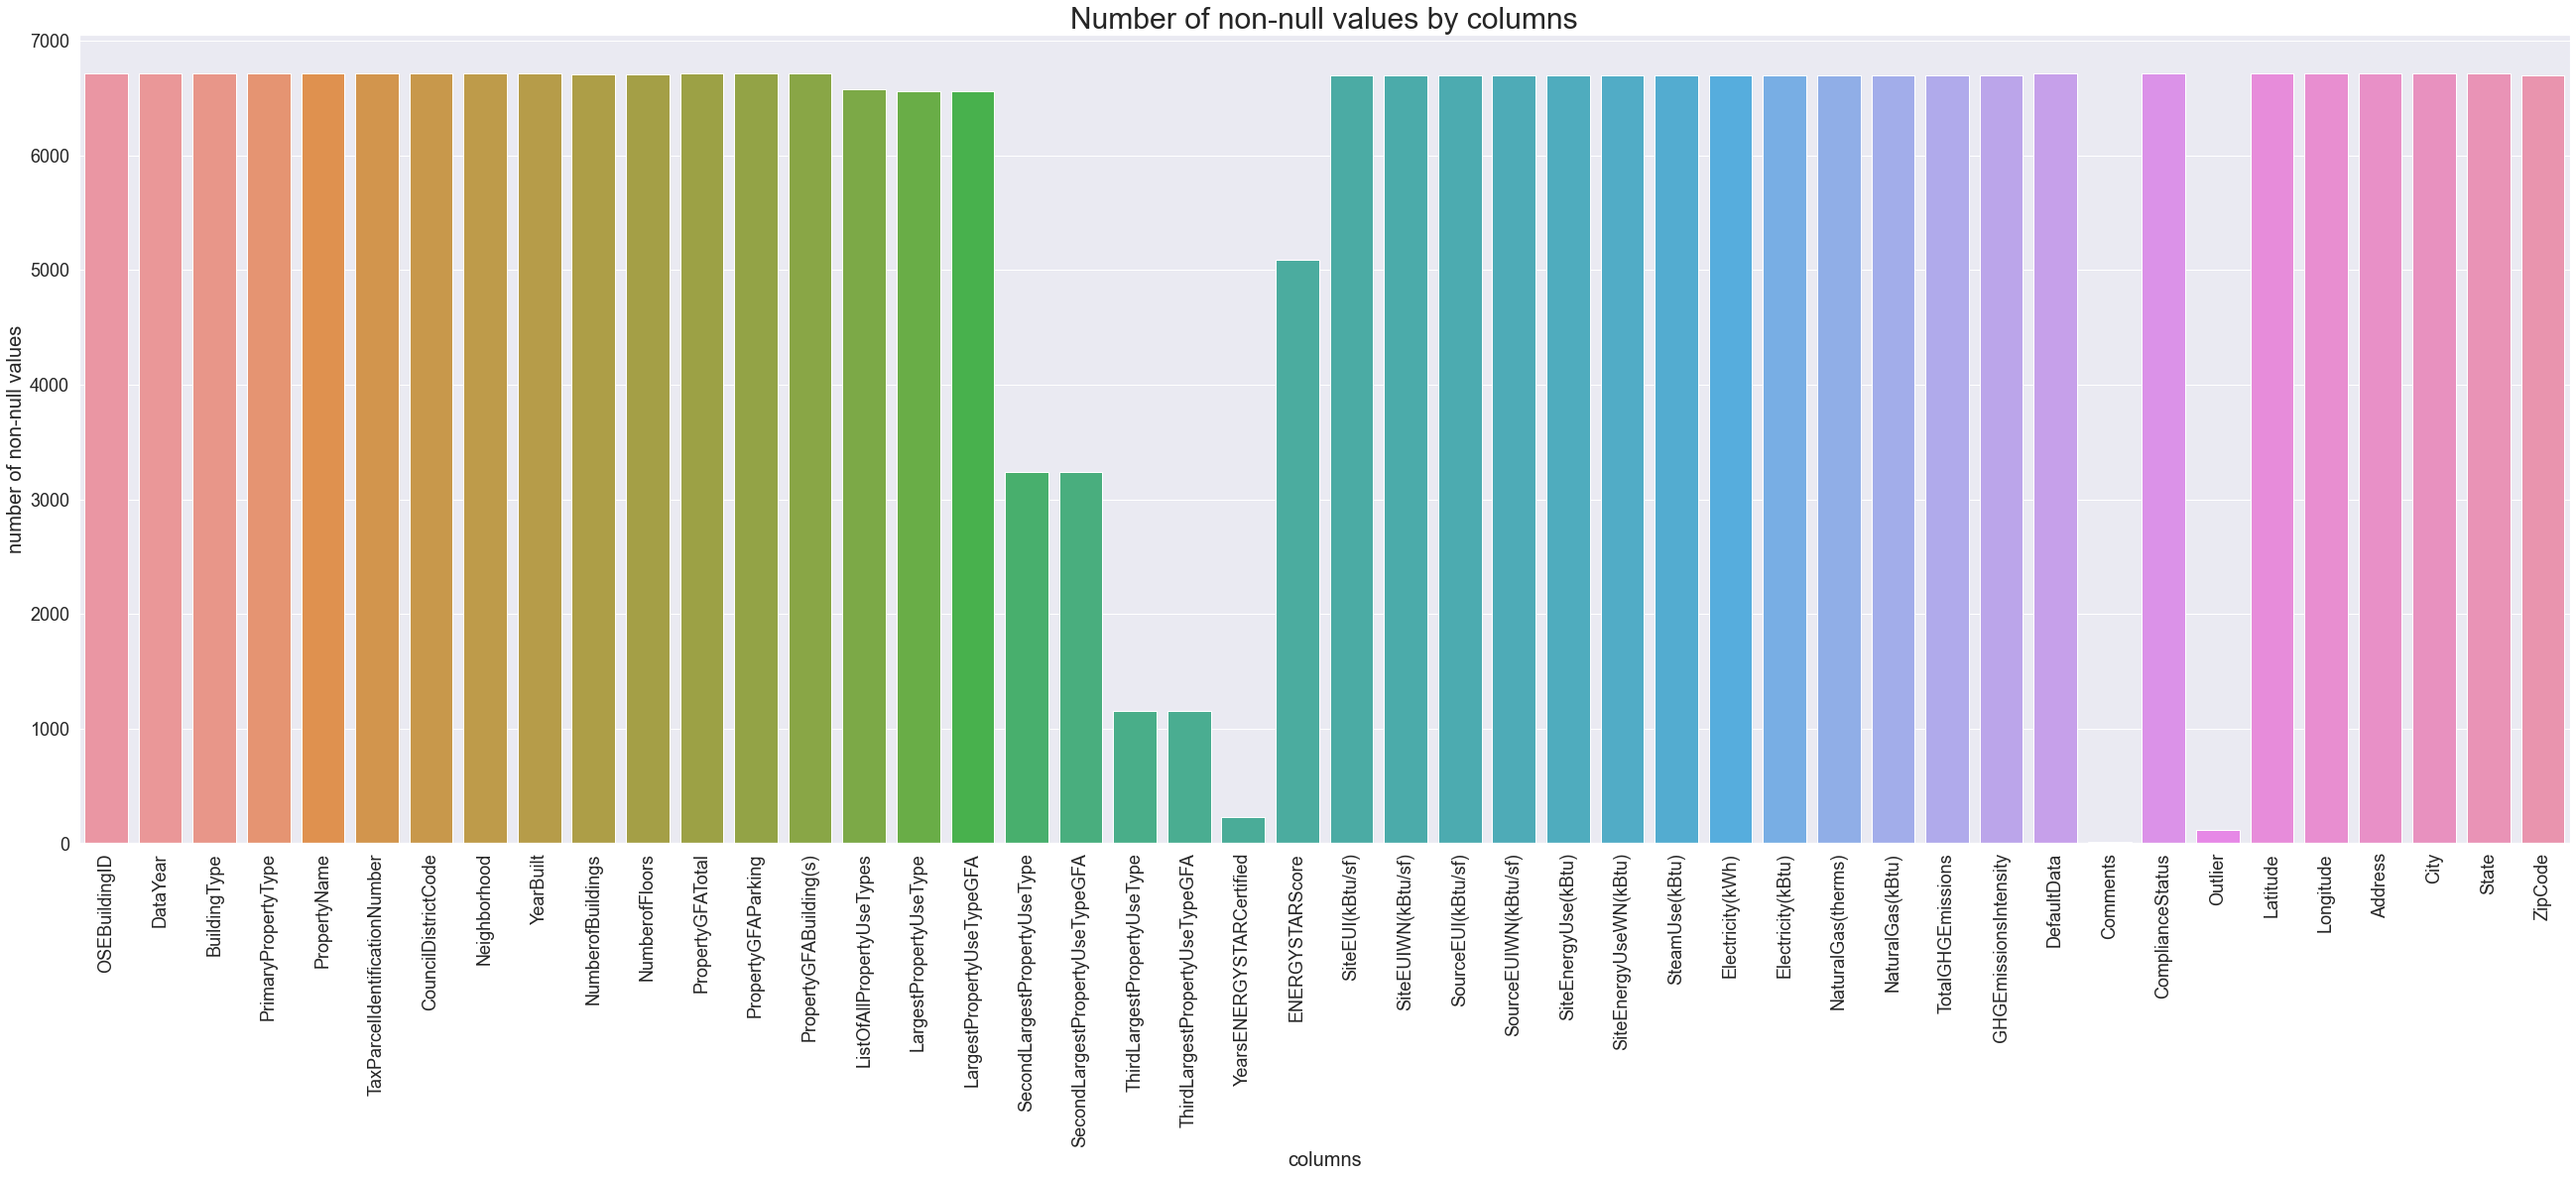

In [23]:
DataSetsExplo(df)

After the concatenation, the dataset has 6716 rows and 46 columns.

# 5. Targets <a class="anchor" id="chapter5"></a>

## 5.1. NaN in Targets <a class="anchor" id="section_5_1"></a>

In this part, we will delete rows (observations) with NaN in targets.

In [24]:
df.dropna(subset = ['TotalGHGEmissions'], inplace = True)
df.dropna(subset = ['SiteEnergyUse(kBtu)'], inplace = True)

Dataset has  6697 rows and  46 columns
Number of non-null values by columns :
OSEBuildingID                      6697
DataYear                           6697
BuildingType                       6697
PrimaryPropertyType                6697
PropertyName                       6697
TaxParcelIdentificationNumber      6695
CouncilDistrictCode                6697
Neighborhood                       6697
YearBuilt                          6697
NumberofBuildings                  6697
NumberofFloors                     6689
PropertyGFATotal                   6697
PropertyGFAParking                 6697
PropertyGFABuilding(s)             6697
ListOfAllPropertyUseTypes          6573
LargestPropertyUseType             6553
LargestPropertyUseTypeGFA          6553
SecondLargestPropertyUseType       3237
SecondLargestPropertyUseTypeGFA    3237
ThirdLargestPropertyUseType        1156
ThirdLargestPropertyUseTypeGFA     1156
YearsENERGYSTARCertified            229
ENERGYSTARScore                    5093
Si

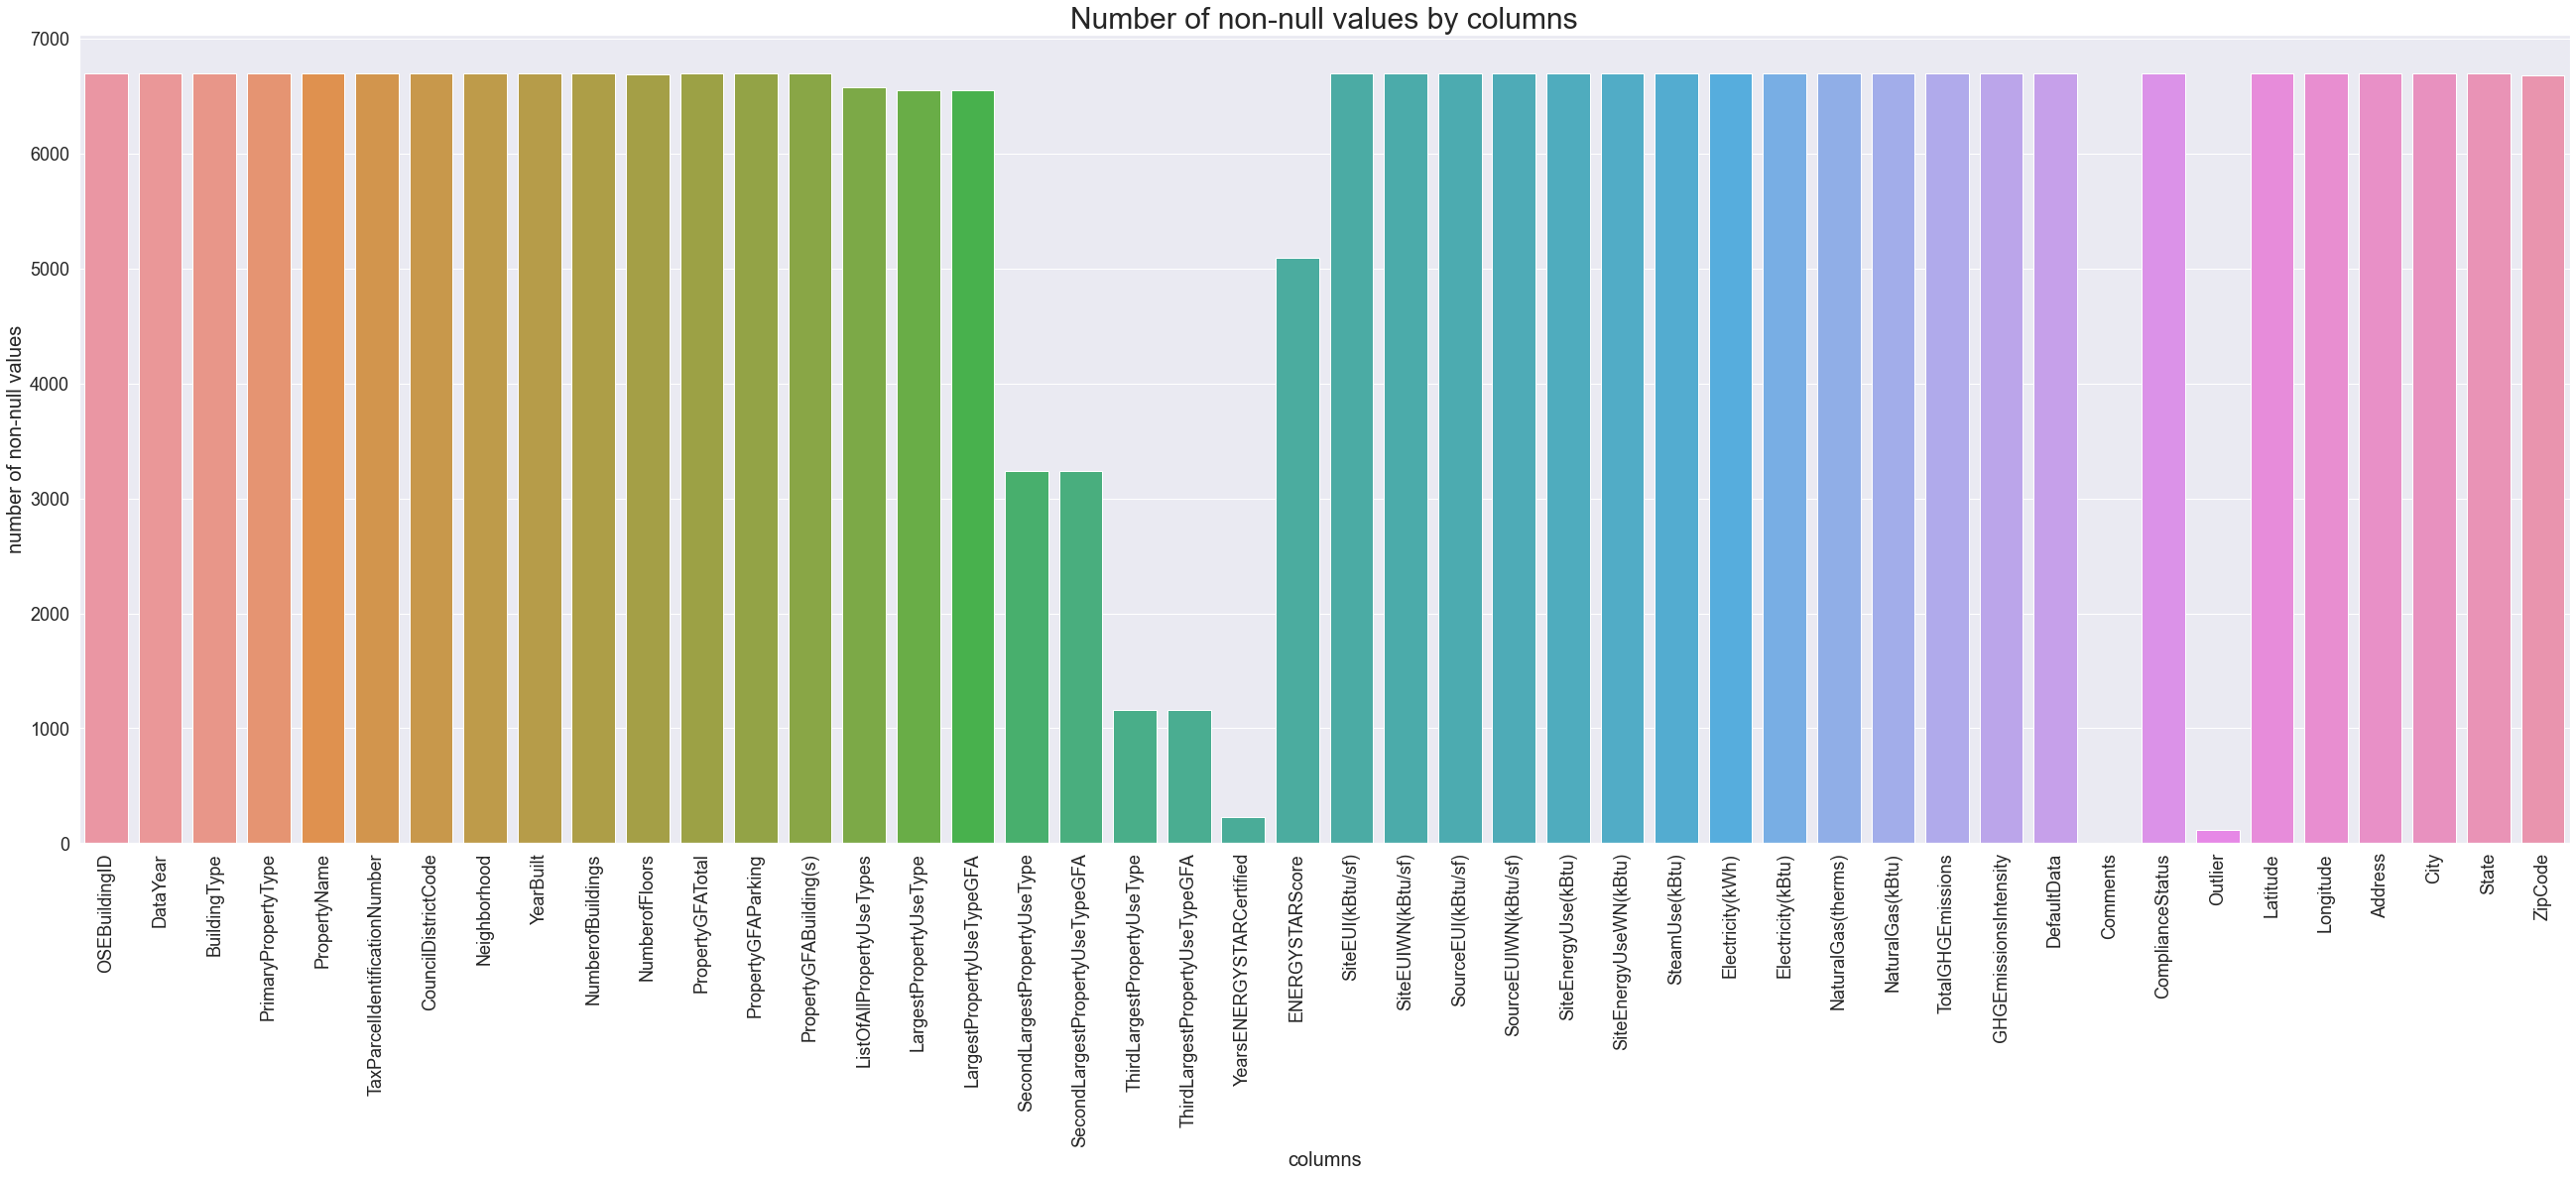

In [25]:
DataSetsExplo(df)

## 5.2. Targets Exploration <a class="anchor" id="section_5_2"></a>

In this section, we will study the distribution of targets.

In [26]:
def normality(df, columns, alph):
    print('Shapiro-Wilk test :')
    for col in columns:
        stat, p = shapiro(df[col])
        alpha = alph
        if p > alpha:
            print(f'{col :-<50} "Looks Gaussian"')
            print('Statistics = ', stat, 'p = ', p)
        else:
            print(f'{col :-<50} "Does not look Gaussian"')
            print('Statistics = ', stat, 'p = ', p)
    print('\n')
    print('Agostino test :')
    for col in columns:
        stat, p = normaltest(df[col])
        alpha = alph
        if p > alpha:
            print(f'{col :-<50} "Looks Gaussian"')  
            print('Statistics = ', stat, 'p = ', p)
        else:
            print(f'{col :-<50} "Does not look Gaussian"')
            print('Statistics = ', stat, 'p = ', p)

### 5.2.1. SiteEnergyUse <a class="anchor" id="section_5_2_1"></a>

<AxesSubplot:title={'center':'Histogram of SiteEnergyUse'}, xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

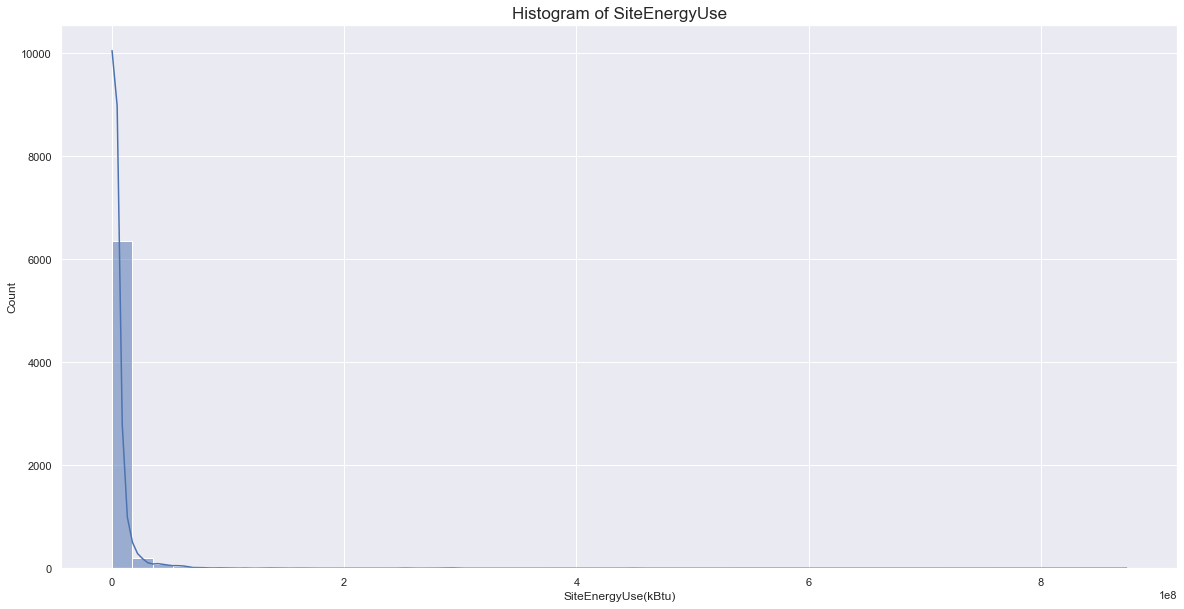

In [27]:
plt.figure(figsize = (20,10))
plt.title('Histogram of SiteEnergyUse', size = 17)
plt.xlabel('SiteEnergyUse(kBtu)', size = 12)
sns.histplot(df['SiteEnergyUse(kBtu)'], bins = 50, kde = True)

In [28]:
df.loc[df['SiteEnergyUse(kBtu)'] < 0]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), TotalGHGEmissions, GHGEmissionsIntensity, DefaultData, Comments, ComplianceStatus, Outlier, Latitude, Longitude, Address, City, State, ZipCode]
Index: []

In [29]:
df['SiteEnergyUse(kBtu)_log'] = np.log1p(df['SiteEnergyUse(kBtu)'])

<AxesSubplot:title={'center':'Histogram of SiteEnergyUse_log'}, xlabel='SiteEnergyUse(kBtu)_log', ylabel='Count'>

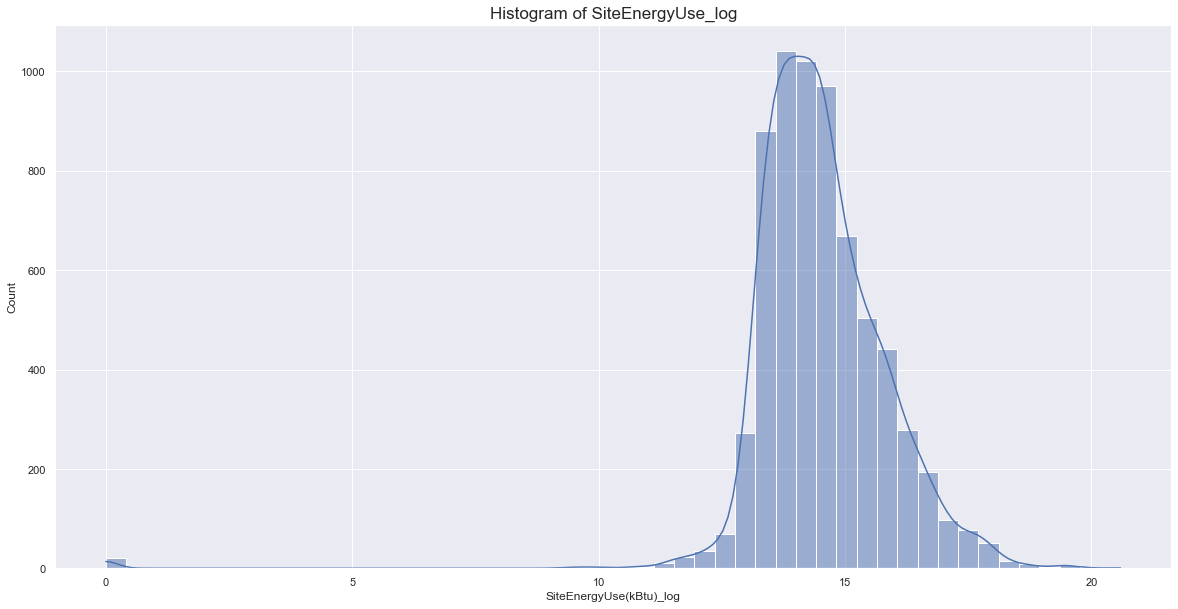

In [30]:
plt.figure(figsize = (20,10))
plt.title('Histogram of SiteEnergyUse_log', size = 17)
plt.xlabel('SiteEnergyUse(kBtu)_log', size = 12)
sns.histplot(df['SiteEnergyUse(kBtu)_log'], bins = 50, kde = True)

In [31]:
normality(df, ['SiteEnergyUse(kBtu)_log'], 0.05)

Shapiro-Wilk test :
SiteEnergyUse(kBtu)_log--------------------------- "Does not look Gaussian"
Statistics =  0.7987752556800842 p =  0.0


Agostino test :
SiteEnergyUse(kBtu)_log--------------------------- "Does not look Gaussian"
Statistics =  4889.623570235859 p =  0.0


C:\Users\melme\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### 5.2.2. TotalGHGEmissions <a class="anchor" id="section_5_2_2"></a>

<AxesSubplot:title={'center':'Histogram of TotalGHGEmissions'}, xlabel='TotalGHGEmissions', ylabel='Count'>

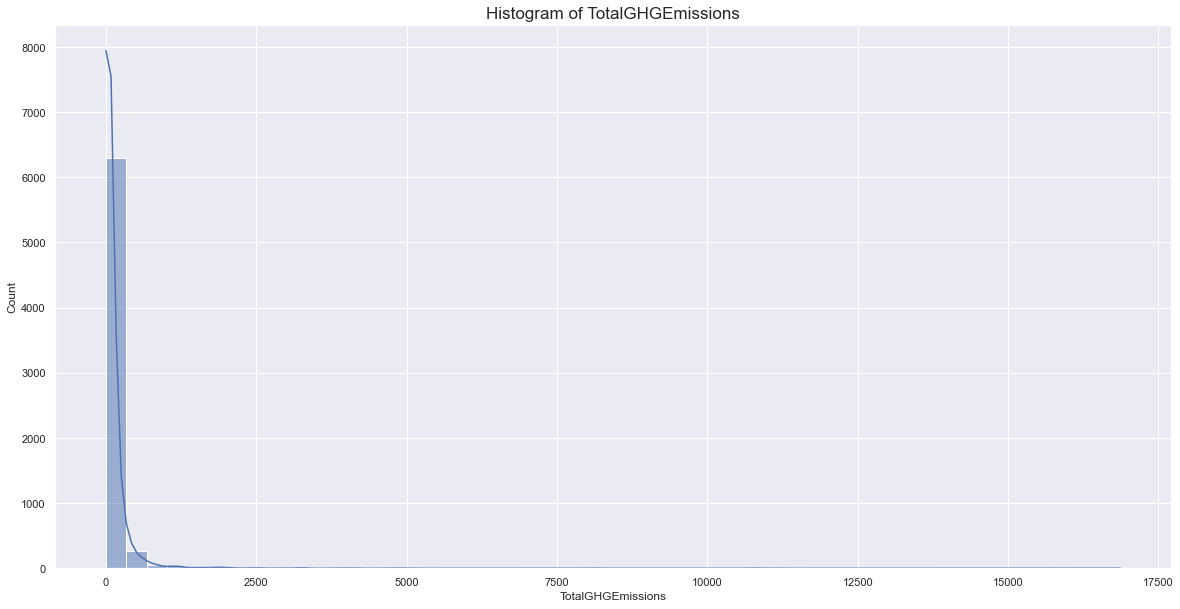

In [32]:
plt.figure(figsize = (20,10))
plt.title('Histogram of TotalGHGEmissions', size = 17)
plt.xlabel('TotalGHGEmissions', size = 12)
sns.histplot(df['TotalGHGEmissions'], bins = 50, kde = True)

In [33]:
df.loc[df['TotalGHGEmissions'] < 0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
6546          49784      2016  NonResidential  Small- and Mid-Sized Office   

        PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
6546  Bullitt Center                    7234600195                    3   

     Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
6546      CENTRAL       2013                1.0             6.0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
6546             52000                   0                   52000   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
6546                    Office                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
6546                    48159.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
6546                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
6546                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
6546            100.0               7.1                 5.0   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
6546                 2.0                  -2.1          342726.0938   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
6546            240132.0938             0.0      -33826.80078   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
6546          -115417.0                 0.0               0.0   

      TotalGHGEmissions  GHGEmissionsIntensity DefaultData Comments  \
6546               -0.8                  -0.02       False      NaN   

     ComplianceStatus Outlier Latitude Longitude              Address  \
6546        Compliant     NaN  47.6143  -122.313  1501 E. Madison St.   

         City State ZipCode  SiteEnergyUse(kBtu)_log  
6546  Seattle    WA   98122                 12.74469

In [34]:
df.drop(index = 6546, inplace = True)

In [35]:
df['TotalGHGEmissions_log'] = np.log1p(df['TotalGHGEmissions'])

<AxesSubplot:title={'center':'Histogram of TotalGHGEmissions_log'}, xlabel='TotalGHGEmissions_log', ylabel='Count'>

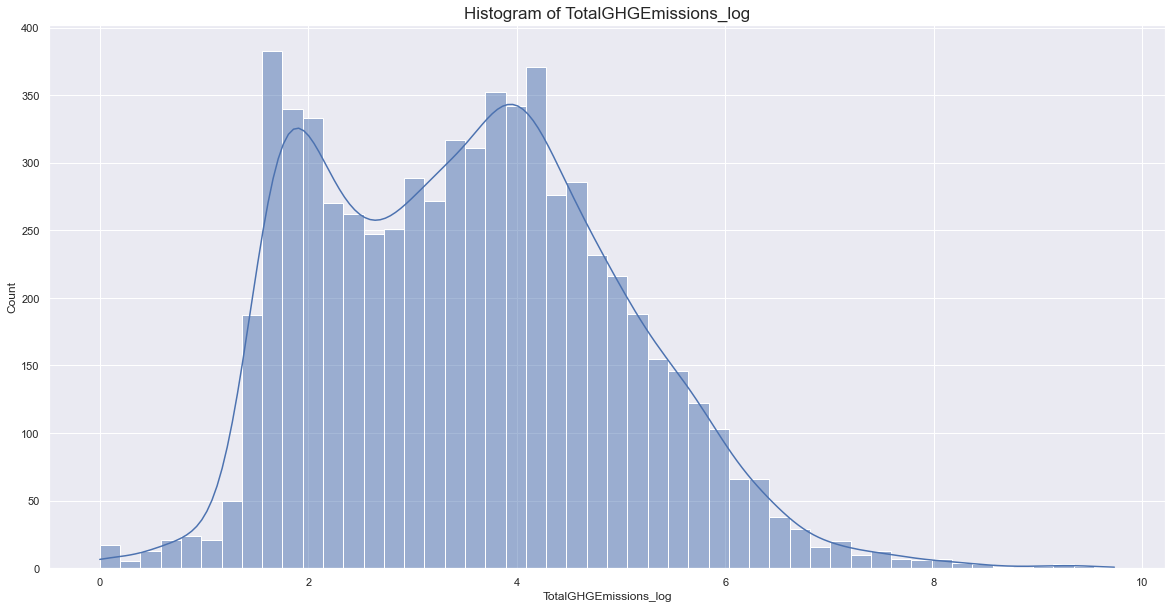

In [36]:
plt.figure(figsize = (20,10))
plt.title('Histogram of TotalGHGEmissions_log', size = 17)
plt.xlabel('TotalGHGEmissions_log', size = 12)
sns.histplot(df['TotalGHGEmissions_log'], bins = 50, kde = True)

In [37]:
normality(df, ['TotalGHGEmissions_log'], 0.05)

Shapiro-Wilk test :
TotalGHGEmissions_log----------------------------- "Does not look Gaussian"
Statistics =  0.982532799243927 p =  6.099533763741095e-28


Agostino test :
TotalGHGEmissions_log----------------------------- "Does not look Gaussian"
Statistics =  144.6898385992893 p =  3.810664853572329e-32


C:\Users\melme\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [38]:
df.reset_index(inplace = True, drop = True)

The targets do not follow a normal distribution. A logarithmic transformation was applied to make them Gaussian.

# 6. Removal Of Residential Buildings <a class="anchor" id="chapter6"></a>

In this part, we will delete rows with residential buildings type.

In [39]:
df['BuildingType'].unique().tolist()

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Multifamily LR (1-4)',
 'Campus',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [40]:
index_r = df[(df['BuildingType'] == 'Multifamily HR (10+)') |
             (df['BuildingType'] == 'Multifamily MR (5-9)') |
             (df['BuildingType'] == 'Multifamily LR (1-4)')].index

In [41]:
df.drop(index_r, inplace = True)

In [42]:
df.drop(columns = ['BuildingType'], inplace = True)

In [43]:
df.reset_index(inplace = True, drop = True)

Dataset has  3308 rows and  47 columns
Number of non-null values by columns :
OSEBuildingID                      3308
DataYear                           3308
PrimaryPropertyType                3308
PropertyName                       3308
TaxParcelIdentificationNumber      3307
CouncilDistrictCode                3308
Neighborhood                       3308
YearBuilt                          3308
NumberofBuildings                  3308
NumberofFloors                     3300
PropertyGFATotal                   3308
PropertyGFAParking                 3308
PropertyGFABuilding(s)             3308
ListOfAllPropertyUseTypes          3247
LargestPropertyUseType             3239
LargestPropertyUseTypeGFA          3239
SecondLargestPropertyUseType       1666
SecondLargestPropertyUseTypeGFA    1666
ThirdLargestPropertyUseType         684
ThirdLargestPropertyUseTypeGFA      684
YearsENERGYSTARCertified            188
ENERGYSTARScore                    2210
SiteEUI(kBtu/sf)                   3307
Si

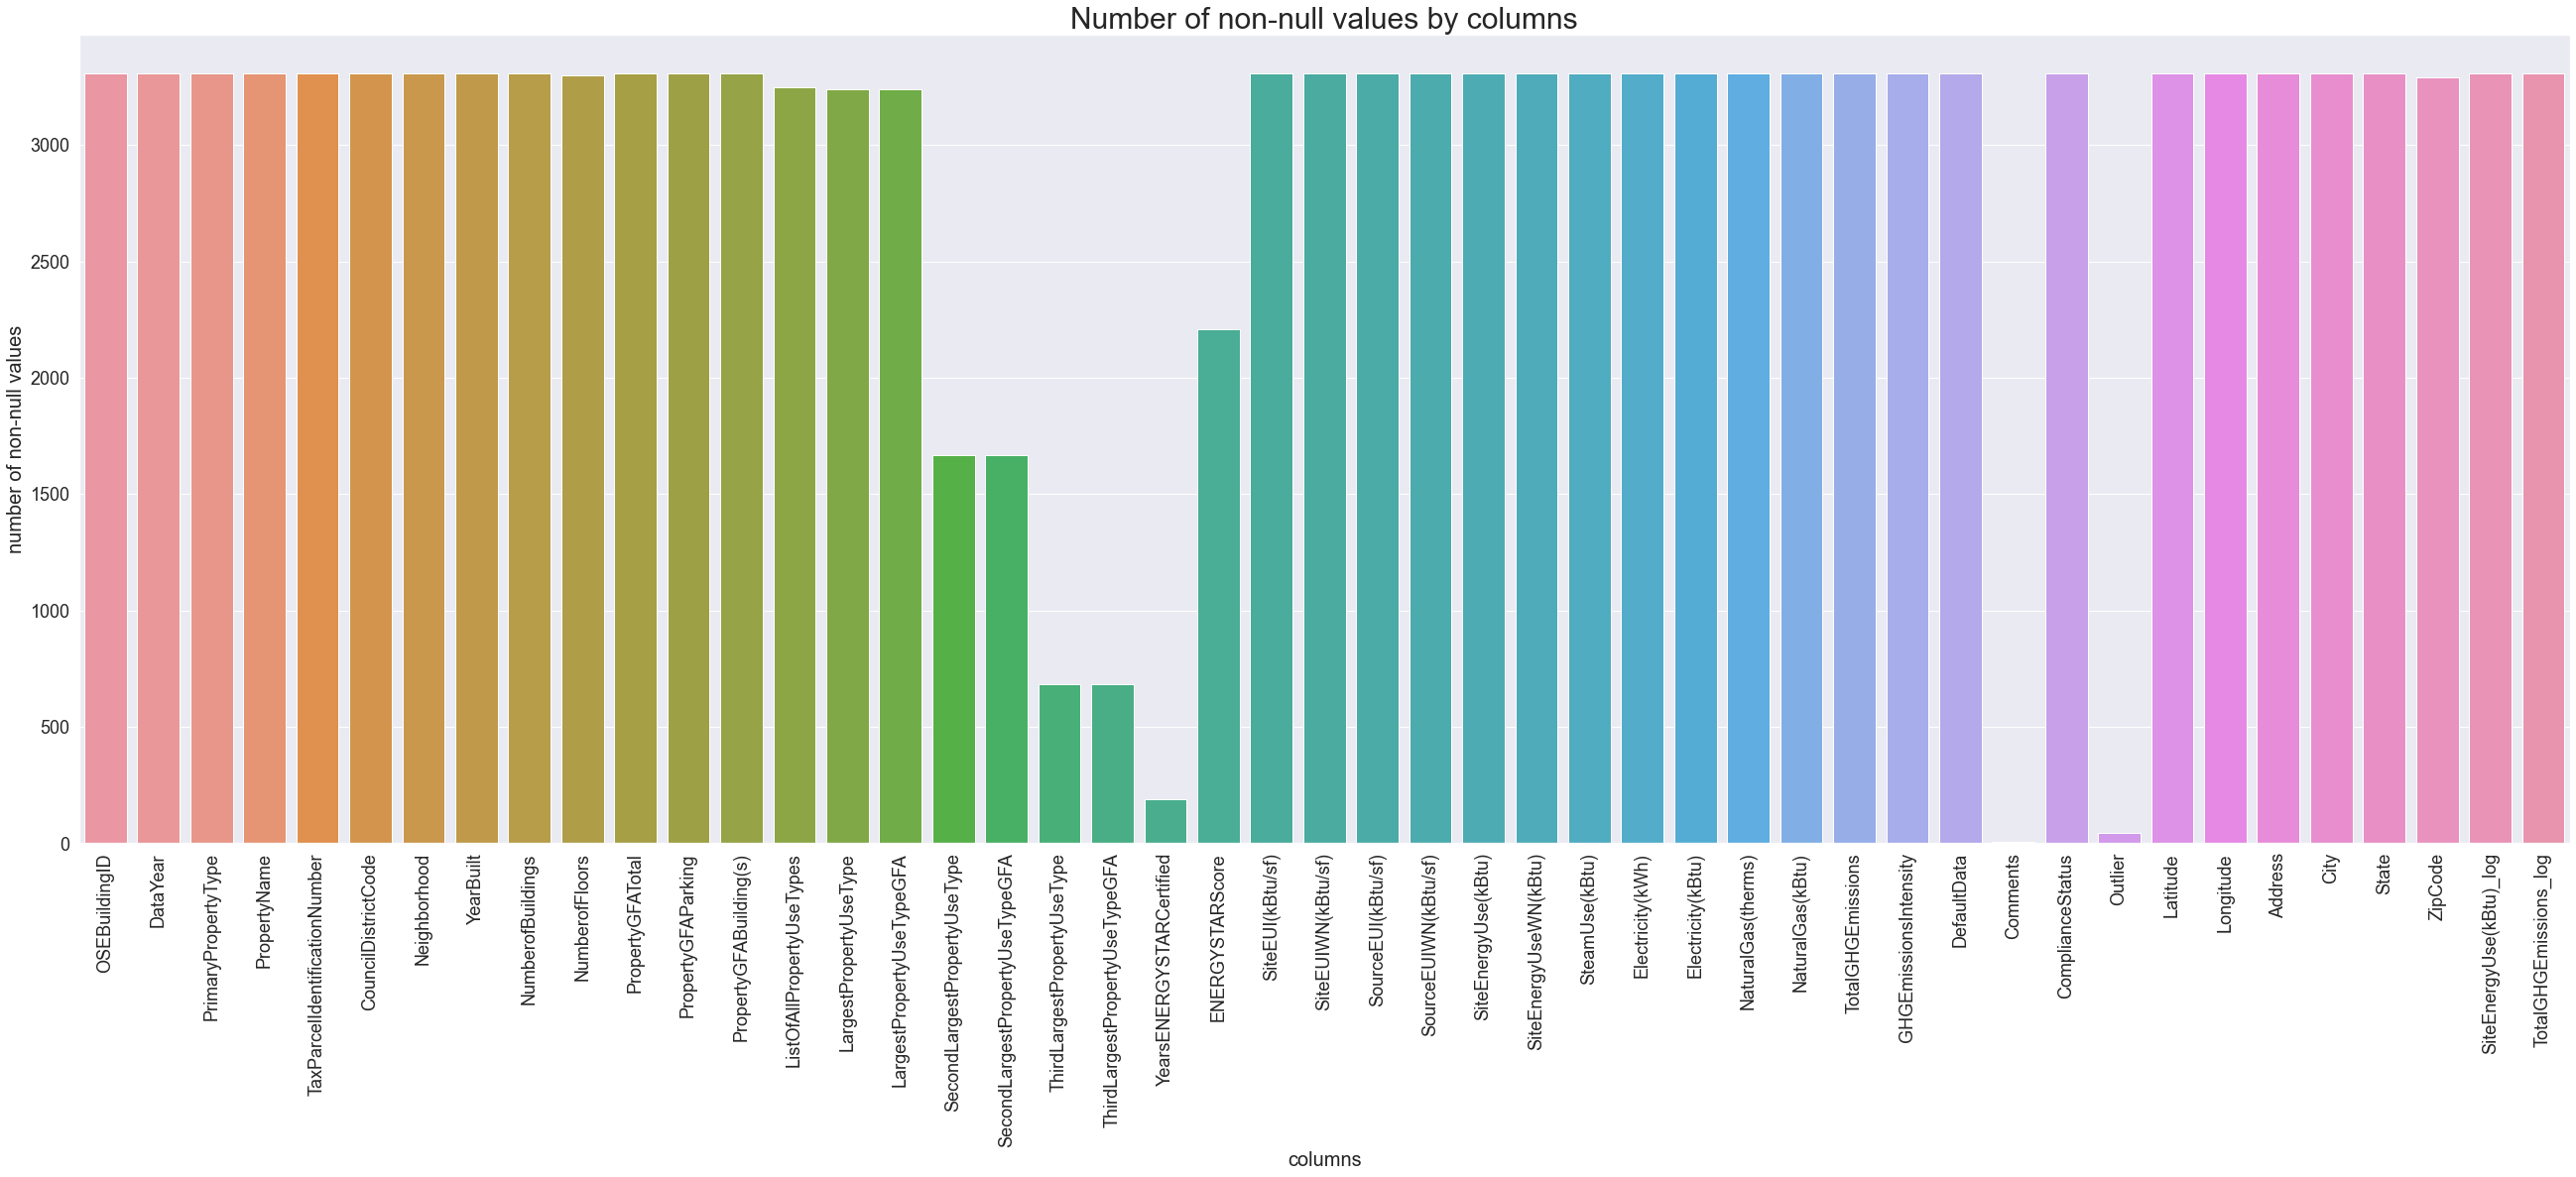

In [44]:
DataSetsExplo(df)

# 7. Changing Values in Columns <a class="anchor" id="chapter7"></a>

In this section, we will rectify some entries errors.

In [45]:
df['PrimaryPropertyType'].sort_values().unique().tolist()

['College/University',
 'Distribution Center',
 'Distribution Center\n',
 'Hospital',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Large Office',
 'Low-Rise Multifamily',
 'Medical Office',
 'Mixed Use Property',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Residence Hall/Dormitory',
 'Restaurant',
 'Restaurant\n',
 'Retail Store',
 'SPS-District K-12',
 'Self-Storage Facility',
 'Self-Storage Facility\n',
 'Senior Care Community',
 'Small- and Mid-Sized Office',
 'Supermarket / Grocery Store',
 'Supermarket/Grocery Store',
 'University',
 'Warehouse',
 'Worship Facility']

In [46]:
df['LargestPropertyUseType'].sort_values().unique().tolist()

['Adult Education',
 'Automobile Dealership',
 'Bank Branch',
 'College/University',
 'Convention Center',
 'Courthouse',
 'Data Center',
 'Distribution Center',
 'Financial Office',
 'Fire Station',
 'Fitness Center/Health Club/Gym',
 'Food Service',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Library',
 'Lifestyle Center',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Movie Theater',
 'Multifamily Housing',
 'Museum',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Lodging/Residential',
 'Other - Mall',
 'Other - Public Services',
 'Other - Recreation',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Other - Utility',
 'Other/Specialty Hospital',
 'Outpatient Rehabilitation/Physical Therapy',
 'Parking',
 'Performing Arts',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Police Station',
 'Pre-school/Daycare',
 'Prison/Incarceration',
 'Refrige

In [47]:
df['SecondLargestPropertyUseType'].sort_values().unique().tolist()

['Adult Education',
 'Automobile Dealership',
 'Bank Branch',
 'Bar/Nightclub',
 'College/University',
 'Convenience Store without Gas Station',
 'Courthouse',
 'Data Center',
 'Distribution Center',
 'Enclosed Mall',
 'Financial Office',
 'Fitness Center/Health Club/Gym',
 'Food Sales',
 'Food Service',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Movie Theater',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Lodging/Residential',
 'Other - Public Services',
 'Other - Recreation',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Parking',
 'Performing Arts',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Pre-school/Daycare',
 'Refrigerated Warehouse',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Residence Hall/Dormitory',
 'Restaurant',
 'Retail Store',
 'Self-Storage F

In [48]:
df['ThirdLargestPropertyUseType'].sort_values().unique().tolist()

['Bank Branch',
 'Bar/Nightclub',
 'Convenience Store without Gas Station',
 'Data Center',
 'Distribution Center',
 'Enclosed Mall',
 'Fast Food Restaurant',
 'Financial Office',
 'Fitness Center/Health Club/Gym',
 'Food Service',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Recreation',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Other - Technology/Science',
 'Other - Utility',
 'Other/Specialty Hospital',
 'Parking',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Pre-school/Daycare',
 'Refrigerated Warehouse',
 'Restaurant',
 'Retail Store',
 'Self-Storage Facility',
 'Social/Meeting Hall',
 'Strip Mall',
 'Supermarket/Grocery Store',
 'Swimming Pool',
 'Vocational School',
 'Worship Facility',
 nan]

In [49]:
df['Neighborhood'].sort_values().unique().tolist()

['BALLARD',
 'Ballard',
 'CENTRAL',
 'Central',
 'DELRIDGE',
 'DELRIDGE NEIGHBORHOODS',
 'DOWNTOWN',
 'Delridge',
 'EAST',
 'GREATER DUWAMISH',
 'LAKE UNION',
 'MAGNOLIA / QUEEN ANNE',
 'NORTH',
 'NORTHEAST',
 'NORTHWEST',
 'North',
 'Northwest',
 'SOUTHEAST',
 'SOUTHWEST']

In [50]:
df['PrimaryPropertyType'] = df['PrimaryPropertyType'].replace(['Distribution Center\n', 'Restaurant\n', 'Self-Storage Facility\n', 'Supermarket/Grocery Store'], ['Distribution Center', 'Restaurant', 'Self-Storage Facility', 'Supermarket / Grocery Store'])
df['Neighborhood'] = df['Neighborhood'].replace(['Ballard', 'Central', 'Delridge', 'North', 'DELRIDGE NEIGHBORHOODS', 'Northwest'], ['BALLARD', 'CENTRAL', 'DELRIDGE', 'NORTH', 'DELRIDGE', 'NORTHWEST'])

# 8. NaN Imputation in SecondLargestPropertyUseType/GFA and ThirdLargestPropertyUseType/GFA <a class="anchor" id="chapter8"></a>

In this part, we will fill missing value for the columns 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA' and 'ThirdLargestPropertyUseTypeGFA'.

In [51]:
df[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']] = df[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].fillna('Does not exist')

In [52]:
df[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = df[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].fillna(0.)

Dataset has  3308 rows and  47 columns
Number of non-null values by columns :
OSEBuildingID                      3308
DataYear                           3308
PrimaryPropertyType                3308
PropertyName                       3308
TaxParcelIdentificationNumber      3307
CouncilDistrictCode                3308
Neighborhood                       3308
YearBuilt                          3308
NumberofBuildings                  3308
NumberofFloors                     3300
PropertyGFATotal                   3308
PropertyGFAParking                 3308
PropertyGFABuilding(s)             3308
ListOfAllPropertyUseTypes          3247
LargestPropertyUseType             3239
LargestPropertyUseTypeGFA          3239
SecondLargestPropertyUseType       3308
SecondLargestPropertyUseTypeGFA    3308
ThirdLargestPropertyUseType        3308
ThirdLargestPropertyUseTypeGFA     3308
YearsENERGYSTARCertified            188
ENERGYSTARScore                    2210
SiteEUI(kBtu/sf)                   3307
Si

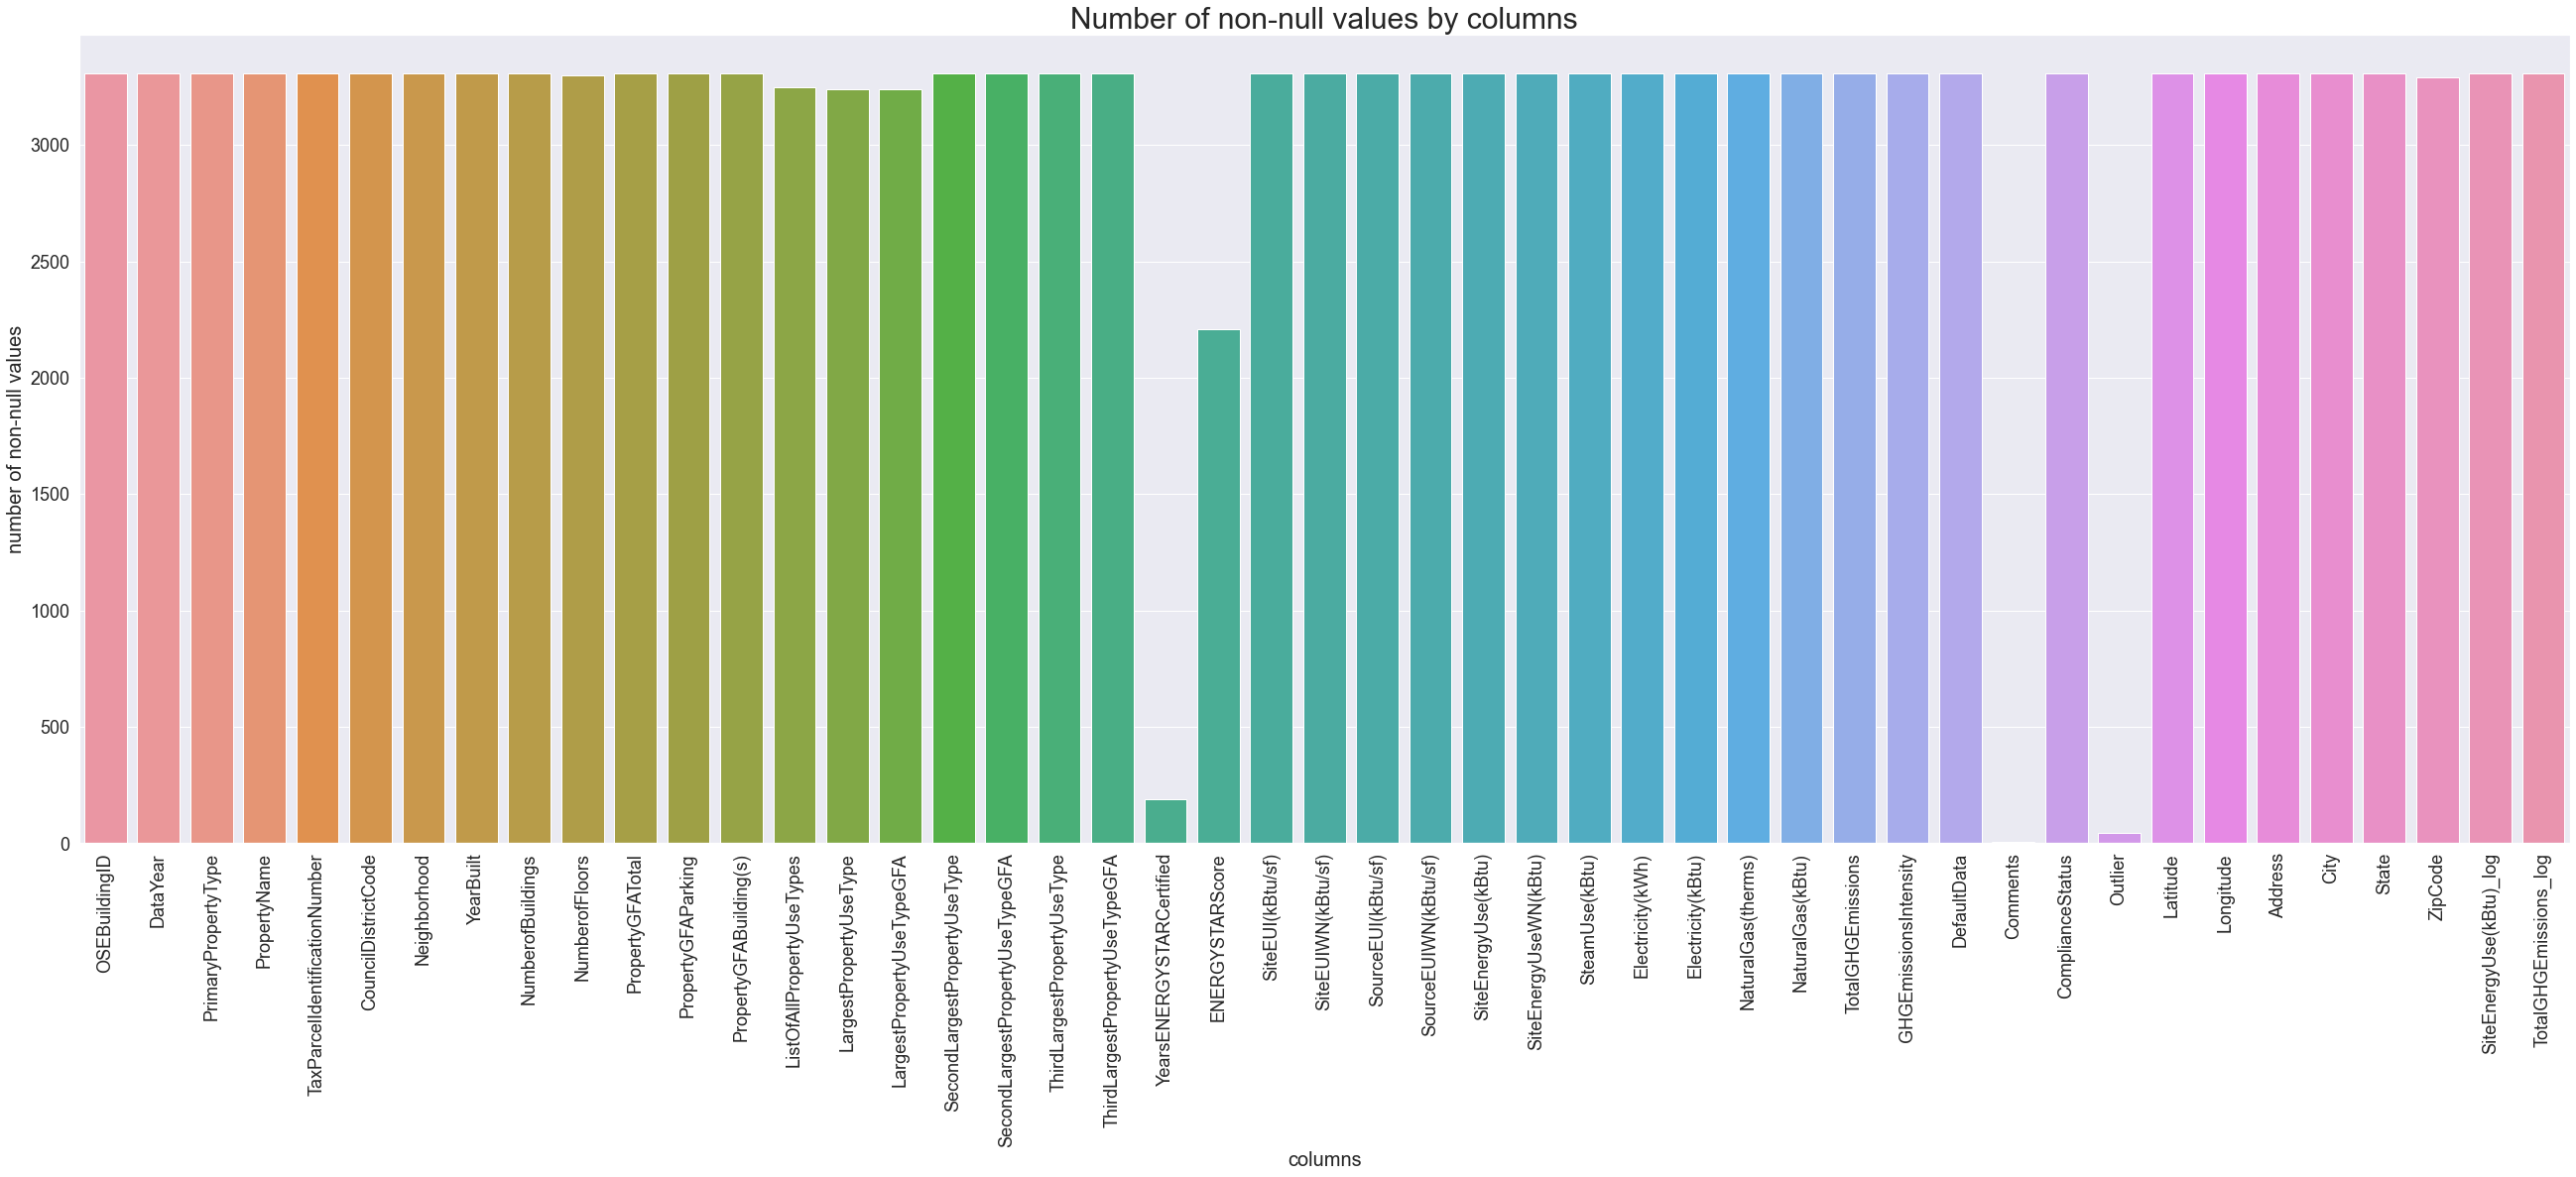

In [53]:
DataSetsExplo(df)

# 9. Columns Removal <a class="anchor" id="chapter9"></a>

In this part, we will remove the "useless" variables and the variables strongly correlated with an another.

In [54]:
columns_to_drop = ['OSEBuildingID',
                   'PropertyName',
                   'TaxParcelIdentificationNumber',
                   'YearsENERGYSTARCertified',
                   'DefaultData',
                   'Comments',
                   'Outlier',
                   'Address',
                   'City',
                   'State',
                   'ZipCode',
                   'CouncilDistrictCode']

In [55]:
df.drop(columns = columns_to_drop, inplace = True)

In [56]:
columns_1 = ['SiteEUI(kBtu/sf)',
             'SiteEUIWN(kBtu/sf)',
             'SourceEUI(kBtu/sf)',
             'SourceEUIWN(kBtu/sf)',
             'SiteEnergyUse(kBtu)',
             'SiteEnergyUseWN(kBtu)',
             'SteamUse(kBtu)',
             'Electricity(kWh)',
             'Electricity(kBtu)',
             'NaturalGas(therms)',
             'NaturalGas(kBtu)',
             'TotalGHGEmissions',
             'GHGEmissionsIntensity']

<AxesSubplot:title={'center':'Pearson correlation'}>

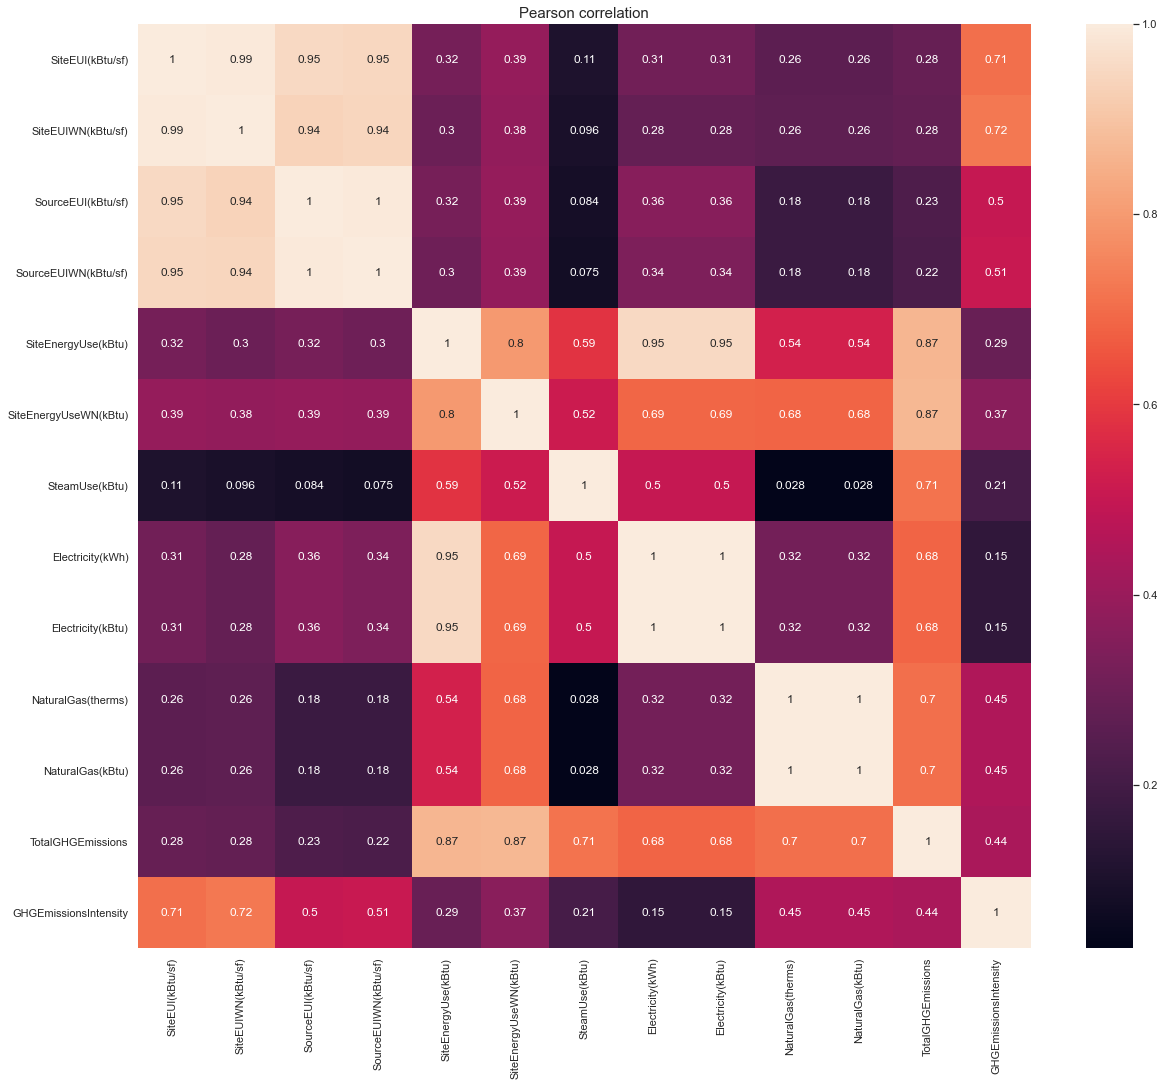

In [57]:
plt.figure(figsize = (20,17))
plt.title('Pearson correlation', size = 15)
sns.heatmap(df[columns_1].corr(method = 'pearson'), annot = True)

In [58]:
columns_to_drop = ['SiteEUIWN(kBtu/sf)',
                   'SourceEUI(kBtu/sf)',
                   'SourceEUIWN(kBtu/sf)',
                   'SiteEnergyUseWN(kBtu)',
                   'Electricity(kWh)',
                   'NaturalGas(therms)',
                   'SiteEUI(kBtu/sf)',
                   'GHGEmissionsIntensity']

In [59]:
df.drop(columns = columns_to_drop, inplace = True)

# 10. Feature Engineering <a class="anchor" id="chapter10"></a>

## 10.1. Latitude / Longitude <a class="anchor" id="section_10_1"></a>

In this part, we will try to see if we can extract information from the latitude and longitude.

In [60]:
df['Latitude'] = df['Latitude'].astype('float')
df['Longitude'] = df['Longitude'].astype('float')

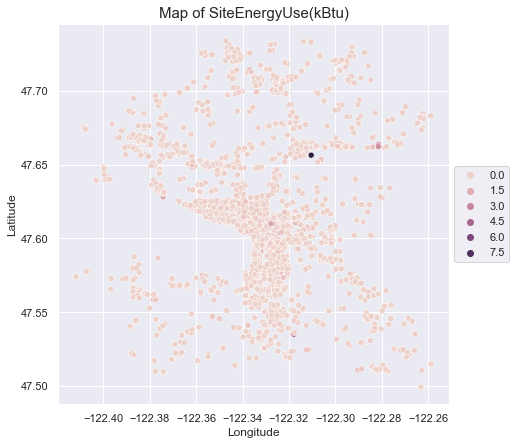

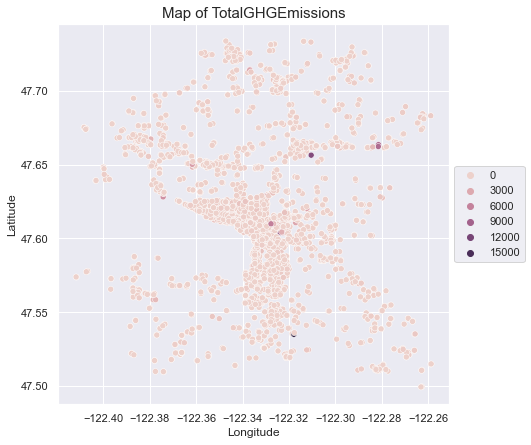

In [61]:
for col in ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']:
    fig, scatter = plt.subplots(figsize = (7,7))
    plt.title('Map of '+ col, size = 15)
    scatter = sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', hue = col)
    scatter.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

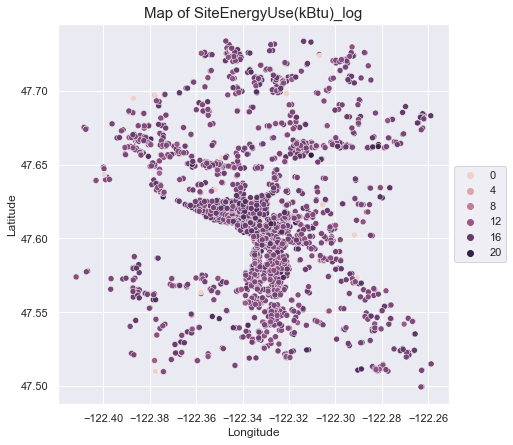

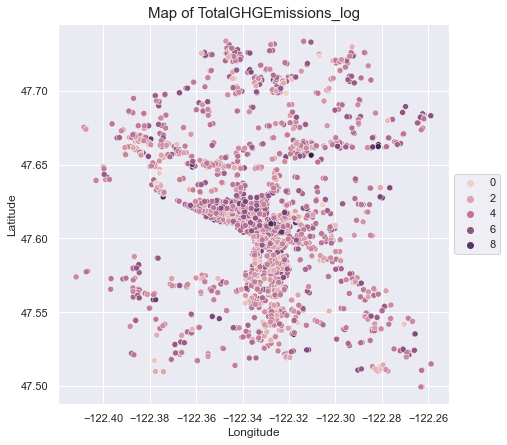

In [62]:
for col in ['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']:
    fig, scatter = plt.subplots(figsize = (7,7))
    plt.title('Map of '+ col, size = 15)
    scatter = sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', hue = col)
    scatter.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

In [63]:
df['geo_id'] = df.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution = 8), axis = 1)

In [64]:
id_unique = df['geo_id'].unique().tolist()
address_unique = []

In [65]:
for index in id_unique:
    index_center = h3.h3_to_geo(index)
    geolocator = Nominatim(user_agent = "MY")
    center_address = geolocator.reverse(index_center)
    address_unique.append([''.join(center_address[0].split(",")[:-5][:])])

In [66]:
for i,j in zip(id_unique, address_unique):
    df['geo_id'] = df['geo_id'].replace([i], [j])

In [67]:
df['geo_SEU_mean'] = df.groupby('geo_id')['SiteEnergyUse(kBtu)'].transform('mean')
df['geo_TGHGE_mean'] = df.groupby('geo_id')['TotalGHGEmissions'].transform('mean')

In [68]:
df_SEU = df[['geo_SEU_mean', 'geo_id']]
df_TGHGE = df[['geo_TGHGE_mean', 'geo_id']]

In [69]:
df_SEU = df_SEU.sort_values(by = 'geo_SEU_mean', ascending = False)
df_TGHGE = df_TGHGE.sort_values(by = 'geo_TGHGE_mean', ascending = False)

In [70]:
df_SEU.drop_duplicates(subset = ['geo_id'], keep = 'first', inplace = True)
df_TGHGE.drop_duplicates(subset = ['geo_id'], keep = 'first', inplace = True)

<AxesSubplot:title={'center':'SiteEnergyUse by location'}, xlabel='geo_id', ylabel='SiteEnergyUse'>

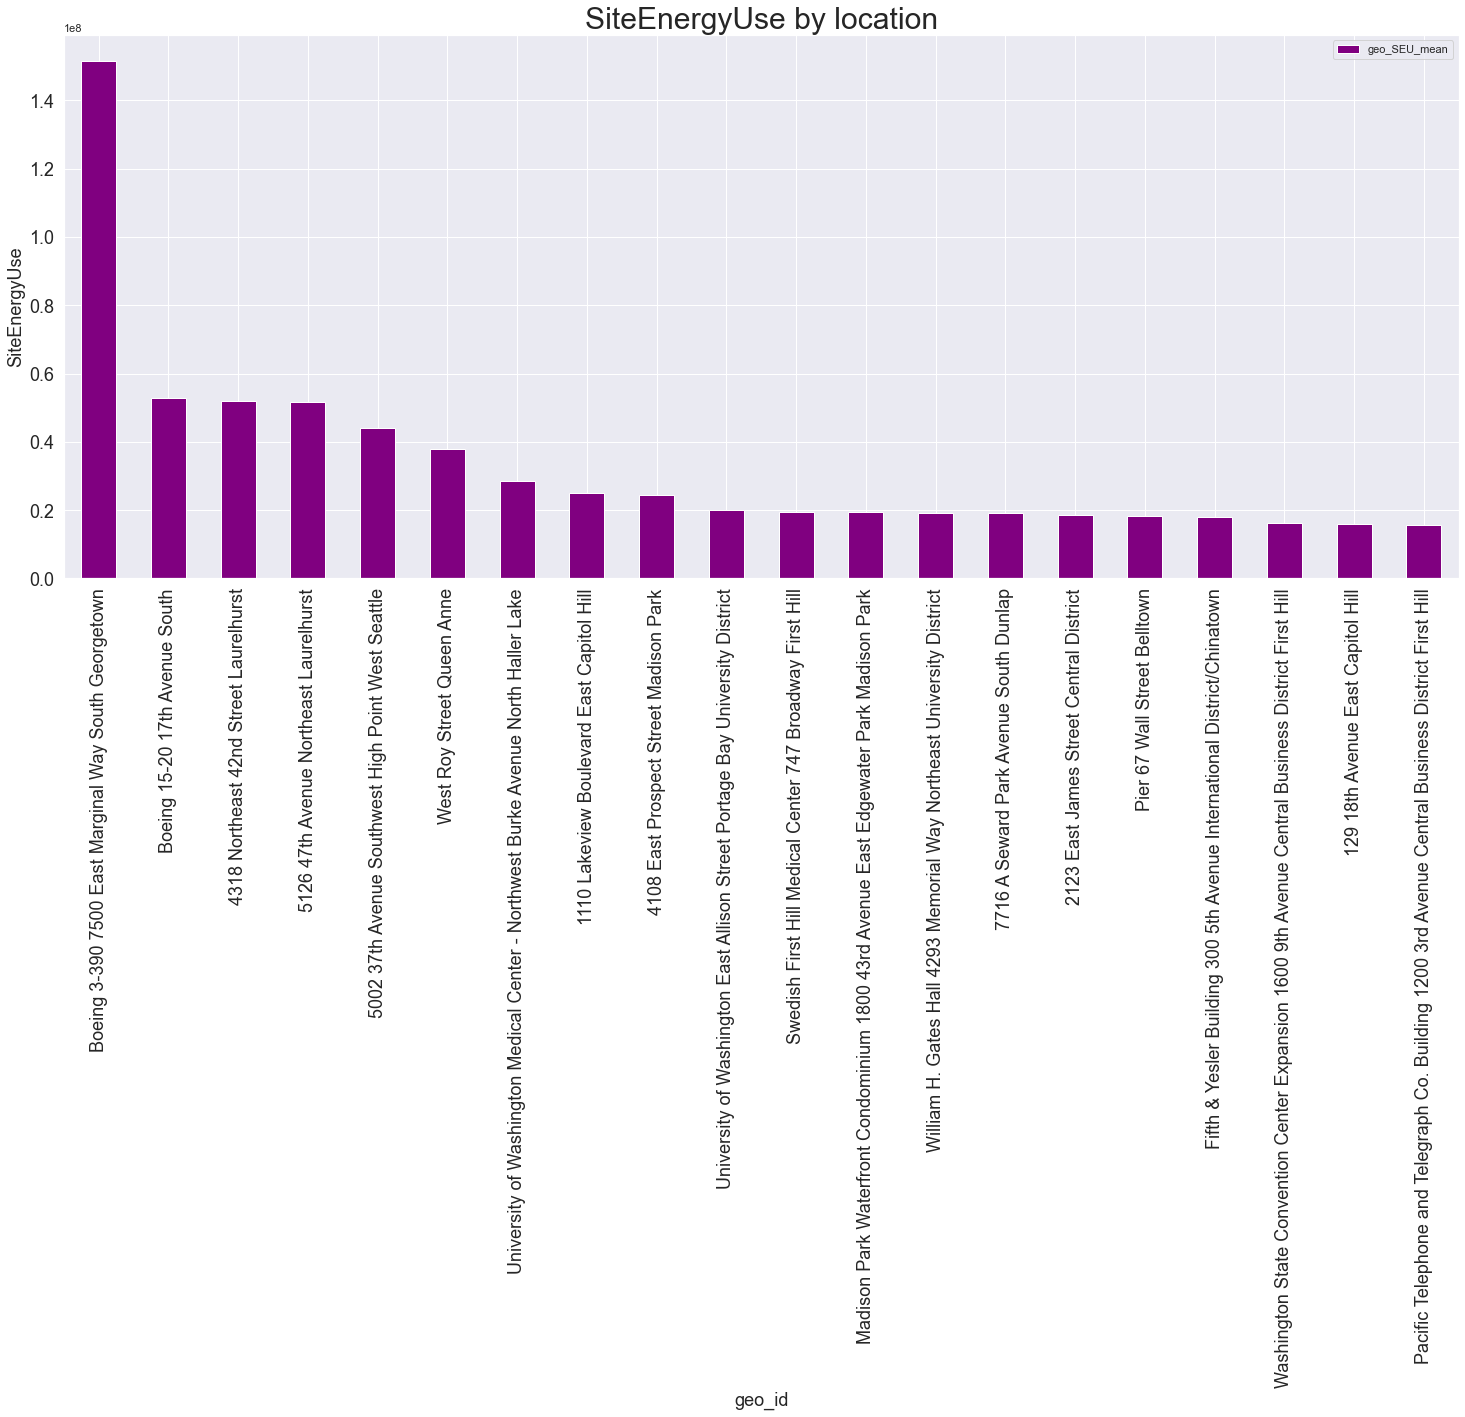

In [71]:
plt.figure()
plt.title('SiteEnergyUse by location', size = 30)
plt.xlabel('Location', size = 18)
plt.ylabel('SiteEnergyUse', size = 18)
df_SEU.set_index('geo_id')['geo_SEU_mean'][:20].plot(x = 'geo_id', kind = 'bar', figsize = (25,10), legend = True , color = 'purple', fontsize = 18)

<AxesSubplot:title={'center':'TotalGHGEmissions by location'}, xlabel='geo_id', ylabel='TotalGHGEmissions'>

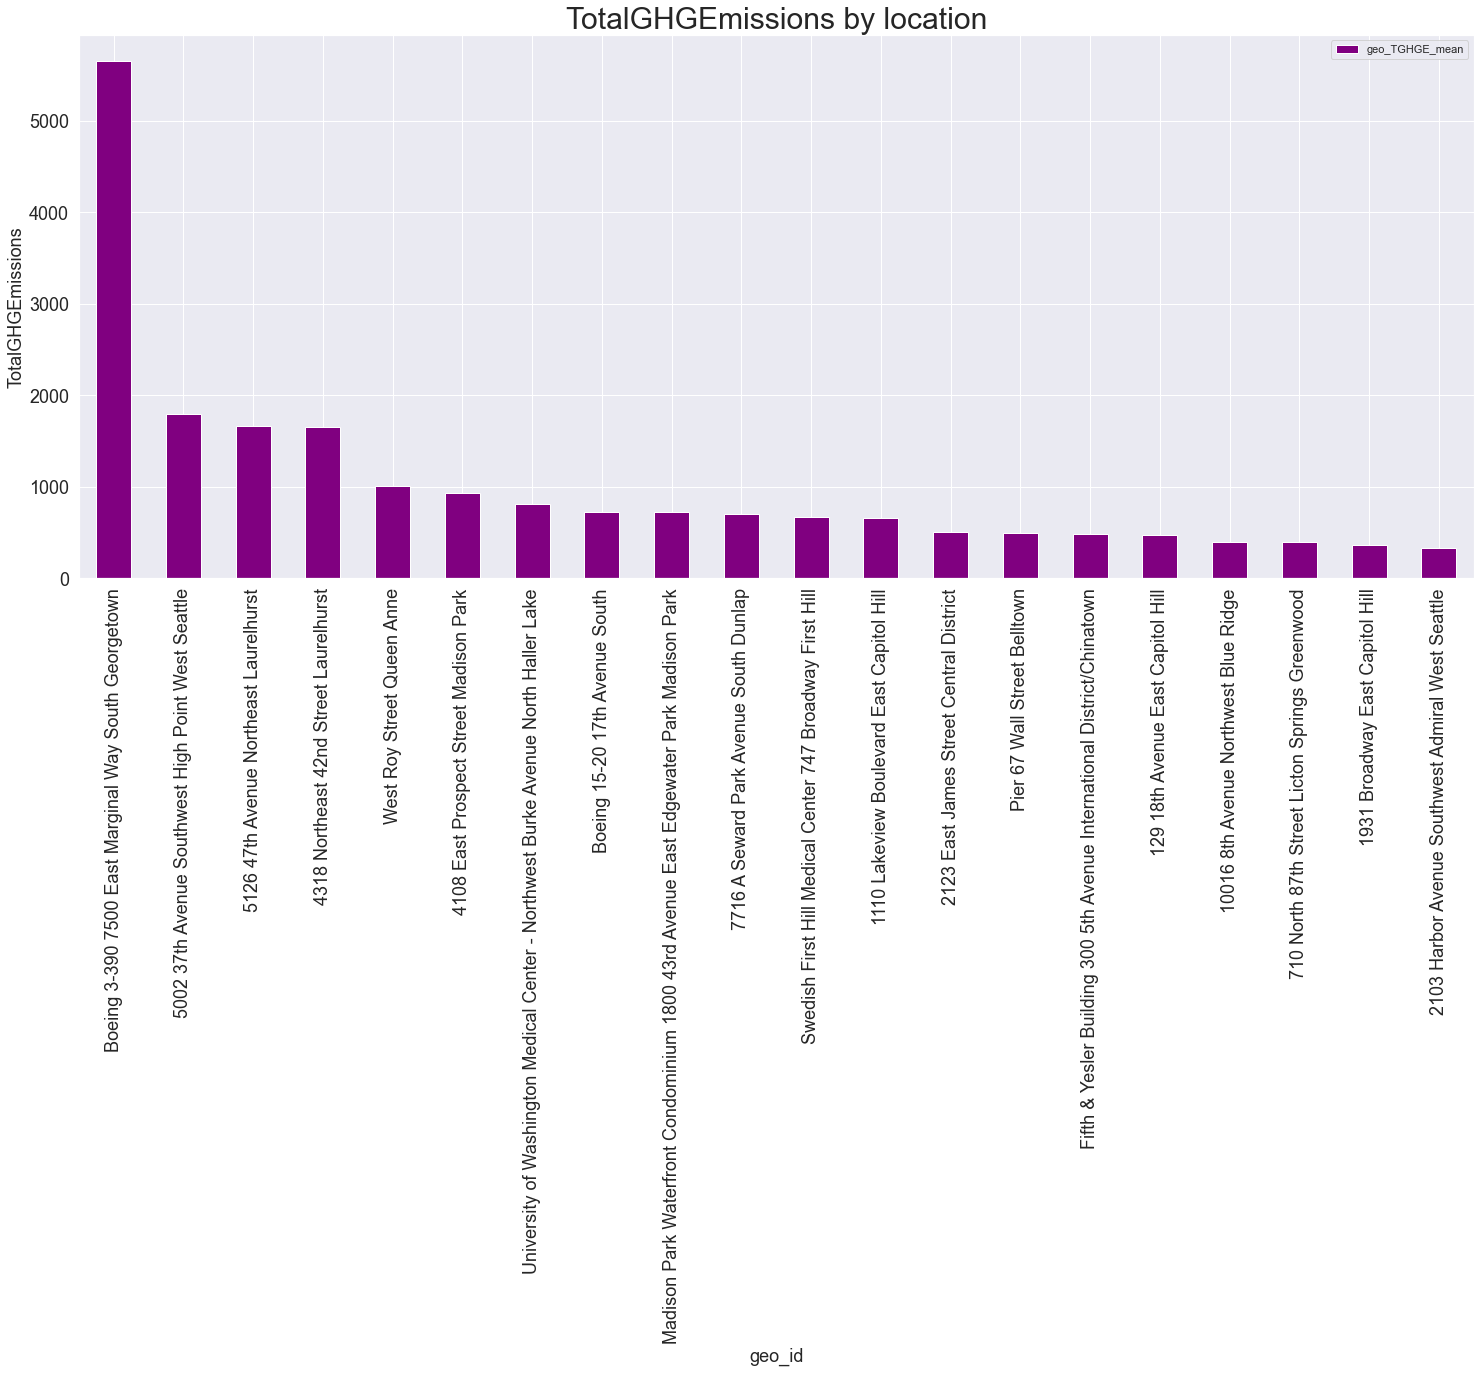

In [72]:
plt.figure()
plt.title('TotalGHGEmissions by location', size = 30)
plt.xlabel('Location', size = 18)
plt.ylabel('TotalGHGEmissions', size = 18)
df_TGHGE.set_index('geo_id')['geo_TGHGE_mean'][:20].plot(x = 'geo_id', kind = 'bar', figsize = (25,10), legend = True , color = 'purple', fontsize = 18)

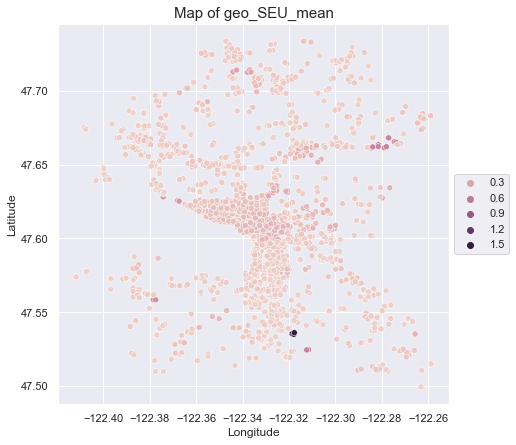

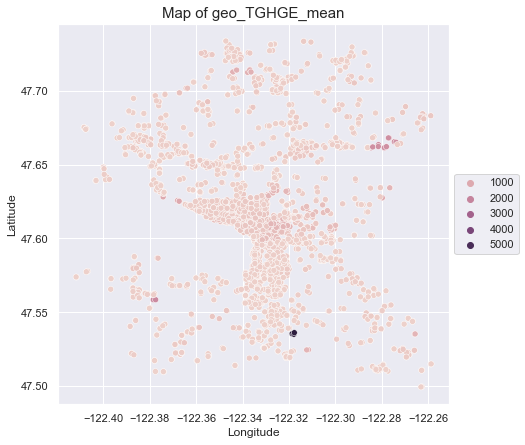

In [73]:
for col in ['geo_SEU_mean', 'geo_TGHGE_mean']:
    fig, scatter = plt.subplots(figsize = (7,7))
    plt.title('Map of '+ col, size = 15)
    scatter = sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', hue = col)
    scatter.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

It seems that we can't deduce something from latitude and longitude.

## 10.2. Neighborhood <a class="anchor" id="section_10_2"></a>

Instead, we will create variables who will contain the type of mean (very low, low, middle, high, very high) of each neighborhood for all targets.

In [74]:
df['neighborhood_SEU_mean'] = df.groupby('Neighborhood')['SiteEnergyUse(kBtu)'].transform('mean')
df['neighborhood_TGHGE_mean'] = df.groupby('Neighborhood')['TotalGHGEmissions'].transform('mean')

In [75]:
df_SEU = df[['neighborhood_SEU_mean', 'Neighborhood']]
df_TGHGE = df[['neighborhood_TGHGE_mean', 'Neighborhood']]

In [76]:
df_SEU = df_SEU.sort_values(by = 'neighborhood_SEU_mean', ascending = False)
df_TGHGE = df_TGHGE.sort_values(by = 'neighborhood_TGHGE_mean', ascending = False)

In [77]:
df_SEU.drop_duplicates(subset = ['Neighborhood'], keep = 'first', inplace = True)
df_TGHGE.drop_duplicates(subset = ['Neighborhood'], keep = 'first', inplace = True)

<AxesSubplot:title={'center':'Mean SiteEnergyUse by Neighborhood'}, xlabel='Neighborhood', ylabel='SiteEnergyUse'>

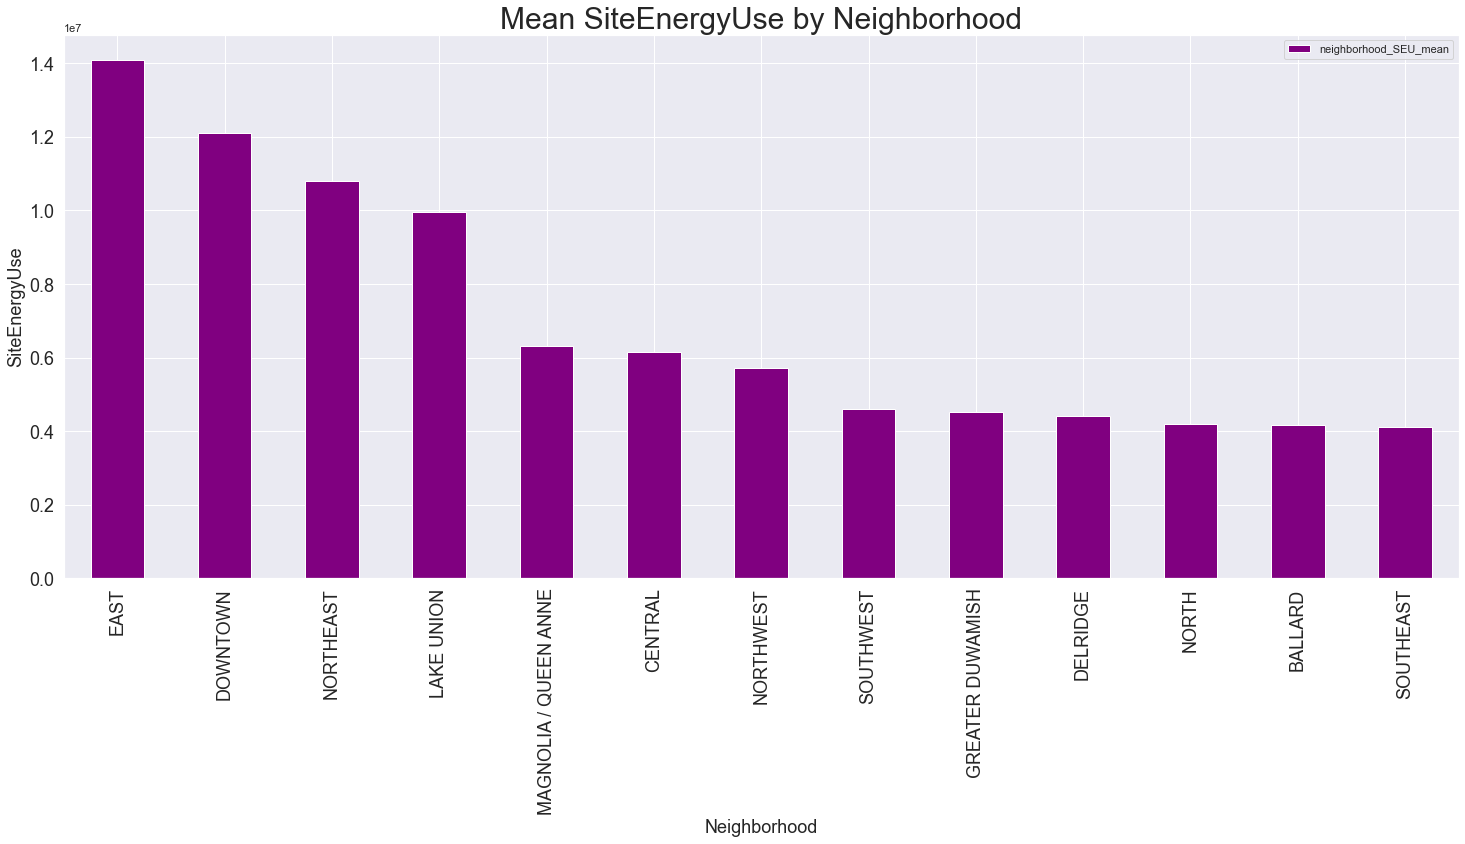

In [78]:
plt.figure()
plt.title('Mean SiteEnergyUse by Neighborhood', size = 30)
plt.xlabel('Neighborhood', size = 18)
plt.ylabel('SiteEnergyUse', size = 18)
df_SEU.set_index('Neighborhood')['neighborhood_SEU_mean'].plot(x = 'Neighborhood', kind = 'bar', figsize = (25,10), legend = True , color = 'purple', fontsize = 18)

<AxesSubplot:title={'center':'Mean TotalGHGEmissions by Neighborhood'}, xlabel='Neighborhood', ylabel='TotalGHGEmissions'>

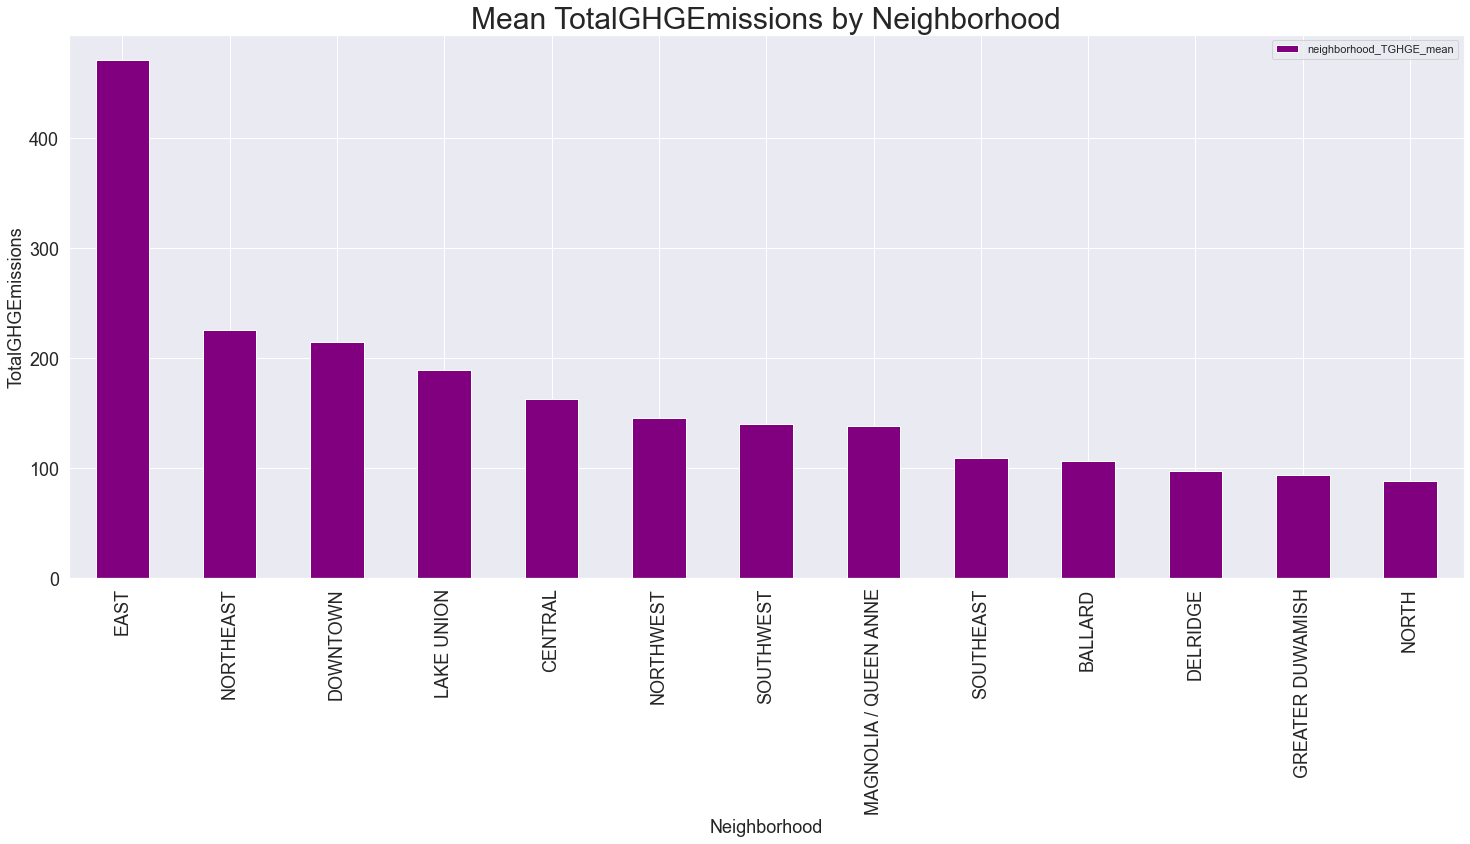

In [79]:
plt.figure()
plt.title('Mean TotalGHGEmissions by Neighborhood', size = 30)
plt.xlabel('Neighborhood', size = 18)
plt.ylabel('TotalGHGEmissions', size = 18)
df_TGHGE.set_index('Neighborhood')['neighborhood_TGHGE_mean'].plot(x = 'Neighborhood', kind = 'bar', figsize = (25,10), legend = True , color = 'purple', fontsize = 18)

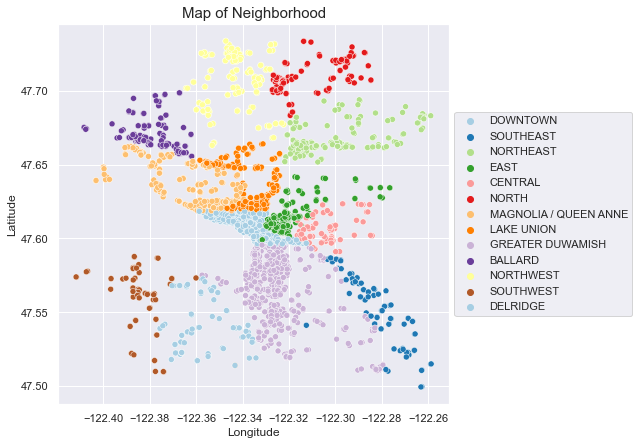

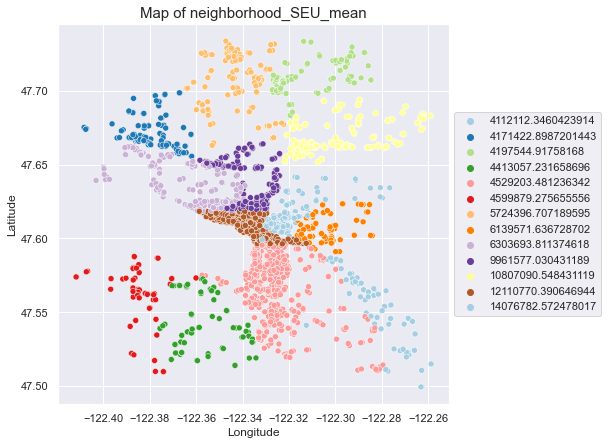

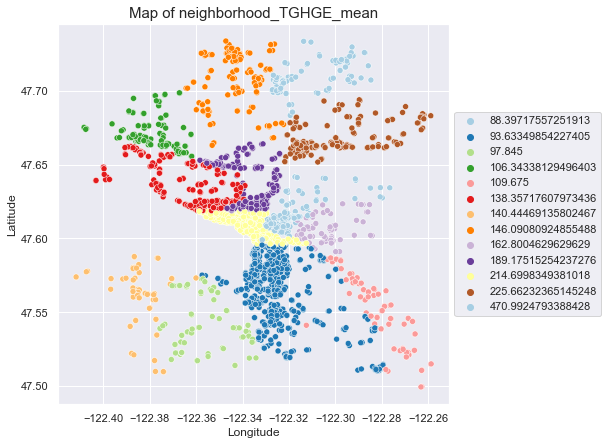

In [80]:
for col in ['Neighborhood', 'neighborhood_SEU_mean', 'neighborhood_TGHGE_mean']:
    fig, scatter = plt.subplots(figsize = (7,7))
    plt.title('Map of '+ col, size = 15)
    scatter = sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', hue = col, palette = 'Paired')
    scatter.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

In [81]:
df['Neighborhood_SEU_Type'] = 'Very_Low'
df.loc[df['Neighborhood'].isin(['EAST', 'DOWNTOWN']), 'Neighborhood_SEU_Type'] = 'Very_High'
df.loc[df['Neighborhood'].isin(['LAKE UNION']), 'Neighborhood_SEU_Type'] = 'High'
df.loc[df['Neighborhood'].isin(['NORTHEAST', 'CENTRAL']), 'Neighborhood_SEU_Type'] = 'Mid'
df.loc[df['Neighborhood'].isin(['NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'SOUTHWEST']), 'Neighborhood_SEU_Type'] = 'Low'

In [82]:
df['Neighborhood_TGHGE_Type'] = 'Low'
df.loc[df['Neighborhood'].isin(['EAST']), 'Neighborhood_TGHGE_Type'] = 'Very_High'
df.loc[df['Neighborhood'].isin(['DOWNTOWN', 'NORTHEAST']), 'Neighborhood_TGHGE_Type'] = 'High'
df.loc[df['Neighborhood'].isin(['CENTRAL', 'LAKE UNION', 'NORTHWEST', 'SOUTHWEST']), 'Neighborhood_TGHGE_Type'] = 'Med'
df.loc[df['Neighborhood'].isin(['GREATER DUWAMISH']), 'Neighborhood_TGHGE_Type'] = 'Very_Low'

## 10.3. Age <a class="anchor" id="section_10_3"></a>

Creation of a variable "Age".

In [83]:
df['Age'] = df['DataYear'] - df['YearBuilt']

## 10.4. ListOfAllPropertyUseTypes <a class="anchor" id="section_10_4"></a>

Creation of a variable containing the number of ‘all use type’ for each property.

In [84]:
df['nb_of_PropertyUseTypes'] = 0

In [85]:
for i in range(df.shape[0]):
    if type(df['ListOfAllPropertyUseTypes'][i]) == str:
        df['nb_of_PropertyUseTypes'][i] = len(df['ListOfAllPropertyUseTypes'][i].split(','))
    else:
        df['nb_of_PropertyUseTypes'][i] = np.nan

<ipython-input-85-626d2632b7cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nb_of_PropertyUseTypes'][i] = len(df['ListOfAllPropertyUseTypes'][i].split(','))
<ipython-input-85-626d2632b7cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nb_of_PropertyUseTypes'][i] = np.nan
C:\Users\melme\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexe

## 10.5. LargestPropertyUseTypeGFA / SecondLargestPropertyUseTypeGFA / ThirdLargestPropertyUseTypeGFA <a class="anchor" id="section_10_5"></a>

Creation of variables containing the proportion of the area of the main, secondary and tertiary property.

In [86]:
df['LargestPropertyUseTypeRatio'] = df['LargestPropertyUseTypeGFA'] / (df['LargestPropertyUseTypeGFA'] + df['SecondLargestPropertyUseTypeGFA'] + df['ThirdLargestPropertyUseTypeGFA'])
df['SecondLargestPropertyUseTypeRatio'] = df['SecondLargestPropertyUseTypeGFA'] / (df['LargestPropertyUseTypeGFA'] + df['SecondLargestPropertyUseTypeGFA'] + df['ThirdLargestPropertyUseTypeGFA'])
df['ThirdLargestPropertyUseTypeRatio'] = df['ThirdLargestPropertyUseTypeGFA'] / (df['LargestPropertyUseTypeGFA'] + df['SecondLargestPropertyUseTypeGFA'] + df['ThirdLargestPropertyUseTypeGFA'])

## 10.6. SteamUse / Electricity / NaturalGas / SiteEnergyUse <a class="anchor" id="section_10_6"></a>

Creation of variables containing the proportion of the energies used over the total energy consumption.

In [87]:
df['SteamUse_Ratio'] = df['SteamUse(kBtu)'] / df['SiteEnergyUse(kBtu)']
df['Electricity_Ratio'] = df['Electricity(kBtu)'] / df['SiteEnergyUse(kBtu)']
df['NaturalGas_Ratio'] = df['NaturalGas(kBtu)'] / df['SiteEnergyUse(kBtu)']

In [88]:
(df['SteamUse_Ratio'] + df['Electricity_Ratio'] + df['NaturalGas_Ratio']).sort_values(ascending = False)[:20]

851     1.314228
915     1.284968
2998    1.237346
2196    1.214379
551     1.116972
1843    1.012978
1119    1.000087
1022    1.000056
1284    1.000046
871     1.000046
817     1.000044
990     1.000043
1362    1.000043
1149    1.000043
1208    1.000043
1616    1.000043
823     1.000043
1271    1.000043
586     1.000043
1155    1.000043
dtype: float64

In [89]:
df.drop(index = [842, 2956, 2166, 544, 1816], inplace = True)

In [90]:
df.reset_index(inplace = True, drop = True)

# 11. Cleaning <a class="anchor" id="chapter11"></a>

## 11.1. Columns Drop <a class="anchor" id="section_11_1"></a>

Removal of unnecessary variables following the new created variables.

Dataset has  3303 rows and  42 columns
Number of non-null values by columns :
DataYear                             3303
PrimaryPropertyType                  3303
Neighborhood                         3303
YearBuilt                            3303
NumberofBuildings                    3303
NumberofFloors                       3295
PropertyGFATotal                     3303
PropertyGFAParking                   3303
PropertyGFABuilding(s)               3303
ListOfAllPropertyUseTypes            3242
LargestPropertyUseType               3234
LargestPropertyUseTypeGFA            3234
SecondLargestPropertyUseType         3303
SecondLargestPropertyUseTypeGFA      3303
ThirdLargestPropertyUseType          3303
ThirdLargestPropertyUseTypeGFA       3303
ENERGYSTARScore                      2205
SiteEnergyUse(kBtu)                  3303
SteamUse(kBtu)                       3303
Electricity(kBtu)                    3303
NaturalGas(kBtu)                     3303
TotalGHGEmissions                    330

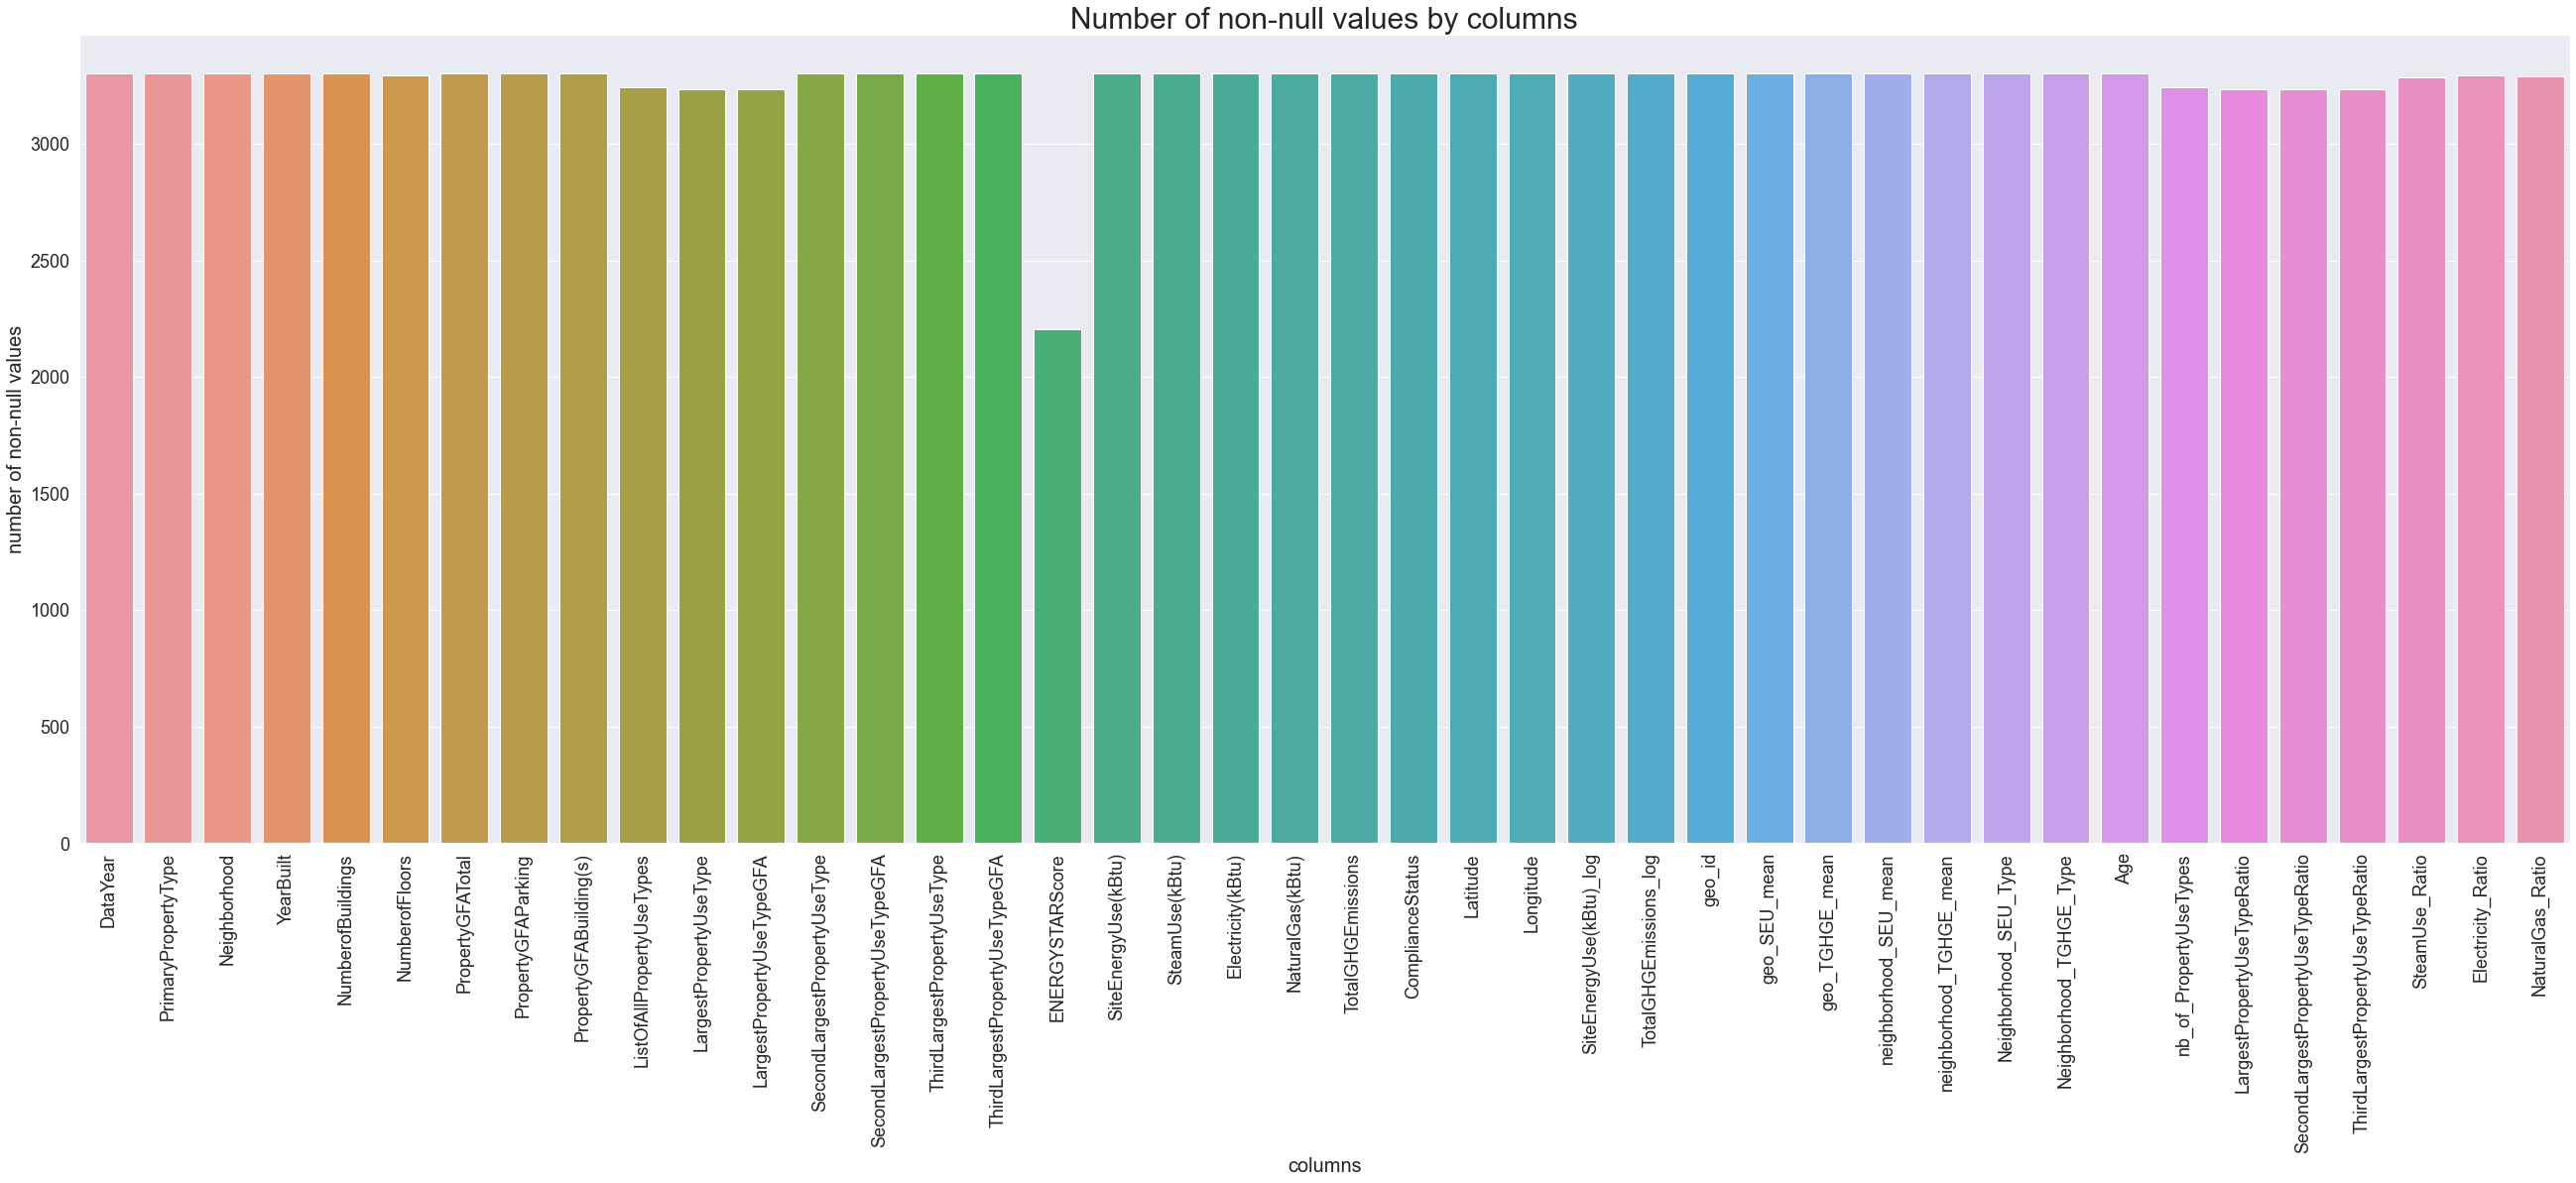

In [91]:
DataSetsExplo(df)

In [92]:
columns_to_drop = ['DataYear', 
                   'PrimaryPropertyType',
                   'Neighborhood',
                   'YearBuilt',
                   'PropertyGFATotal',
                   'SteamUse(kBtu)',
                   'Electricity(kBtu)',
                   'NaturalGas(kBtu)',
                   'Latitude', 
                   'Longitude',
                   'geo_id',
                   'geo_SEU_mean',
                   'geo_TGHGE_mean',
                   'neighborhood_SEU_mean',
                   'neighborhood_TGHGE_mean']

In [93]:
df.drop(columns = columns_to_drop, inplace = True)

## 11.2. NaN <a class="anchor" id="section_11_2"></a>

In this part, we will fill missing value for the columns 'NumberofFloors', 'ENERGYSTARScore.

In [94]:
df.dropna(subset = ['LargestPropertyUseType', 'SteamUse_Ratio'], inplace = True)

In [95]:
df.reset_index(inplace = True, drop = True)

Dataset has  3216 rows and  27 columns
Number of non-null values by columns :
NumberofBuildings                    3216
NumberofFloors                       3208
PropertyGFAParking                   3216
PropertyGFABuilding(s)               3216
ListOfAllPropertyUseTypes            3216
LargestPropertyUseType               3216
LargestPropertyUseTypeGFA            3216
SecondLargestPropertyUseType         3216
SecondLargestPropertyUseTypeGFA      3216
ThirdLargestPropertyUseType          3216
ThirdLargestPropertyUseTypeGFA       3216
ENERGYSTARScore                      2152
SiteEnergyUse(kBtu)                  3216
TotalGHGEmissions                    3216
ComplianceStatus                     3216
SiteEnergyUse(kBtu)_log              3216
TotalGHGEmissions_log                3216
Neighborhood_SEU_Type                3216
Neighborhood_TGHGE_Type              3216
Age                                  3216
nb_of_PropertyUseTypes               3216
LargestPropertyUseTypeRatio          321

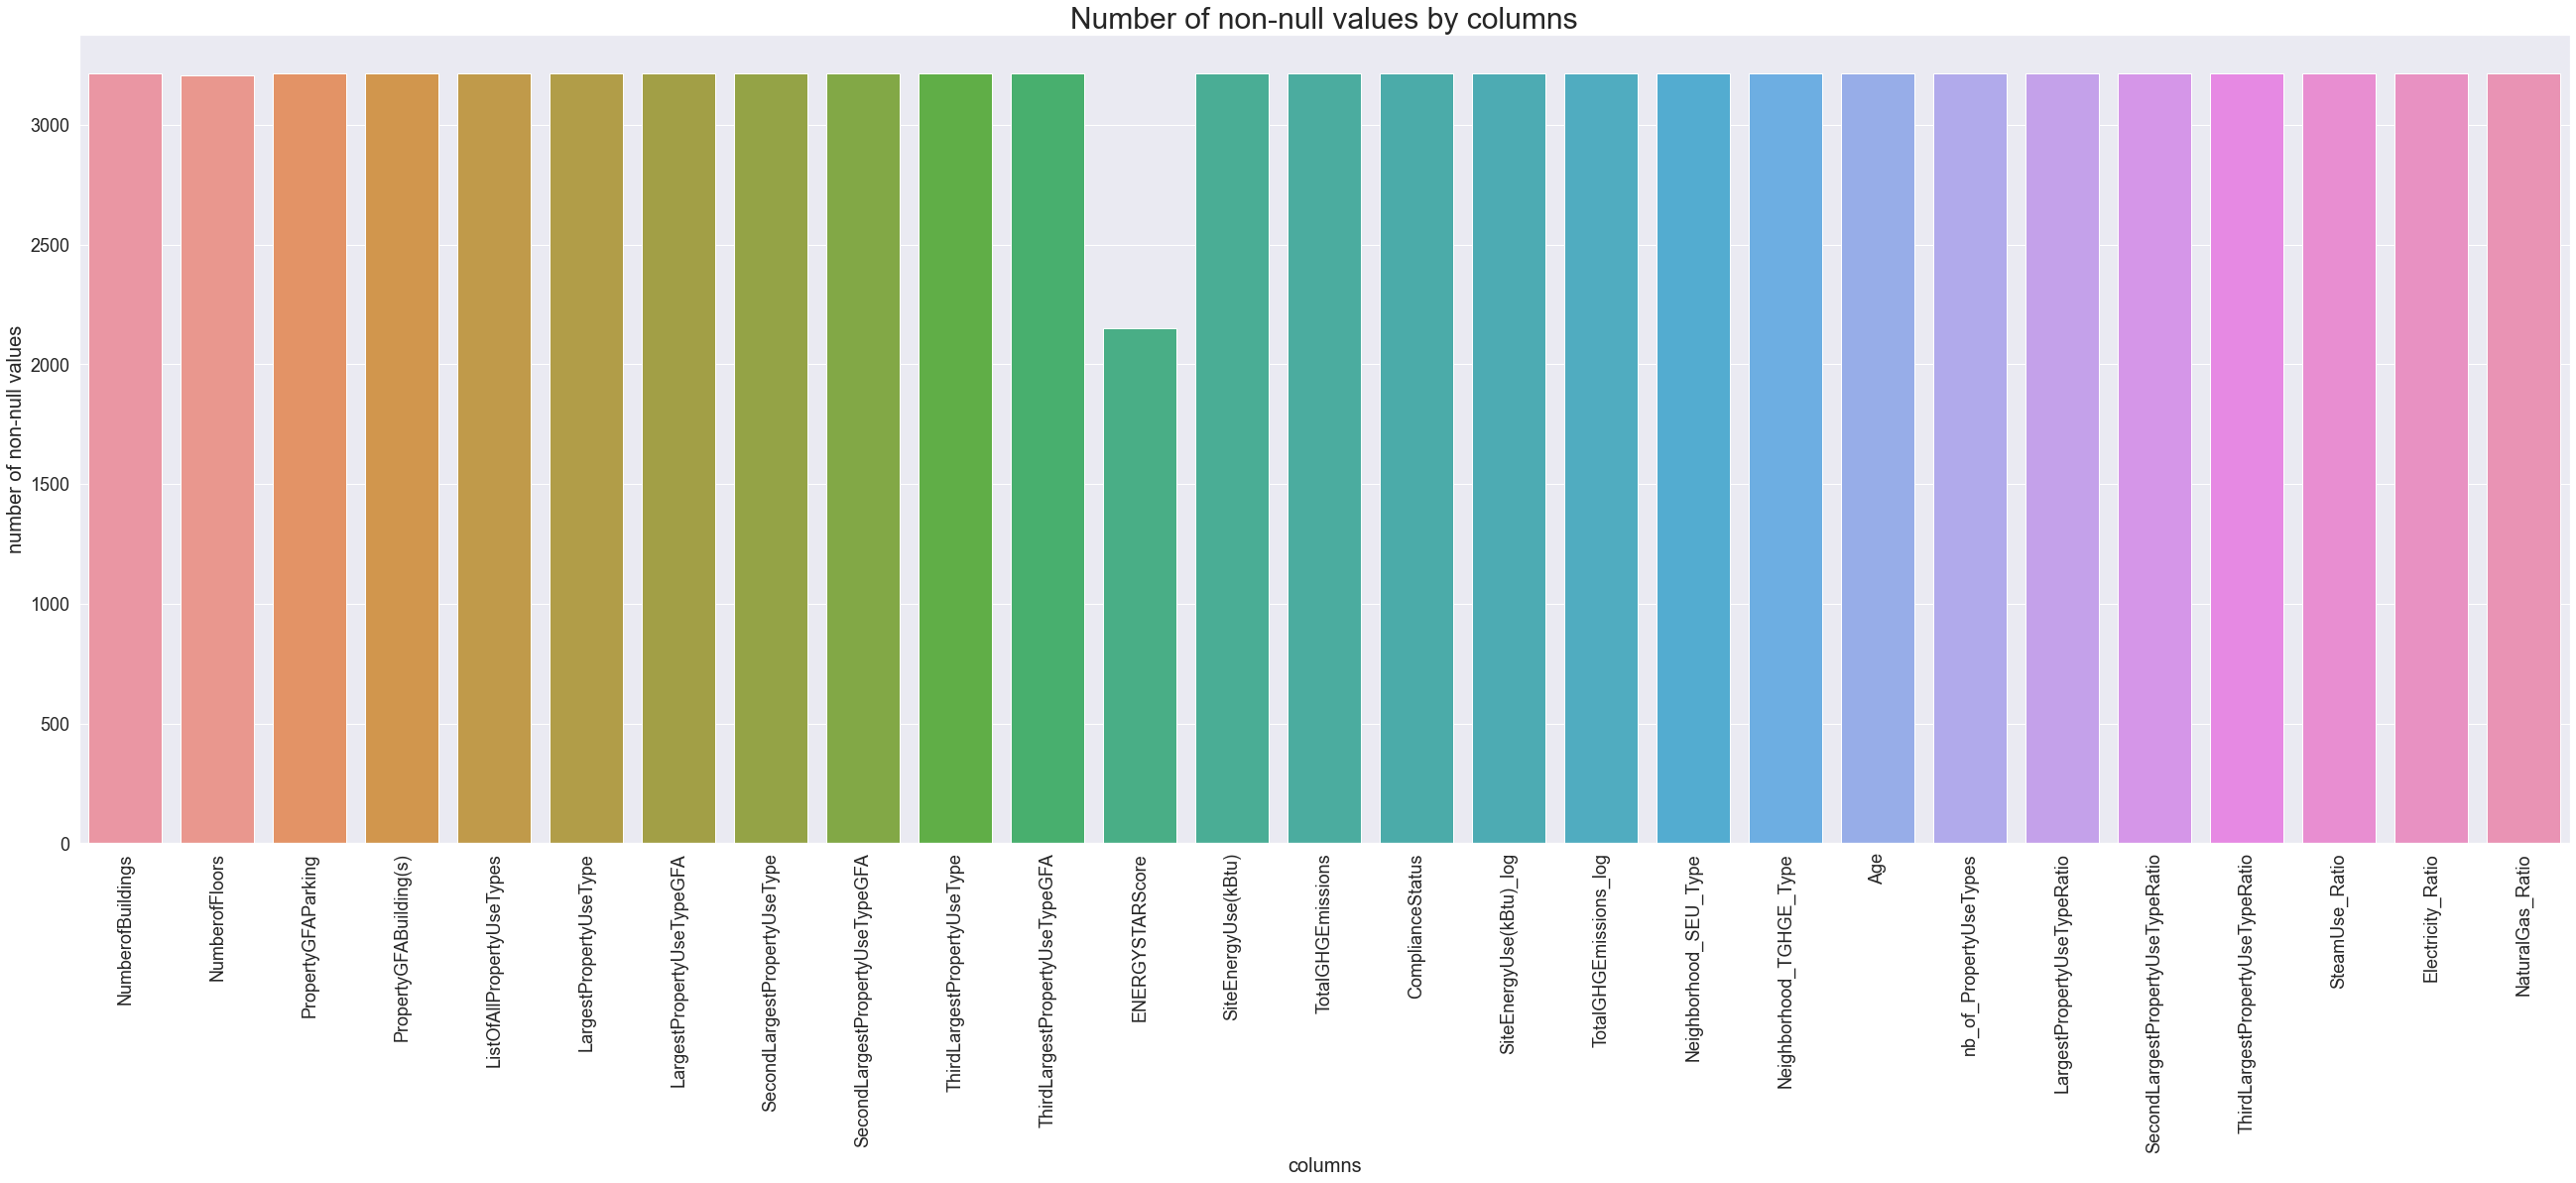

In [96]:
DataSetsExplo(df)

In [97]:
df['NumberofFloors'] = df['NumberofFloors'].fillna(df.groupby('LargestPropertyUseType')['NumberofFloors'].transform('mean'))

In [98]:
df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(0)

Dataset has  3216 rows and  27 columns
Number of non-null values by columns :
NumberofBuildings                    3216
NumberofFloors                       3216
PropertyGFAParking                   3216
PropertyGFABuilding(s)               3216
ListOfAllPropertyUseTypes            3216
LargestPropertyUseType               3216
LargestPropertyUseTypeGFA            3216
SecondLargestPropertyUseType         3216
SecondLargestPropertyUseTypeGFA      3216
ThirdLargestPropertyUseType          3216
ThirdLargestPropertyUseTypeGFA       3216
ENERGYSTARScore                      3216
SiteEnergyUse(kBtu)                  3216
TotalGHGEmissions                    3216
ComplianceStatus                     3216
SiteEnergyUse(kBtu)_log              3216
TotalGHGEmissions_log                3216
Neighborhood_SEU_Type                3216
Neighborhood_TGHGE_Type              3216
Age                                  3216
nb_of_PropertyUseTypes               3216
LargestPropertyUseTypeRatio          321

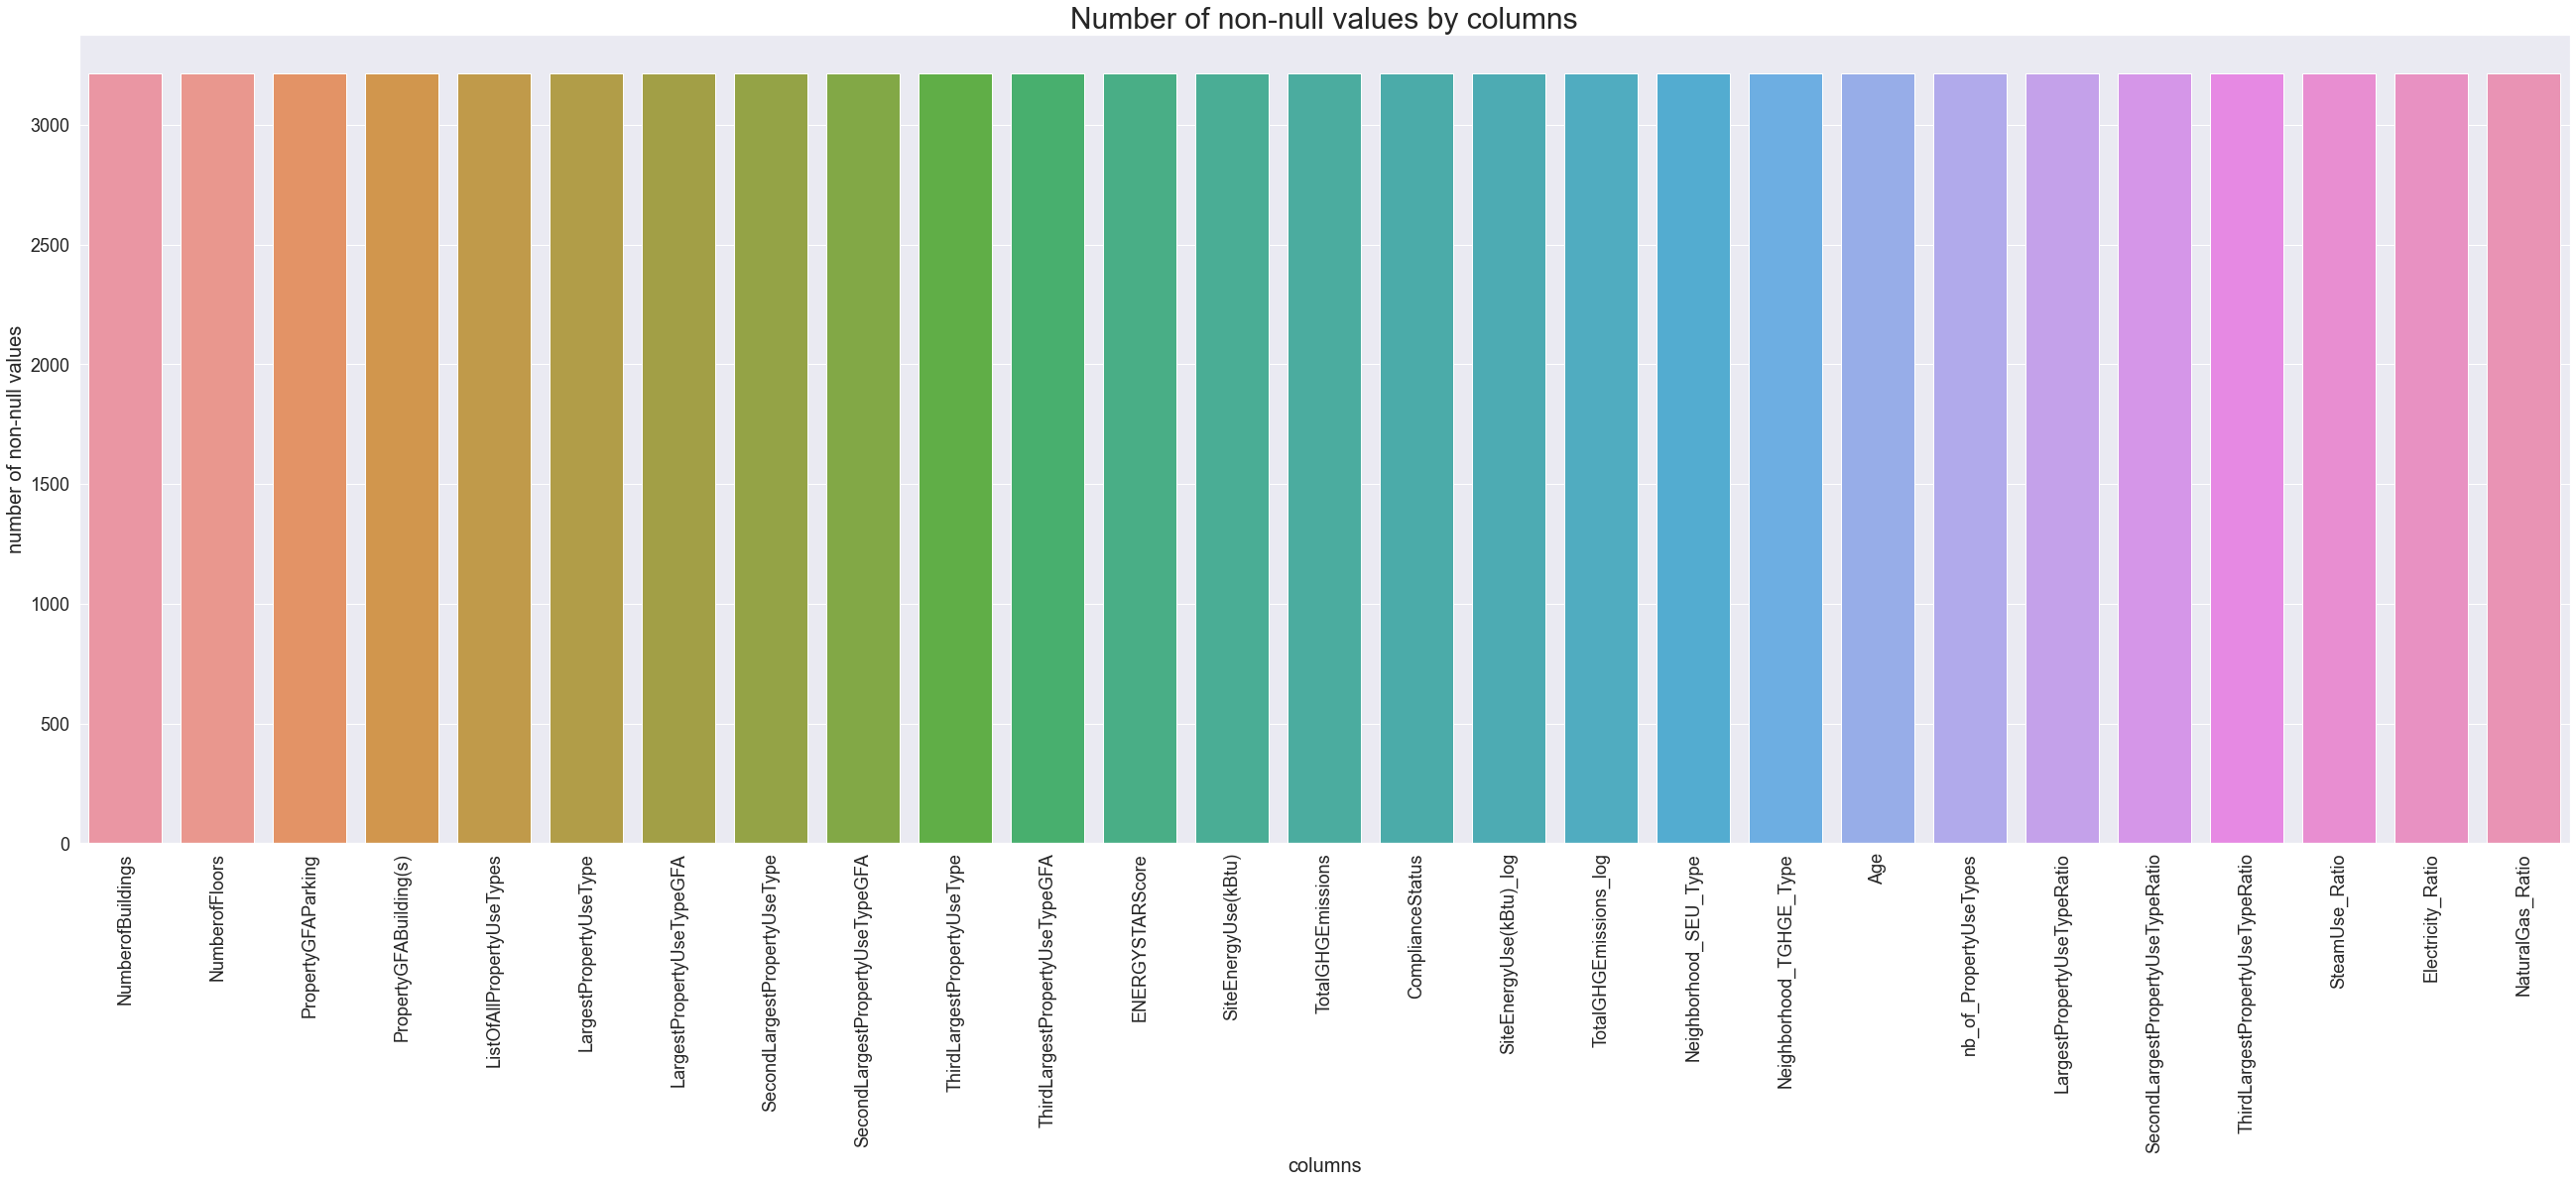

In [99]:
DataSetsExplo(df)

## 11.3. Outliers in Targets <a class="anchor" id="section_11_3"></a>

In this section, we will delete observation with outliers values in targets (with interquartile method).

In [100]:
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    print(df[(df[feature] < lower_limit) | (df[feature] > upper_limit)].index)

In [101]:
outliers(df, 'SiteEnergyUse(kBtu)_log')

Int64Index([ 114,  155,  158,  315,  519,  538,  575,  833,  873,  945,  978,
            1018, 1021, 1072, 1193, 1228, 1234, 1315, 1472, 1556, 1606, 1691,
            1730, 1733, 1897, 2109, 2110, 2167, 2296, 2424, 2466, 2538, 2570,
            2612, 2615, 2827, 3076, 3131, 3170, 3175],
           dtype='int64')


In [102]:
outliers(df, 'TotalGHGEmissions_log')

Int64Index([  42,  114,  155,  158,  240,  315,  575,  873,  945, 1018, 1021,
            1072, 1228, 1529, 1556, 1606, 1620, 1691, 1730, 1733, 1820, 1897,
            2065, 2167, 2424, 2538, 2612, 2615, 2827, 2872, 3133, 3170, 3175],
           dtype='int64')


In [103]:
df.drop(index = [113,  152,  155,  513,  531,  568,  824,  864,  965, 1005, 
                 1008, 1057, 1177, 1212, 1453, 1667, 1704, 1707, 2080, 2081, 
                 2137, 2264, 2392, 2434, 2534, 2576, 2579, 2787, 3033, 3087,
                 3125, 42, 236, 1509, 1597, 1793, 2035, 3089], inplace = True)

In [104]:
df.reset_index(inplace = True, drop = True)

Dataset has  3178 rows and  27 columns
Number of non-null values by columns :
NumberofBuildings                    3178
NumberofFloors                       3178
PropertyGFAParking                   3178
PropertyGFABuilding(s)               3178
ListOfAllPropertyUseTypes            3178
LargestPropertyUseType               3178
LargestPropertyUseTypeGFA            3178
SecondLargestPropertyUseType         3178
SecondLargestPropertyUseTypeGFA      3178
ThirdLargestPropertyUseType          3178
ThirdLargestPropertyUseTypeGFA       3178
ENERGYSTARScore                      3178
SiteEnergyUse(kBtu)                  3178
TotalGHGEmissions                    3178
ComplianceStatus                     3178
SiteEnergyUse(kBtu)_log              3178
TotalGHGEmissions_log                3178
Neighborhood_SEU_Type                3178
Neighborhood_TGHGE_Type              3178
Age                                  3178
nb_of_PropertyUseTypes               3178
LargestPropertyUseTypeRatio          317

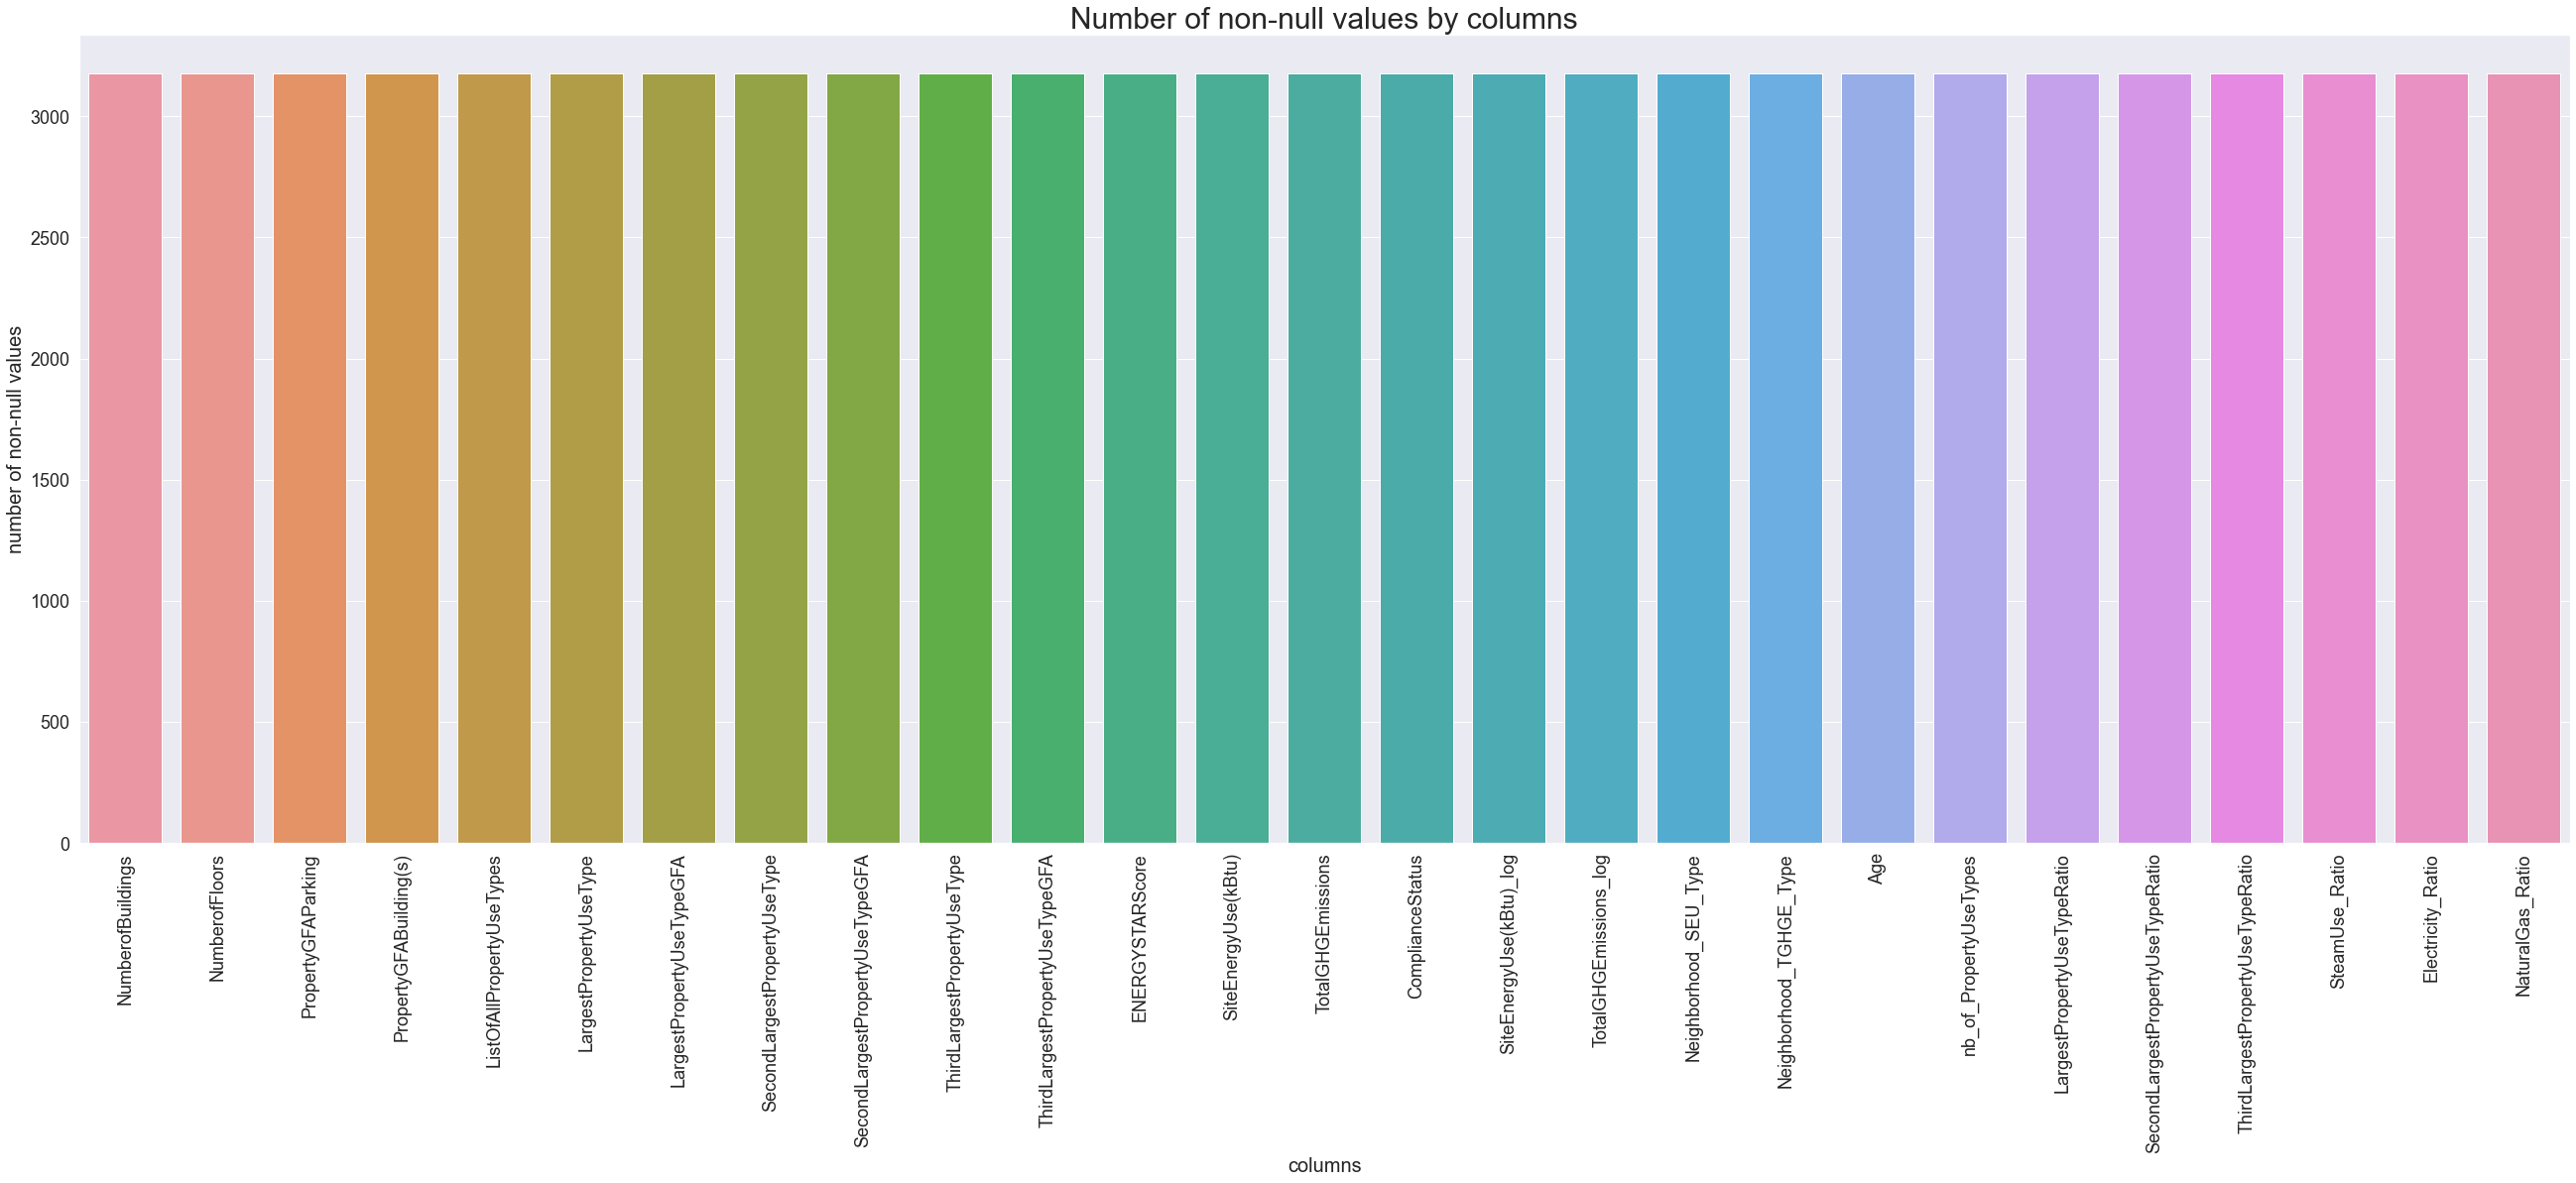

In [105]:
DataSetsExplo(df)

# 12. Exploratory <a class="anchor" id="chapter12"></a>

In [106]:
columns_2 = ['LargestPropertyUseType', 'NumberofFloors', 'ENERGYSTARScore', 'Age']

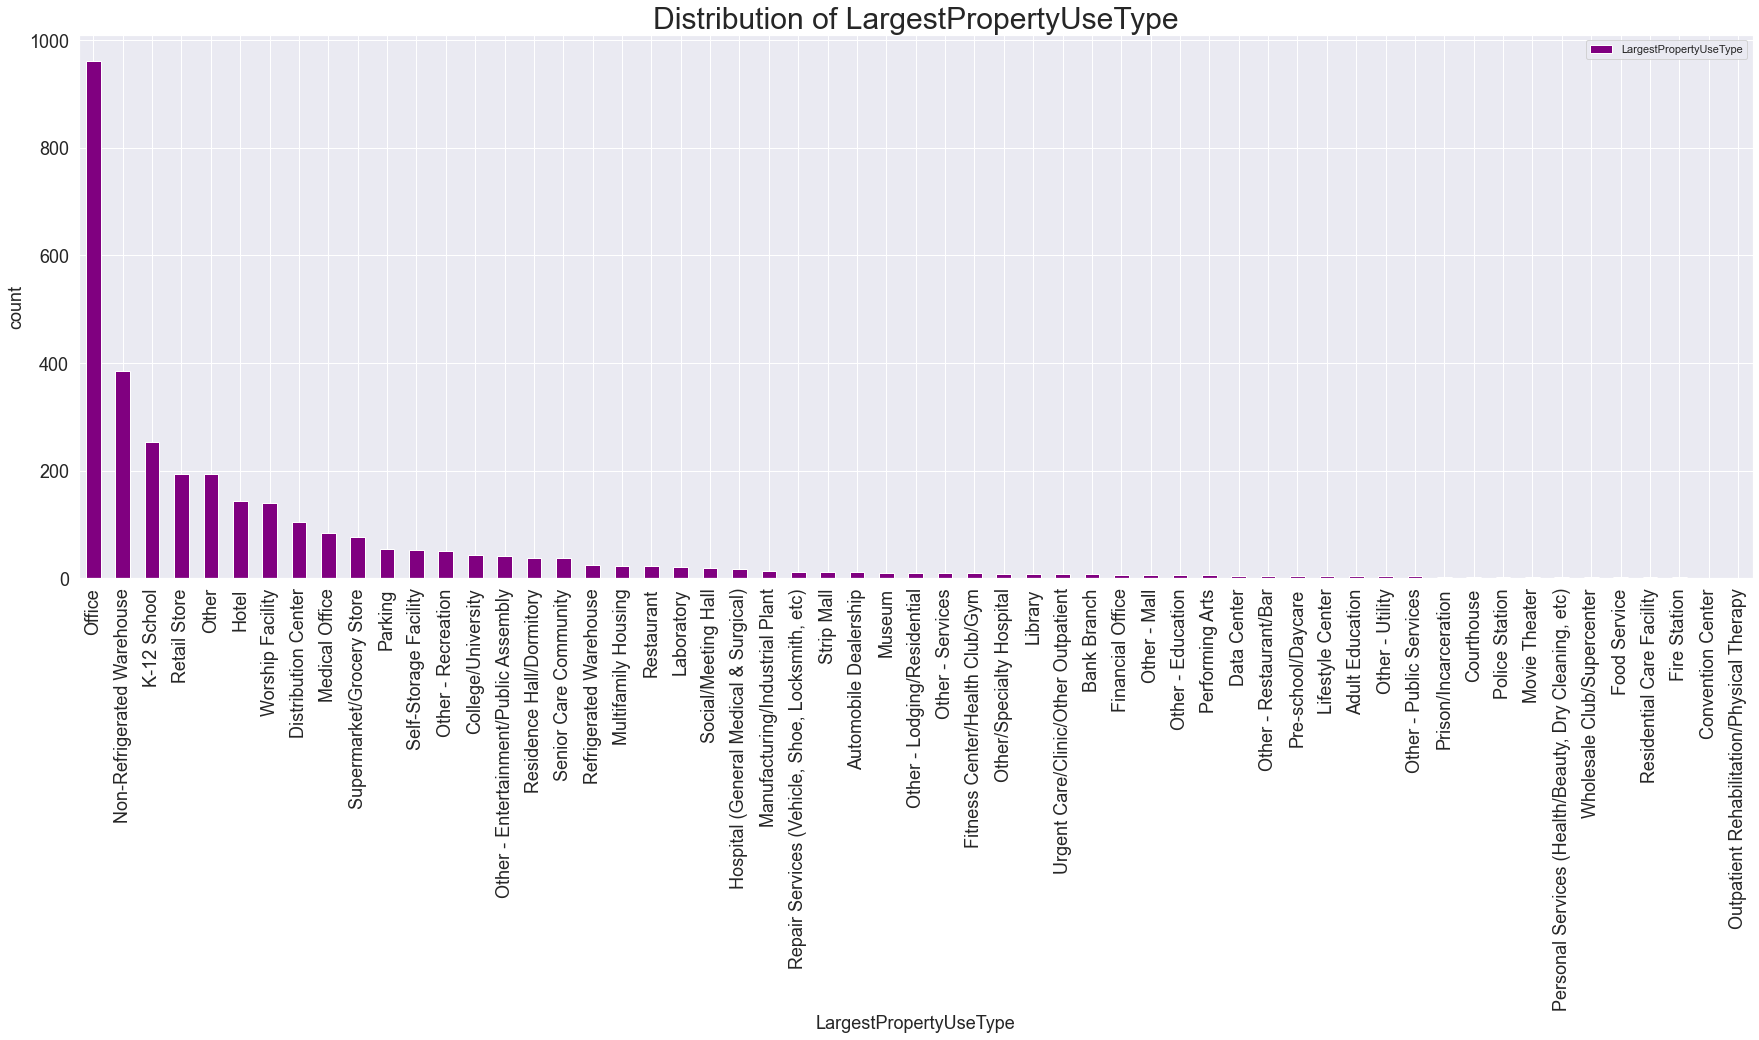

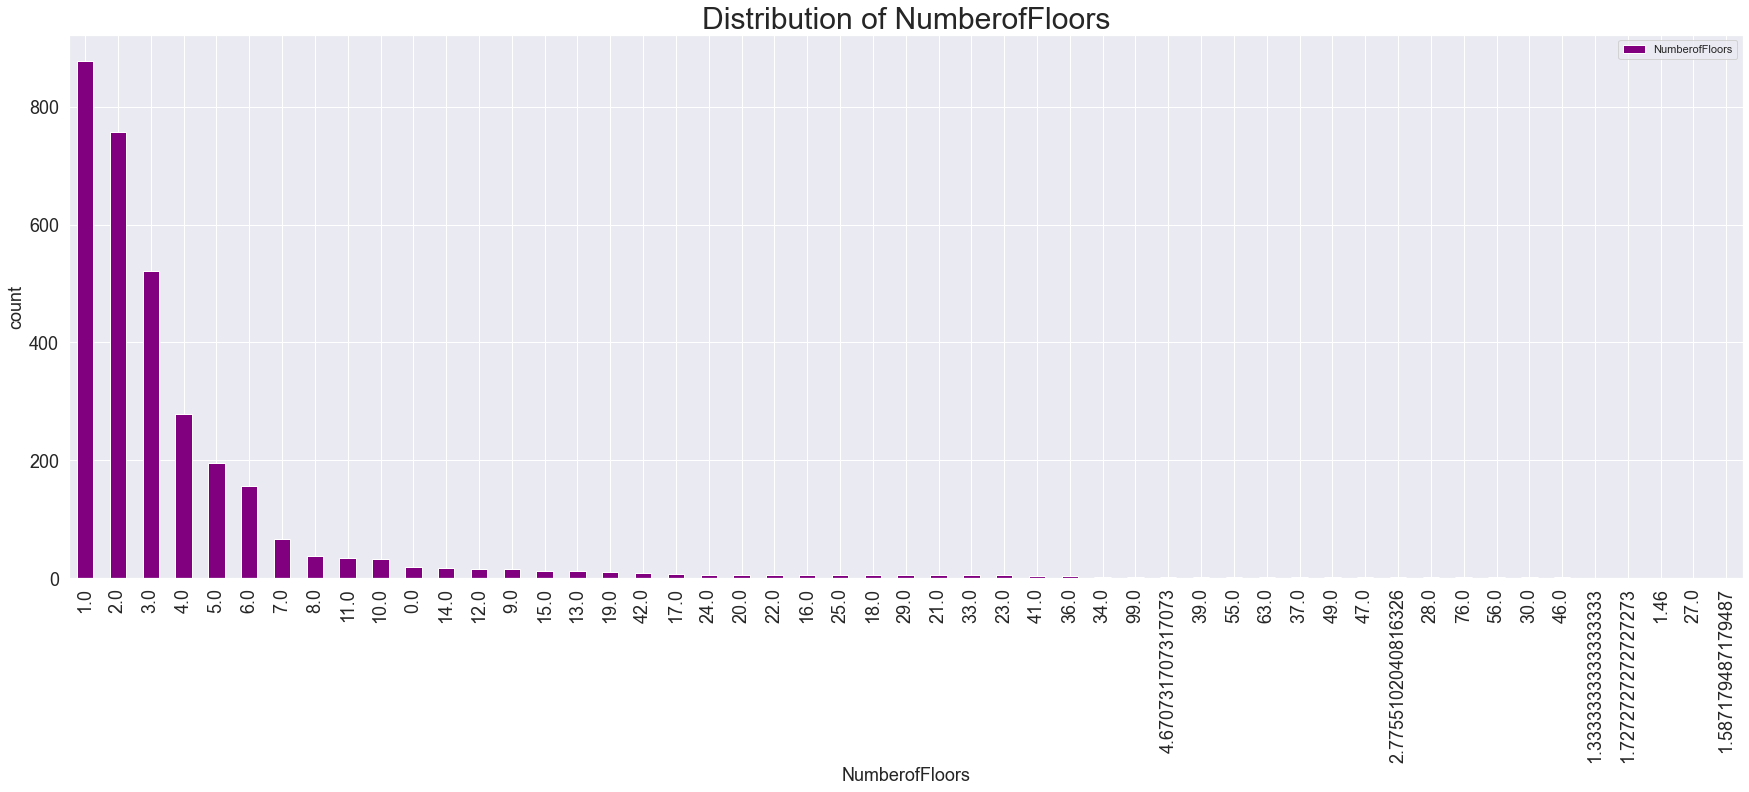

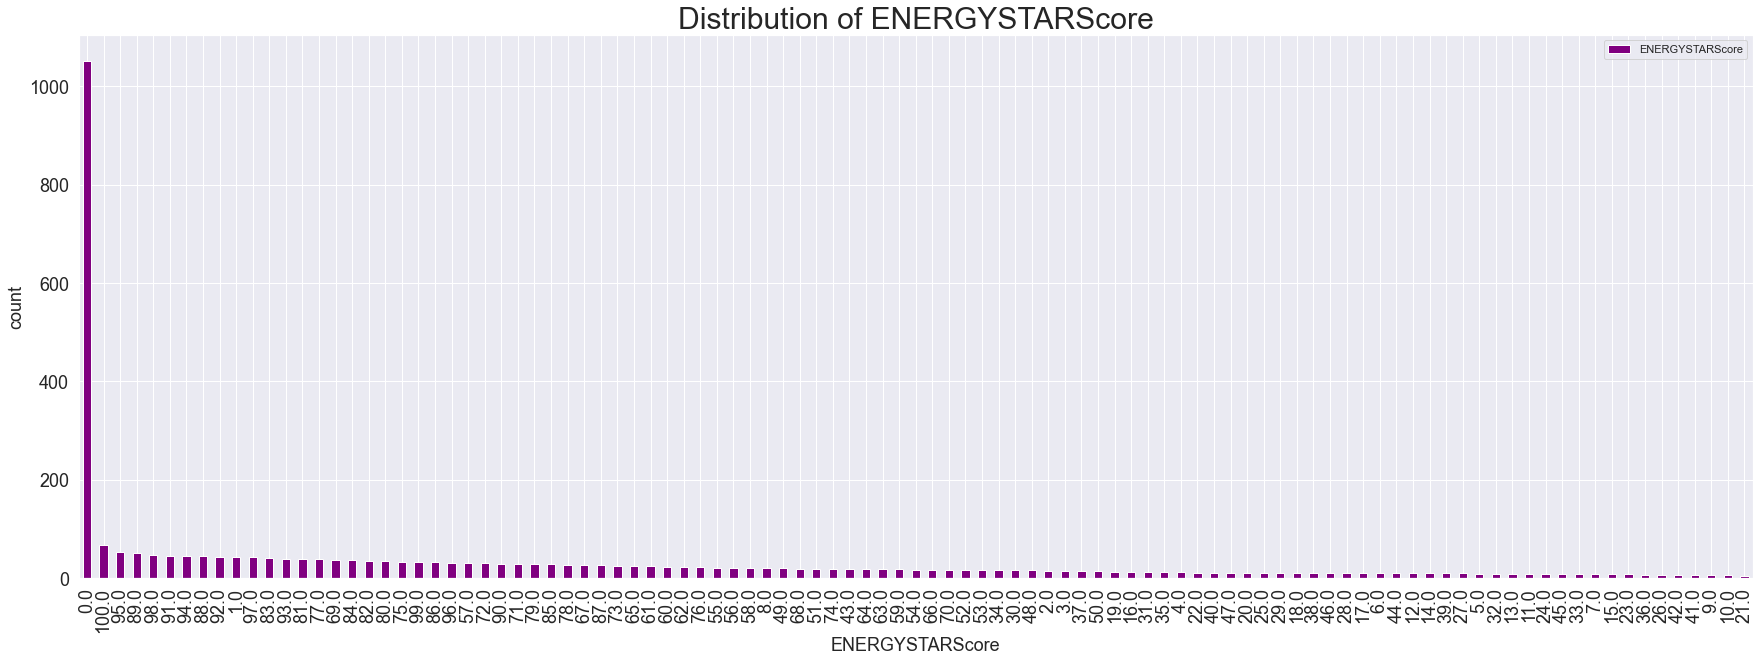

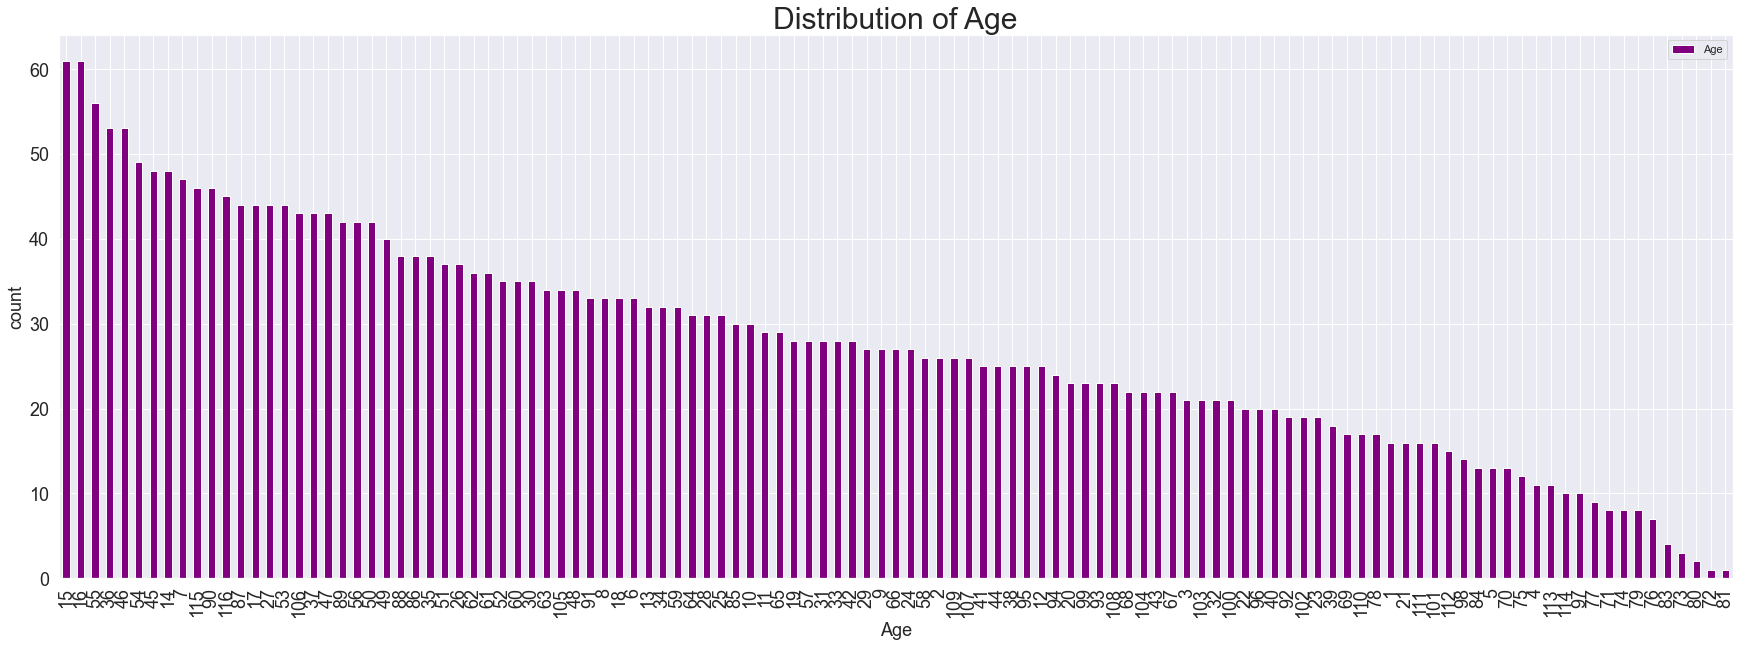

In [107]:
for col in columns_2:
    plt.figure()
    plt.title('Distribution of ' + col, size = 30)
    plt.xlabel(col, size = 18)
    plt.ylabel('count', size = 18)
    df[col].value_counts().plot(x = col, y = 'count', kind = 'bar', figsize = (30,10), legend = True, color = 'purple', fontsize = 18)

In [108]:
df.describe()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
count        3178.000000     3178.000000         3178.000000   
mean            1.120201        4.129641        13360.858087   
std             2.264955        6.609863        43675.786599   
min             0.000000        0.000000           -2.000000   
25%             1.000000        1.000000            0.000000   
50%             1.000000        2.000000            0.000000   
75%             1.000000        4.000000            0.000000   
max           111.000000       99.000000       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.178000e+03               3.178000e+03   
mean             1.021531e+05               9.516192e+04   
std              2.366371e+05               2.283253e+05   
min             -5.055000e+04               5.656000e+03   
25%              2.832000e+04               2.526200e+04   
50%              4.679850e+04               4.301600e+04   
75%              9.380300e+04               8.995500e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      3178.000000                     3178.000000   
mean                      18482.681339                     2998.385273   
std                       51171.770924                    16241.943343   
min                           0.000000                        0.000000   
25%                           0.000000                        0.000000   
50%                           0.000000                        0.000000   
75%                       12622.000000                        0.000000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEnergyUse(kBtu)  TotalGHGEmissions  \
count      3178.000000         3.178000e+03        3178.000000   
mean         43.384204         8.066406e+06         175.528515   
std          38.386574         2.552458e+07         668.976799   
min           0.000000         1.144100e+04           0.000000   
25%           0.000000         1.241540e+06          19.882500   
50%          48.000000         2.518779e+06          49.025000   
75%          81.000000         6.862398e+06         138.365000   
max         100.000000         8.739237e+08       16870.980000   

       SiteEnergyUse(kBtu)_log  TotalGHGEmissions_log          Age  \
count              3178.000000            3178.000000  3178.000000   
mean                 14.897240               3.978666    53.979232   
std                   1.319970               1.443375    32.830143   
min                   9.345046               0.000000     1.000000   
25%                  14.031864               3.038911    27.000000   
50%                  14.739285               3.912523    50.000000   
75%                  15.741568               4.937096    86.000000   
max                  20.588504               9.733410   116.000000   

       nb_of_PropertyUseTypes  LargestPropertyUseTypeRatio  \
count             3178.000000                  3178.000000   
mean                 1.892070                     0.859347   
std                  1.188813                     0.185479   
min                  1.000000                     0.333333   
25%                  1.000000                     0.724969   
50%                  2.000000                     1.000000   
75%                  2.000000                     1.000000   
max                 11.000000                     1.000000   

       SecondLargestPropertyUseTypeRatio  ThirdLargestPropertyUseTypeRatio  \
count                        3178.000000                       3178.000000   
mean                            0.118846                          0.021807   
std                             0.153696                          0.057801   
min                             0.000000                          0.000000   
25%                             0.000000       

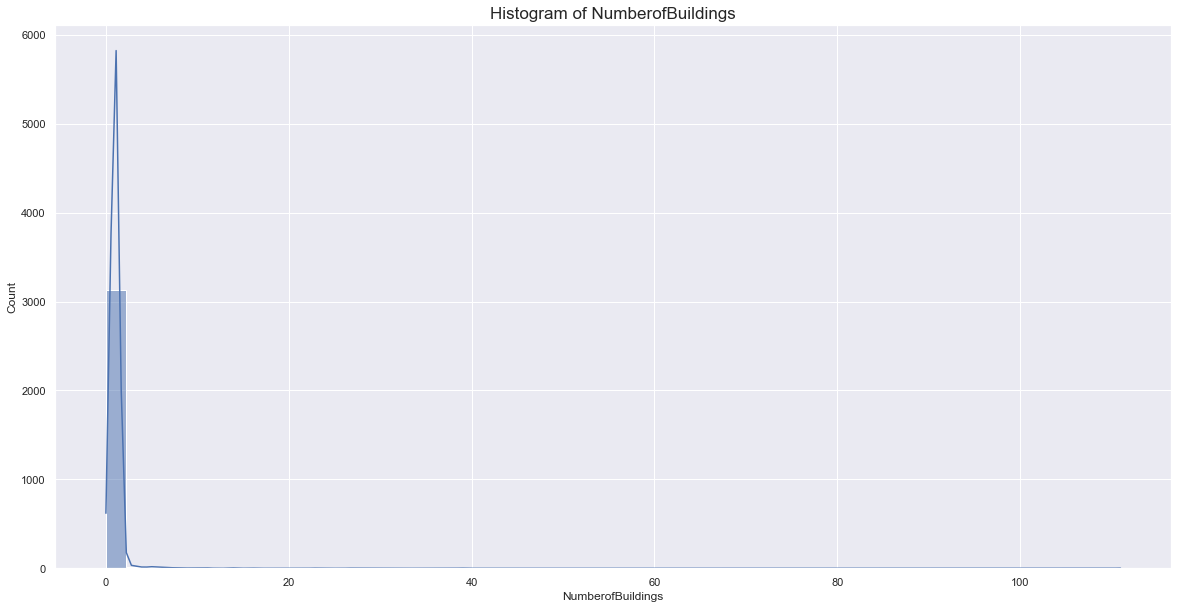

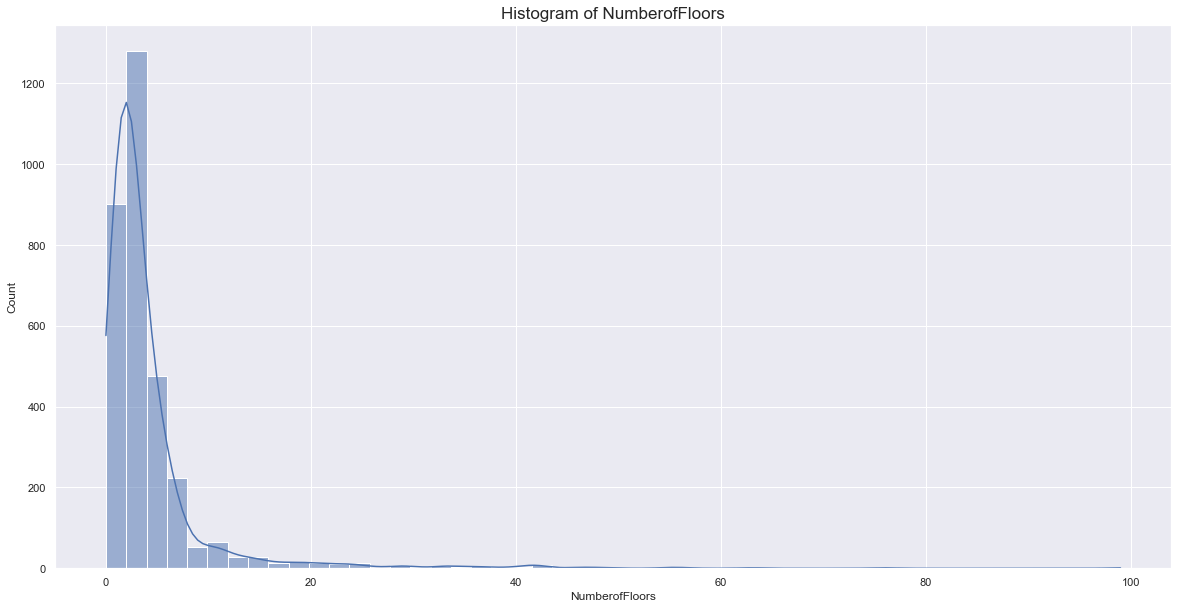

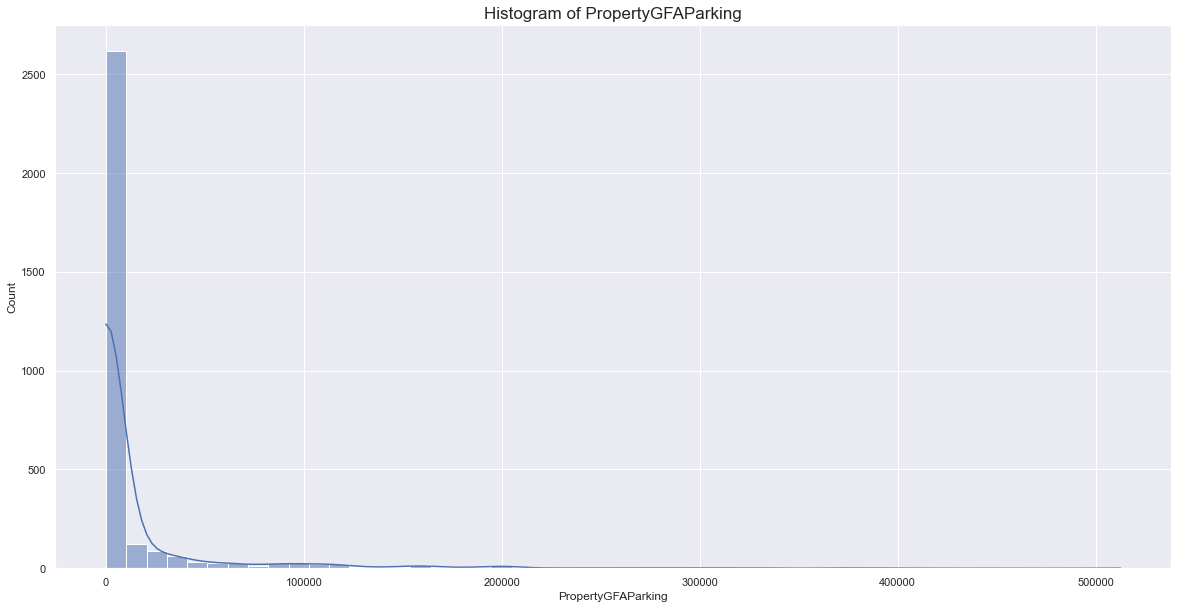

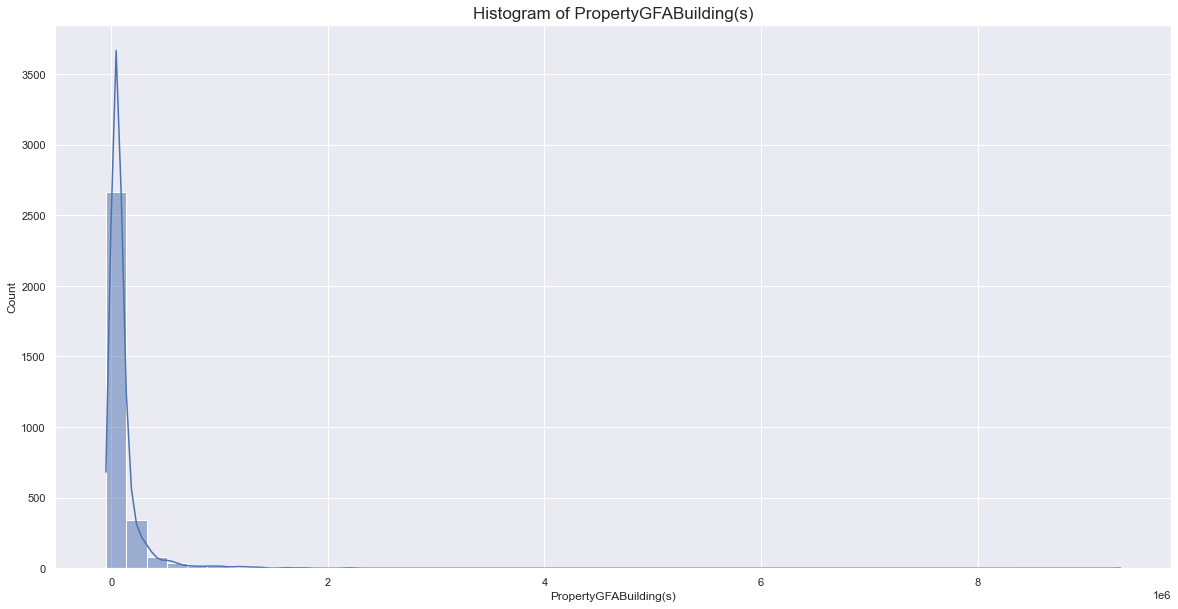

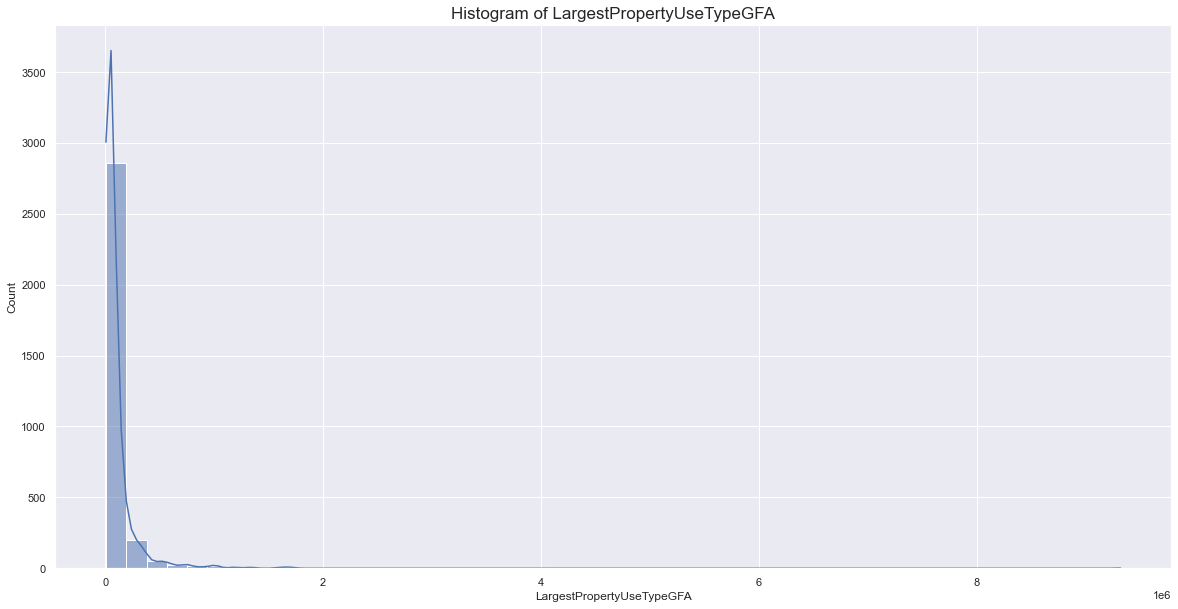

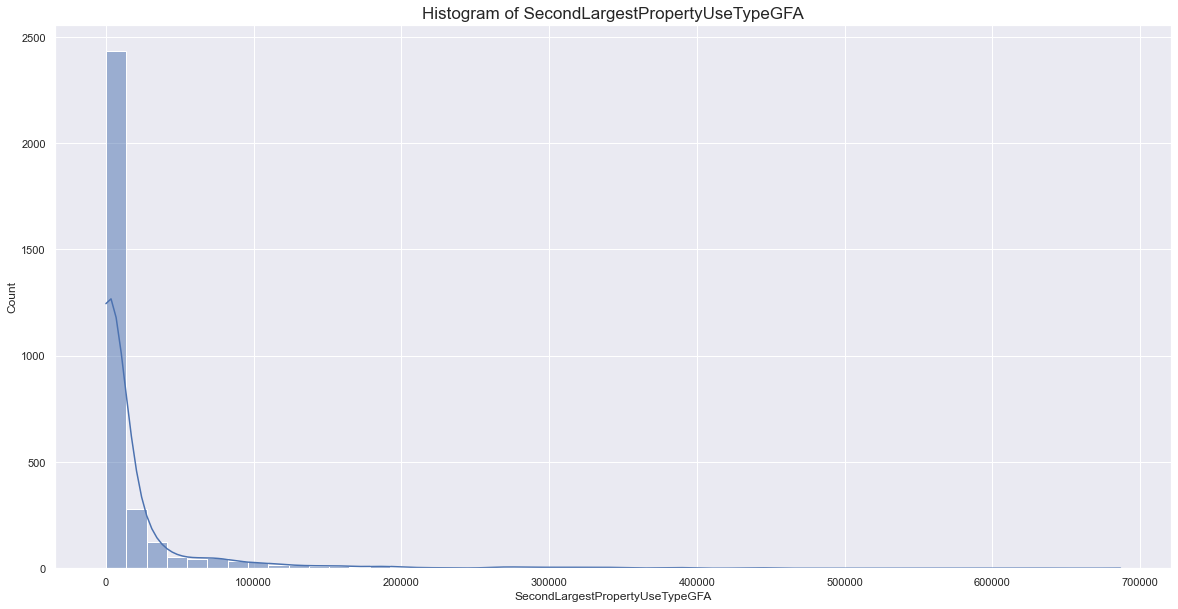

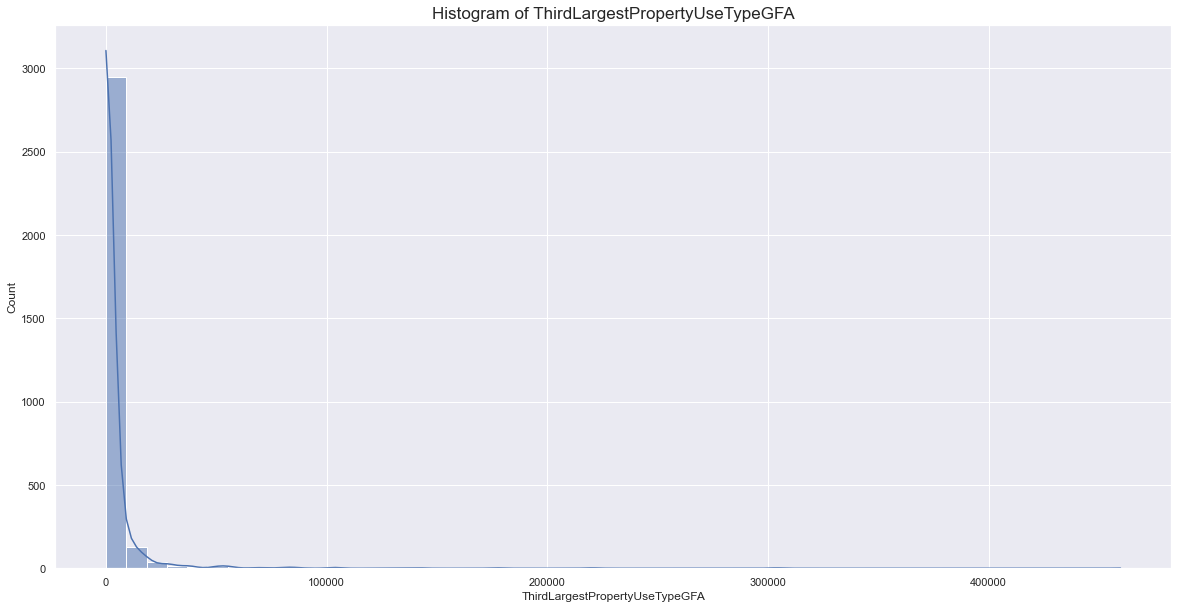

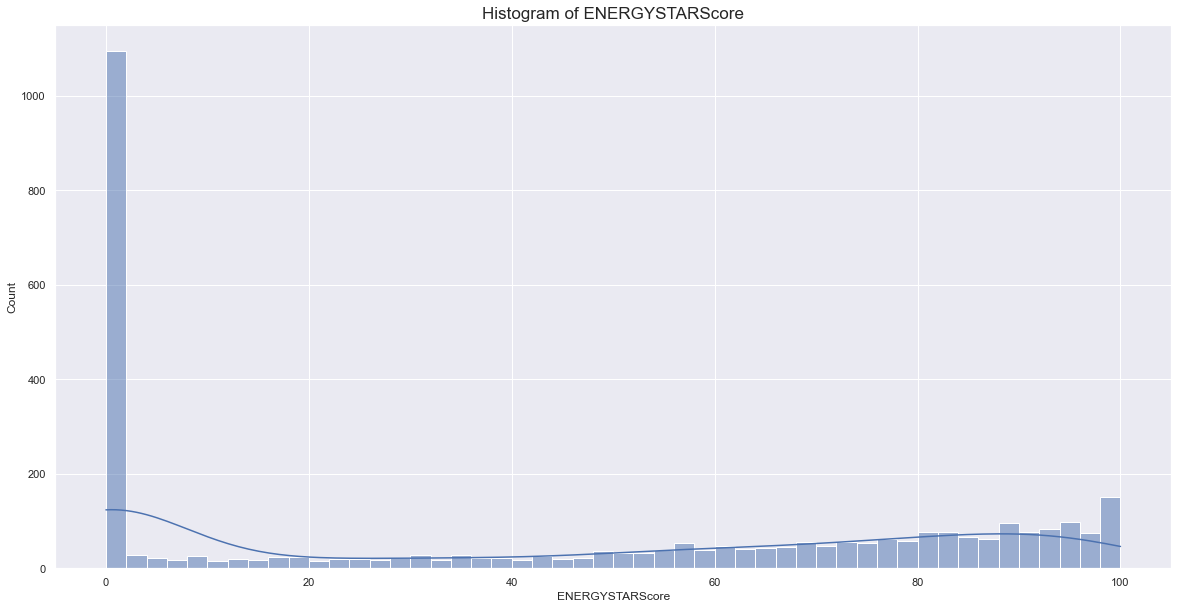

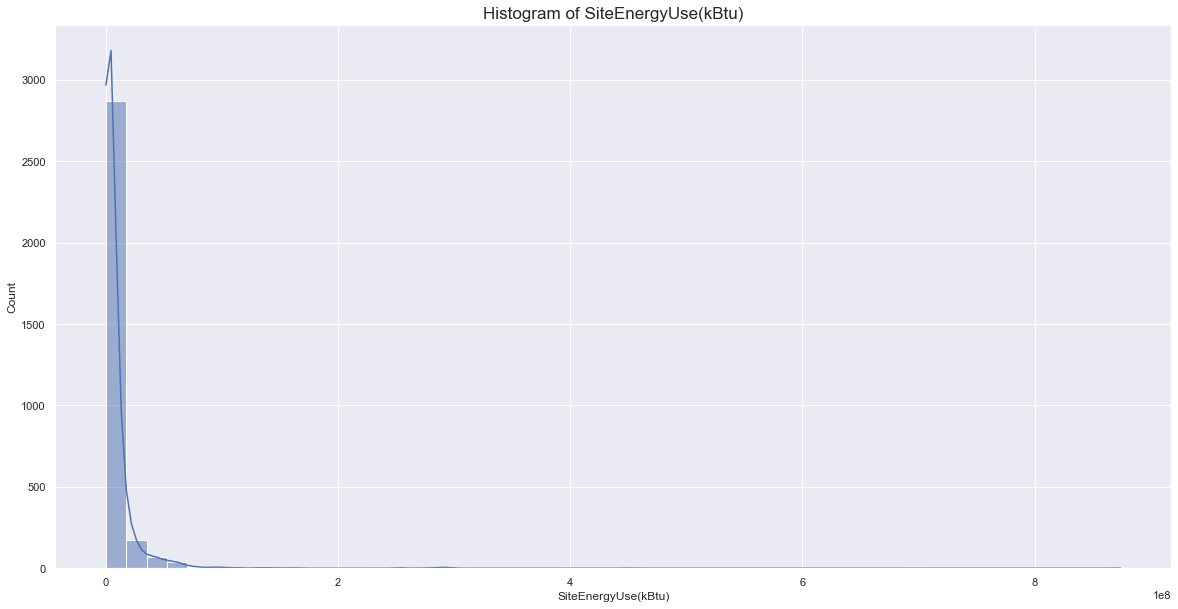

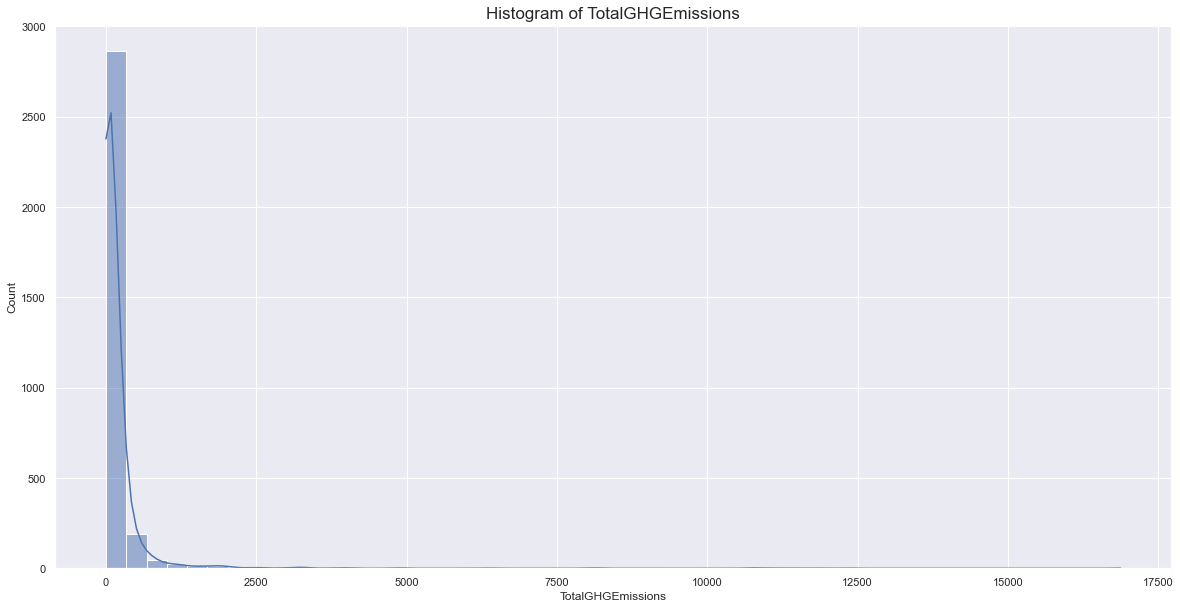

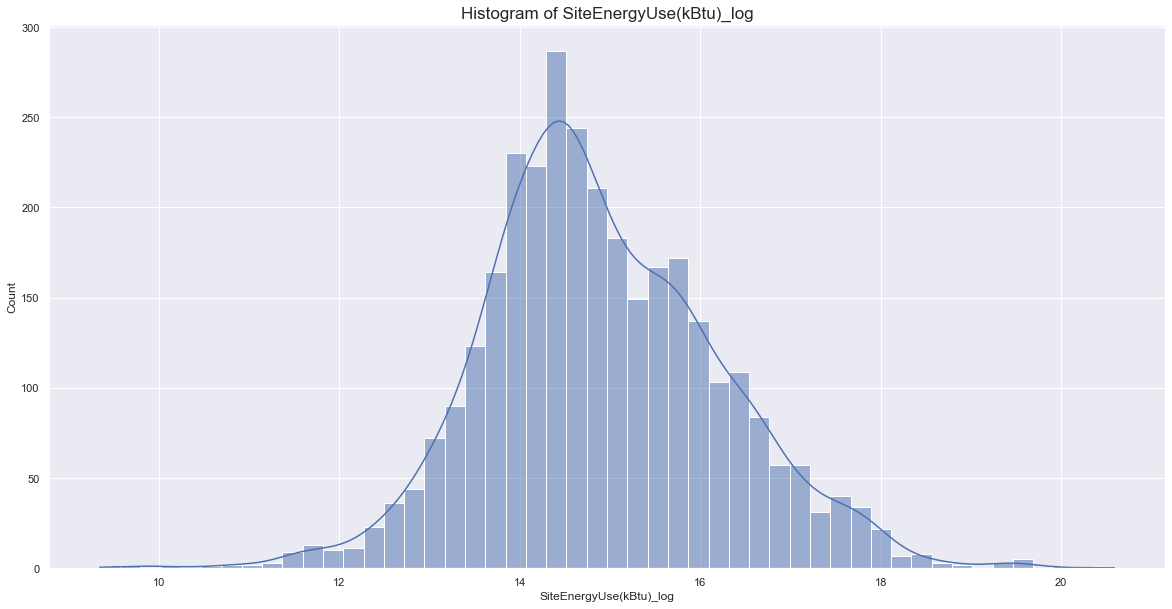

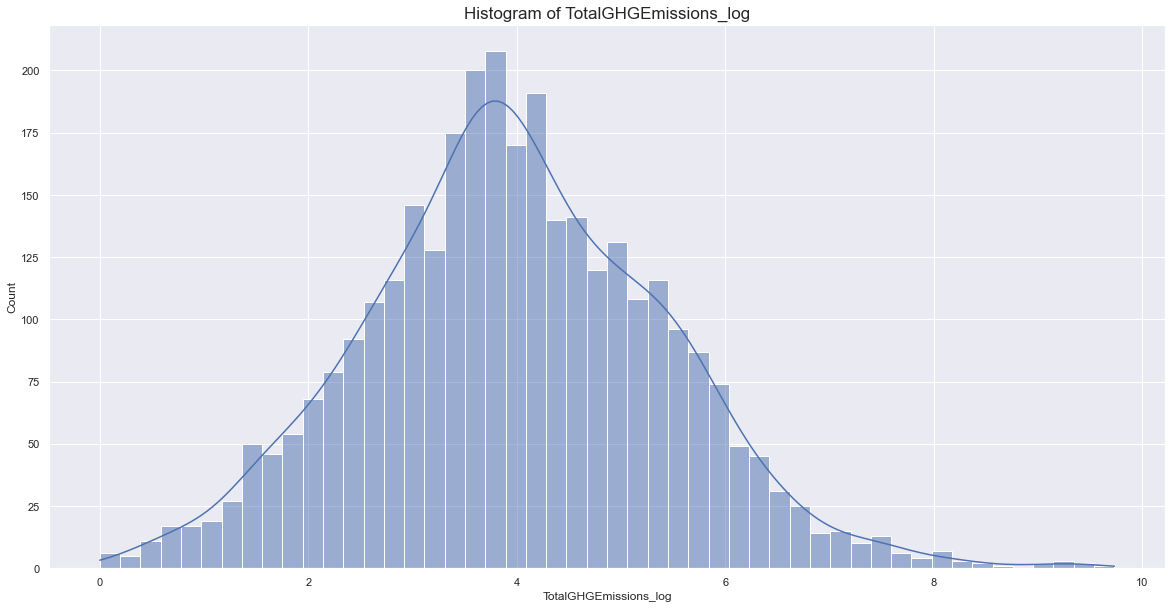

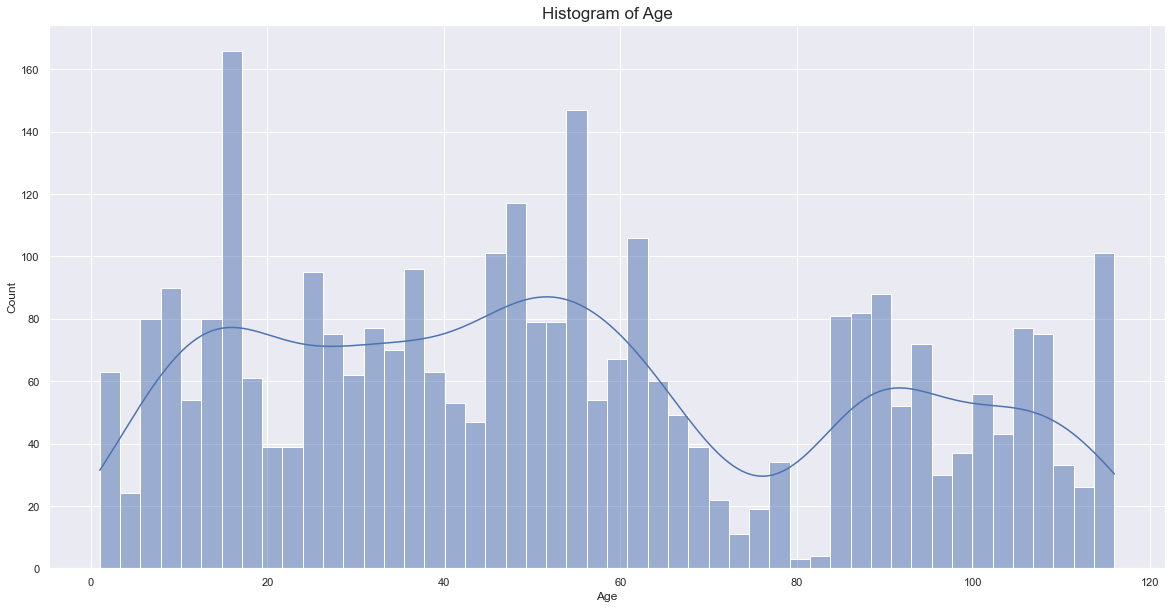

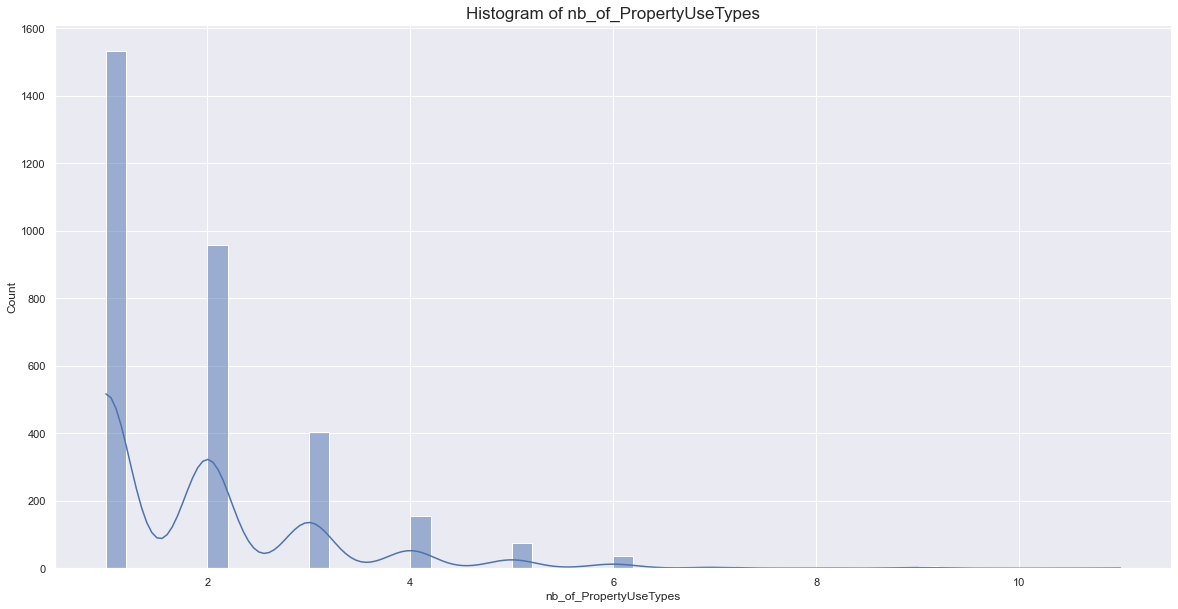

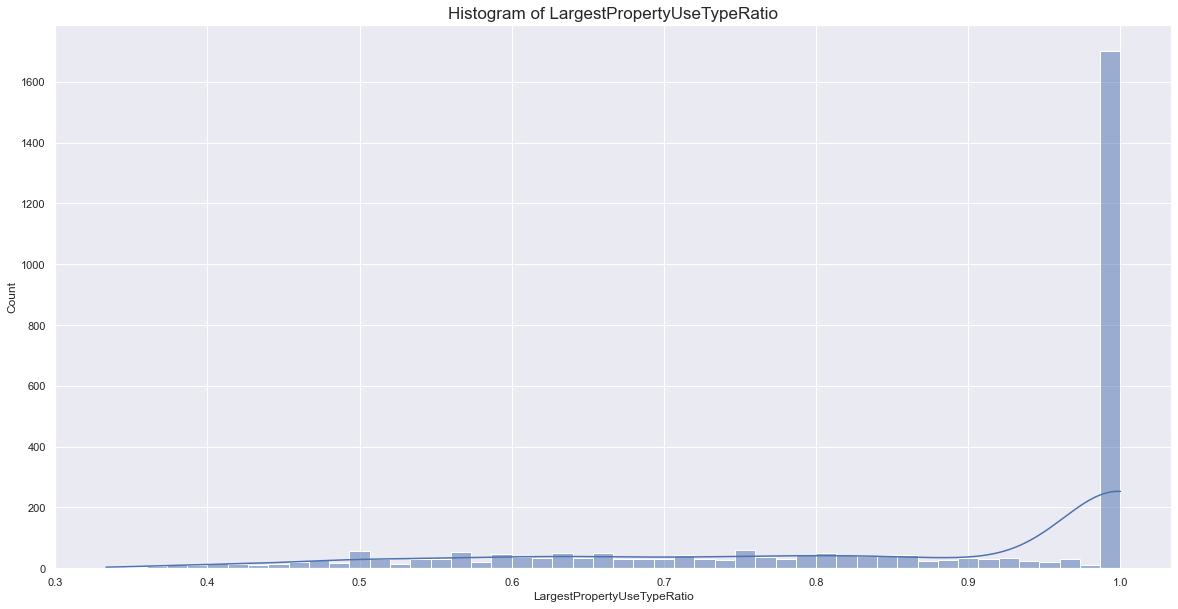

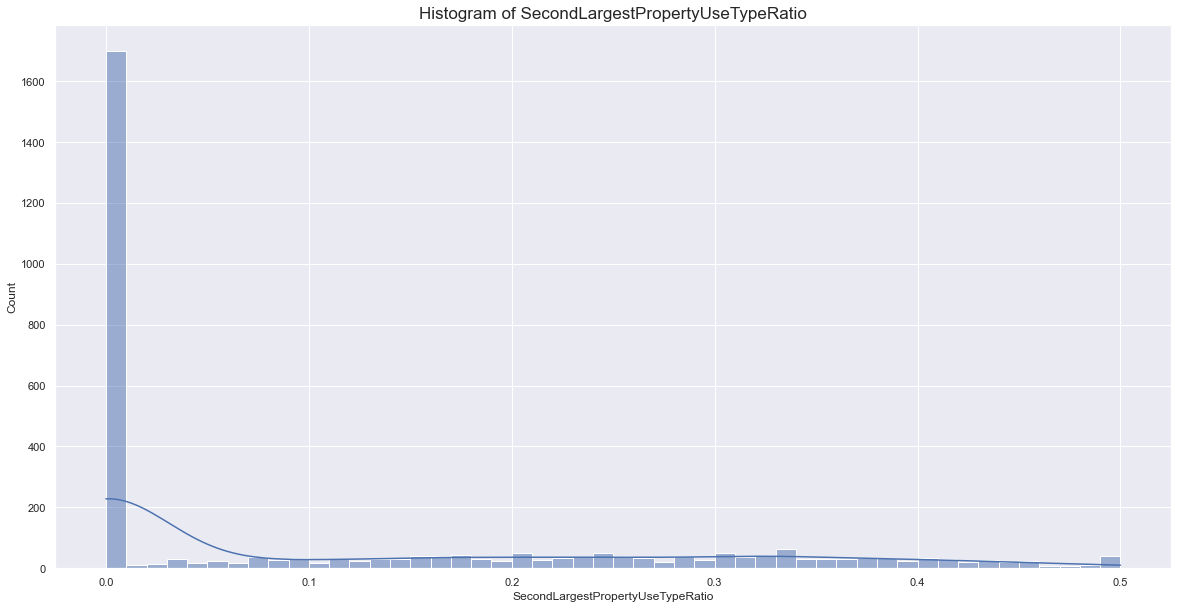

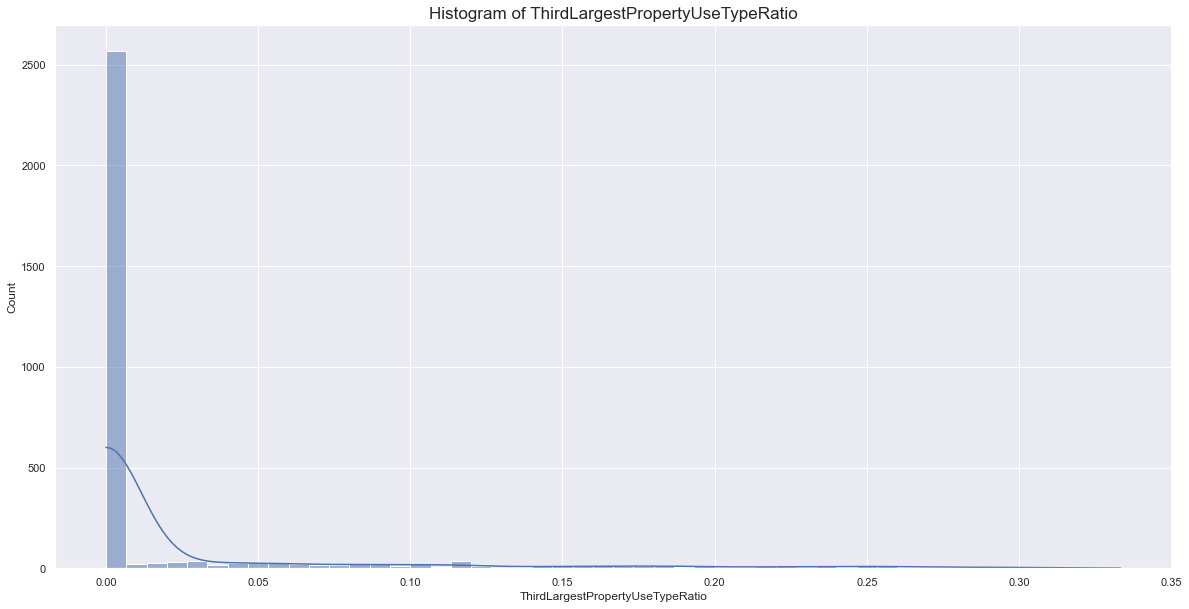

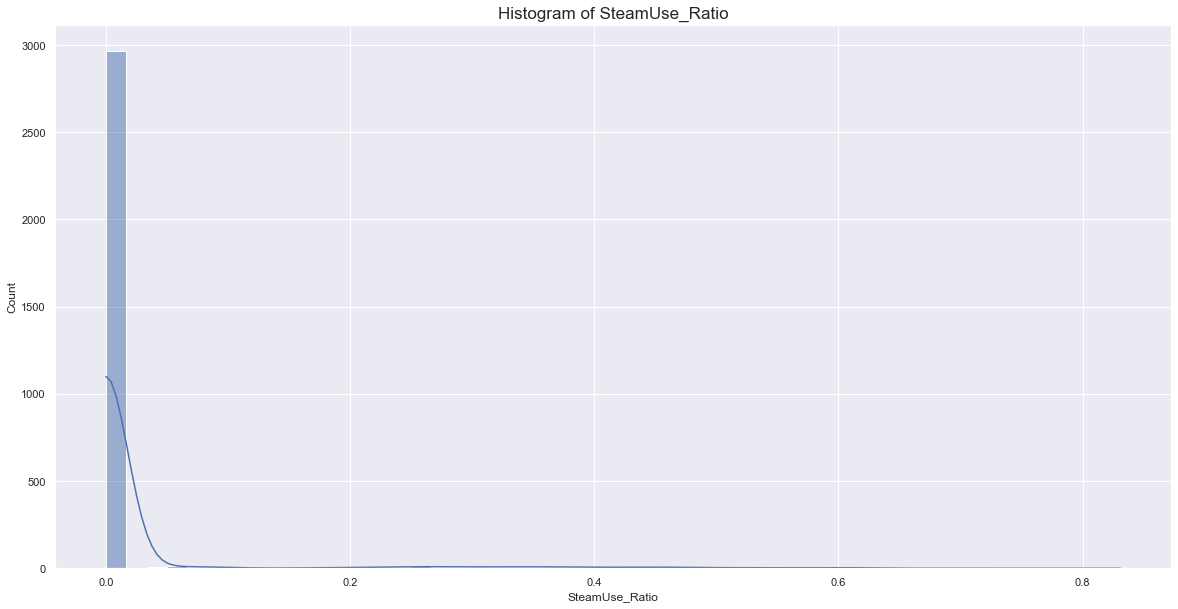

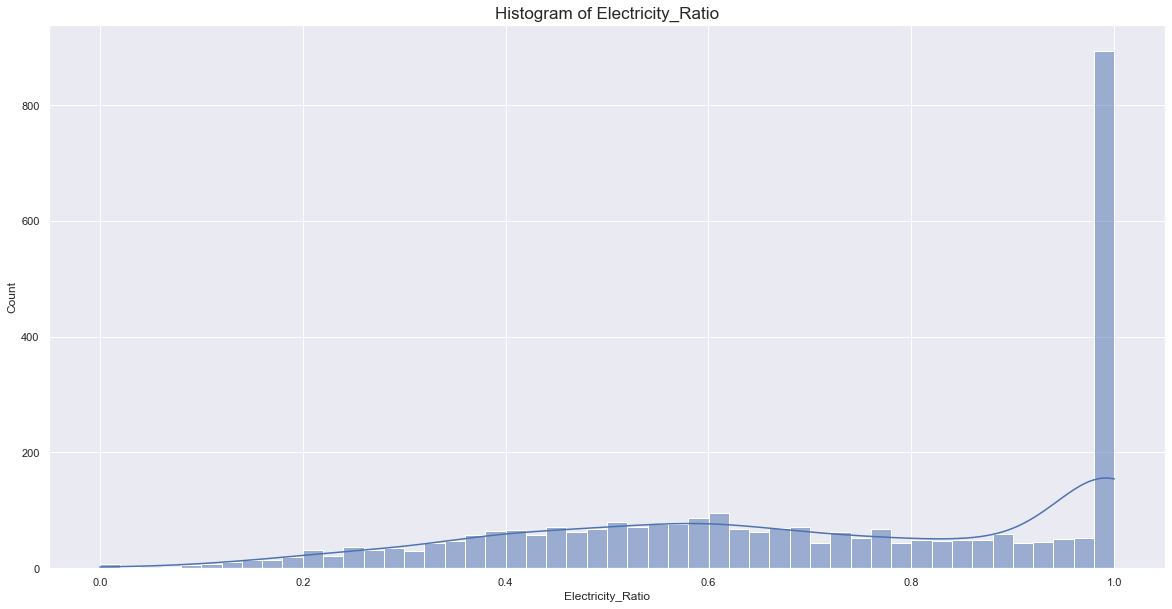

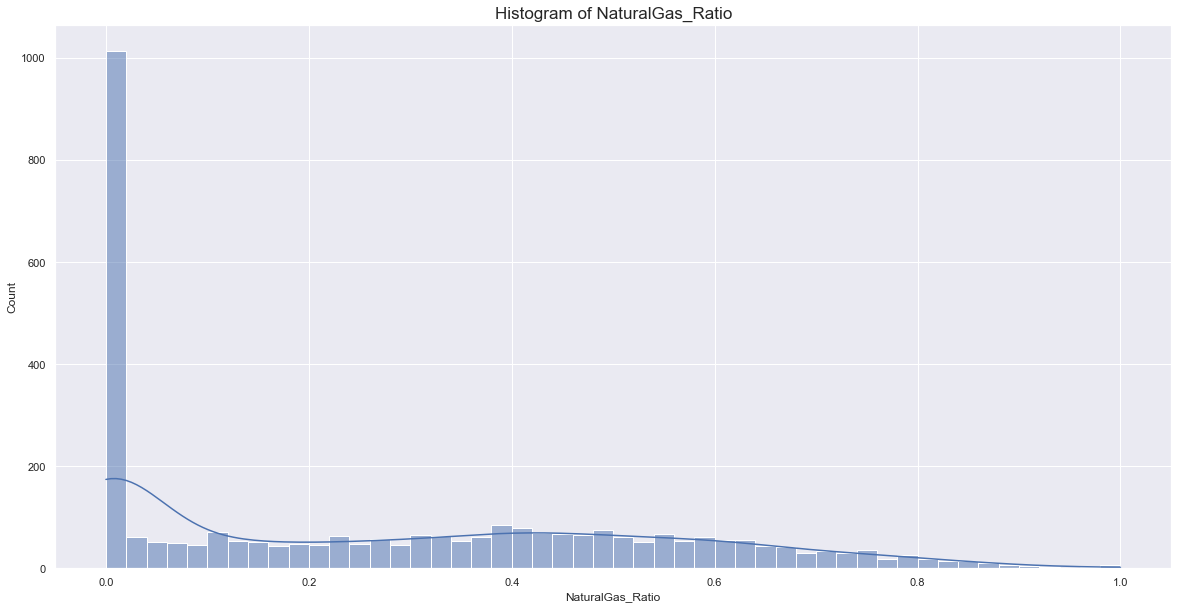

In [109]:
for col in df.select_dtypes(['float64', 'int64']):
    plt.figure(figsize = (20,10))
    plt.title('Histogram of ' + col, size = 17)
    plt.xlabel(col, size = 12)
    sns.histplot(df[col], bins = 50, kde = True)

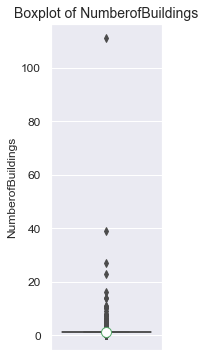

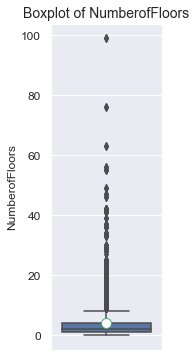

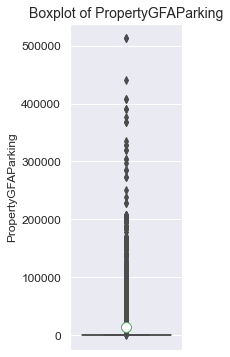

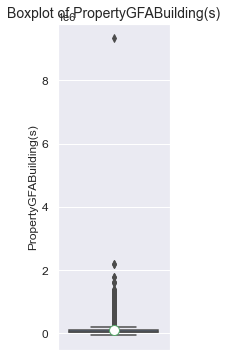

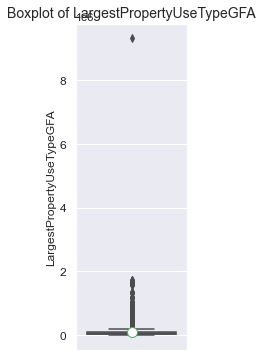

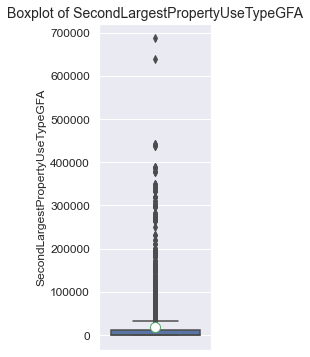

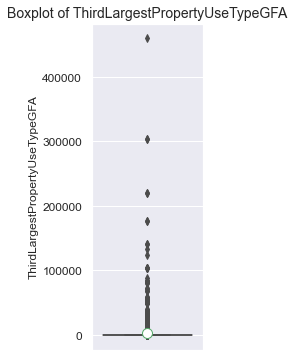

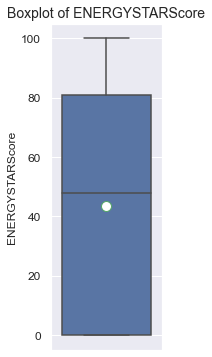

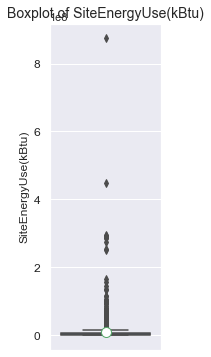

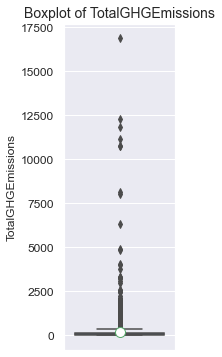

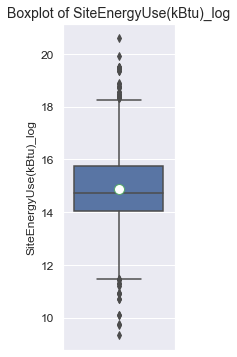

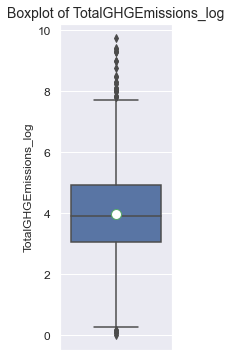

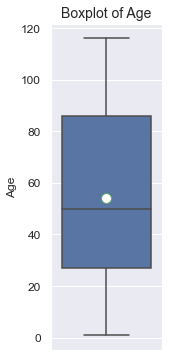

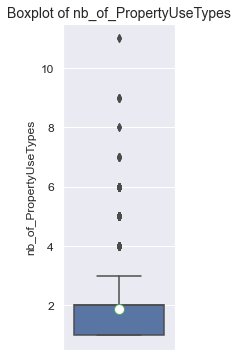

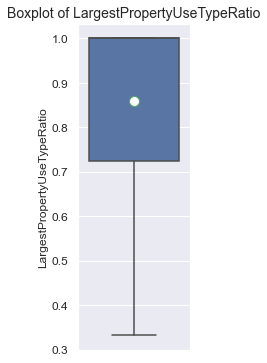

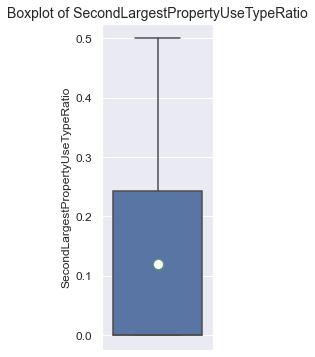

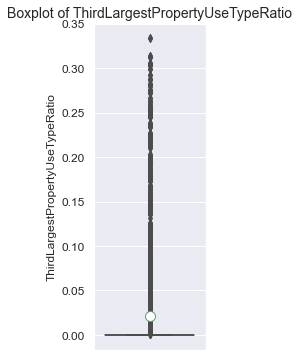

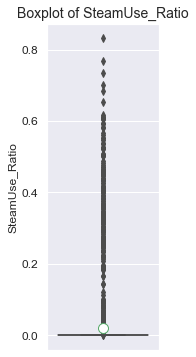

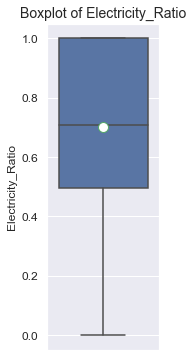

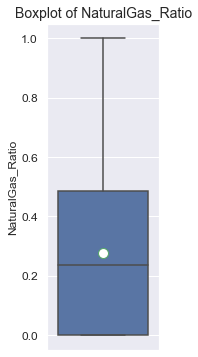

In [110]:
for col in df.select_dtypes(['float64', 'int64']):
    plt.figure(figsize = (2,6))
    plt.title("Boxplot of " + col, size = 14)
    plt.yticks(fontsize = 12)
    ax = sns.boxplot(y = col, data = df, showmeans = True, meanprops={"marker":"o", "markerfacecolor":"white", "markersize":"10"})

In [111]:
property_10 = df['LargestPropertyUseType'].value_counts().sort_values(ascending = False)[:10]
age_10 = df['Age'].value_counts().sort_values(ascending = False)[:10]

<AxesSubplot:title={'center':'Dispersion of ENERGYSTARScore by LargestPropertyUseType'}, xlabel='LargestPropertyUseType', ylabel='ENERGYSTARScore'>

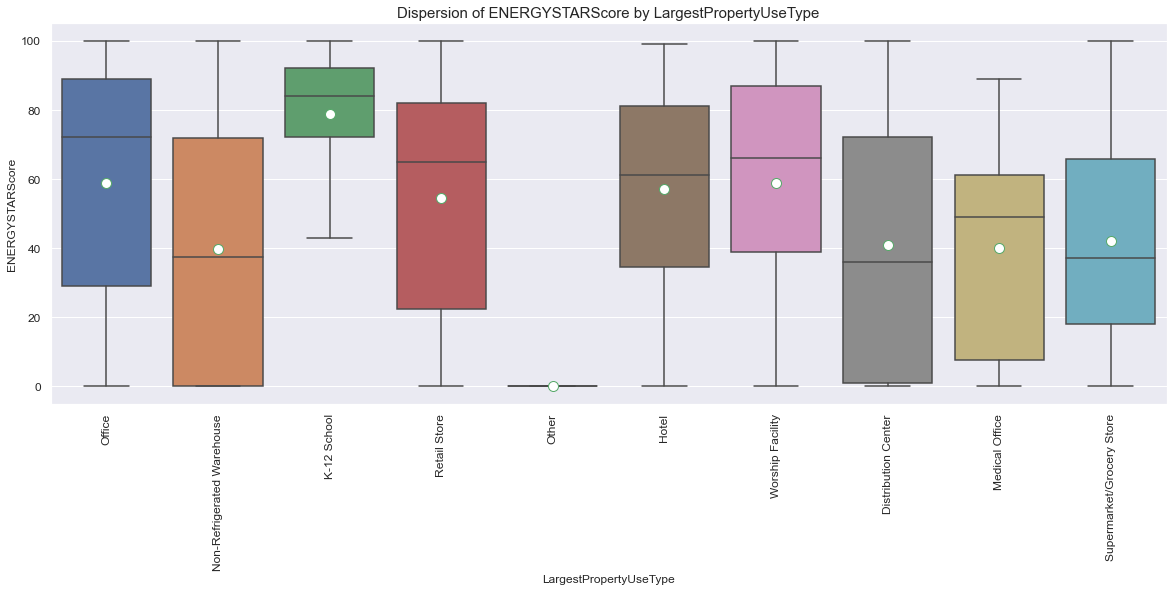

In [112]:
plt.figure(figsize = (20,7))
plt.title("Dispersion of ENERGYSTARScore by LargestPropertyUseType", size = 15)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)
sns.boxplot(x = 'LargestPropertyUseType', y = 'ENERGYSTARScore', data = df, showmeans = True, meanprops={"marker":"o", "markerfacecolor":"white", "markersize":"10"}, order = property_10.index, showfliers = False)

<AxesSubplot:title={'center':'Dispersion of ENERGYSTARScore by Age'}, xlabel='Age', ylabel='ENERGYSTARScore'>

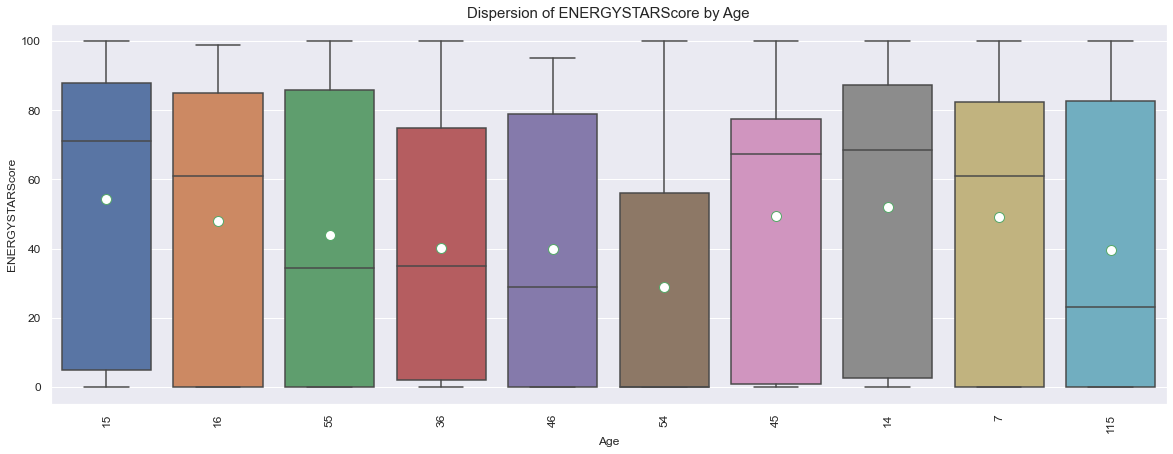

In [113]:
plt.figure(figsize = (20,7))
plt.title("Dispersion of ENERGYSTARScore by Age", size = 15)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)
sns.boxplot(x = 'Age', y = 'ENERGYSTARScore', data = df, showmeans = True, meanprops={"marker":"o", "markerfacecolor":"white", "markersize":"10"}, order = age_10.index, showfliers = False)

<AxesSubplot:title={'center':'Dispersion of ENERGYSTARScore by NumberofFloors'}, xlabel='NumberofFloors', ylabel='ENERGYSTARScore'>

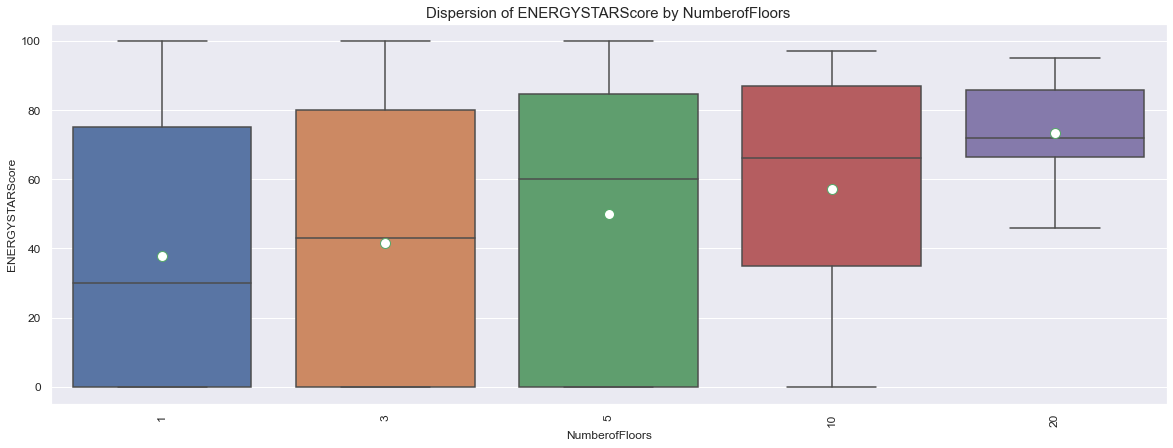

In [114]:
plt.figure(figsize = (20,7))
plt.title("Dispersion of ENERGYSTARScore by NumberofFloors", size = 15)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)
sns.boxplot(x = 'NumberofFloors', y = 'ENERGYSTARScore', data = df, showmeans = True, meanprops={"marker":"o", "markerfacecolor":"white", "markersize":"10"}, order = [1, 3, 5, 10, 20], showfliers = False)

<AxesSubplot:title={'center':'Pearson correlation'}>

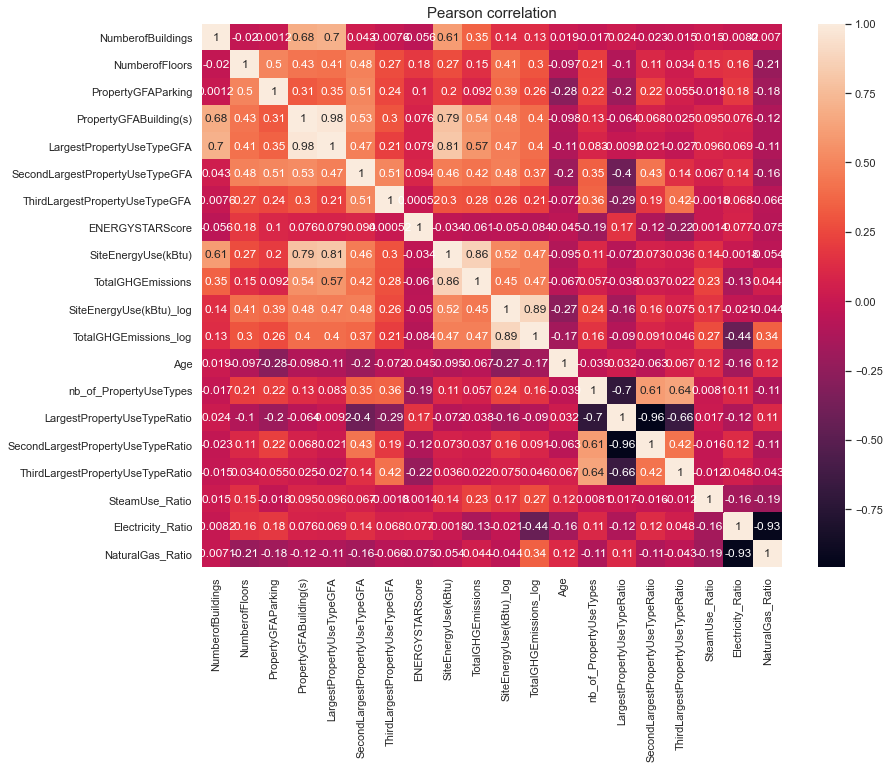

In [115]:
plt.figure(figsize = (13,10))
plt.title('Pearson correlation', size = 15)
sns.heatmap(df.select_dtypes(['float64', 'int64']).corr(method = 'pearson'), annot = True)

<AxesSubplot:title={'center':'Spearman correlation'}>

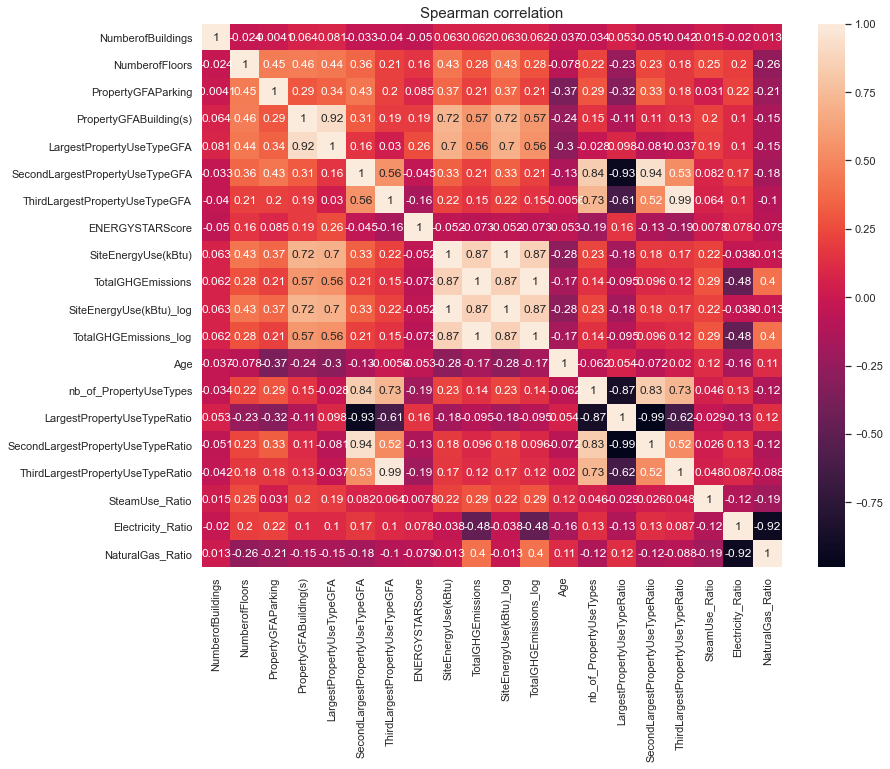

In [116]:
plt.figure(figsize = (13,10))
plt.title('Spearman correlation', size = 15)
sns.heatmap(df.select_dtypes(['float64', 'int64']).corr(method = 'spearman'), annot = True)

In [117]:
df.to_csv('P04_DataClean.csv')